# Team 6 — Milestone 2  
**Members:** `John Holik, Claiton Pinto, Marina Bunyatova`    
**Dataset:** `credit_risk_dataset.csv`  
**Source:** `https://www.kaggle.com/datasets/laotse/credit-risk-dataset`  
**Target:** `loan_status` (binary: 0/1)  


## 0. Dataset Context (From Initial Inspection)

- **Rows × Cols:** 32,581 × 12  
- **Target Distribution (`loan_status`):** 0 ≈ 78.18%, 1 ≈ 21.82%  
- **Missingness (major):** `loan_int_rate` ≈ 9.56%, `person_emp_length` ≈ 2.75%  
- **Duplicates:** 165 exact duplicate rows detected — plan: drop before modeling (document this step).  
- **Quick outliers:** `person_age > 100` (5 rows), `person_emp_length > 50` (2 rows) — plan: handle via capping / rejection rules (justify).



## 1. Environment & Reproducibility

Import Required Libraries

In [1]:
# ========== Standard library ==========
import os
import sys
import json
import random
import warnings
from pathlib import Path
from datetime import datetime

# ========== Core data science ==========
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import scipy.stats as stats

# ========== Plotting ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Pipeline & preprocessing ==========
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV


# ========== Metrics & evaluation ==========
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    brier_score_loss,
)

# ========== Calibration ==========
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# ========== Interpretation ==========
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# ========== Models ==========
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

# ========== Persistence ==========
from joblib import dump, load


## 2. Data Loading & Auditing

- Load `/mnt/data/credit_risk_dataset.csv`.
- Basic audit: shape, dtypes, preview, memory usage.
- **Duplicates:** detect & drop (165 expected; verify).
- **Missingness report:** counts & percentages per column (focus on `loan_int_rate`, `person_emp_length`).
- **Target audit:** class balance & positive class definition.
- Persist a **data dictionary** (CSV) with types, `n_unique`, missingness, example values.

In [2]:
df = pd.read_csv('credit_risk_dataset.csv')

print("======= Dataset Audit =======")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn Data Types:")
print(df.dtypes)
print("\nMissing Values per Column:")
print(df.isnull().sum())
print("\nDuplicate Rows:")
print(df.duplicated().sum())
print("\nStatistical Summary:")
print(df.describe(include='all'))

======= Dataset Audit =======
Number of rows: 32581
Number of columns: 12

Column Data Types:
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

Missing Values per Column:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_len

## 3. Exploratory Data Analysis (EDA)

- Univariate distributions (numeric histograms, categorical bar plots).
- Target vs feature relationships (box/violin for numeric; stacked bars for categorical).
- Correlations (numeric Pearson/Spearman) and multicollinearity scan.
- Detect potential data leakage.


======= EXPLORATORY DATA ANALYSIS =======

Numeric columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

1. UNIVARIATE DISTRIBUTIONS


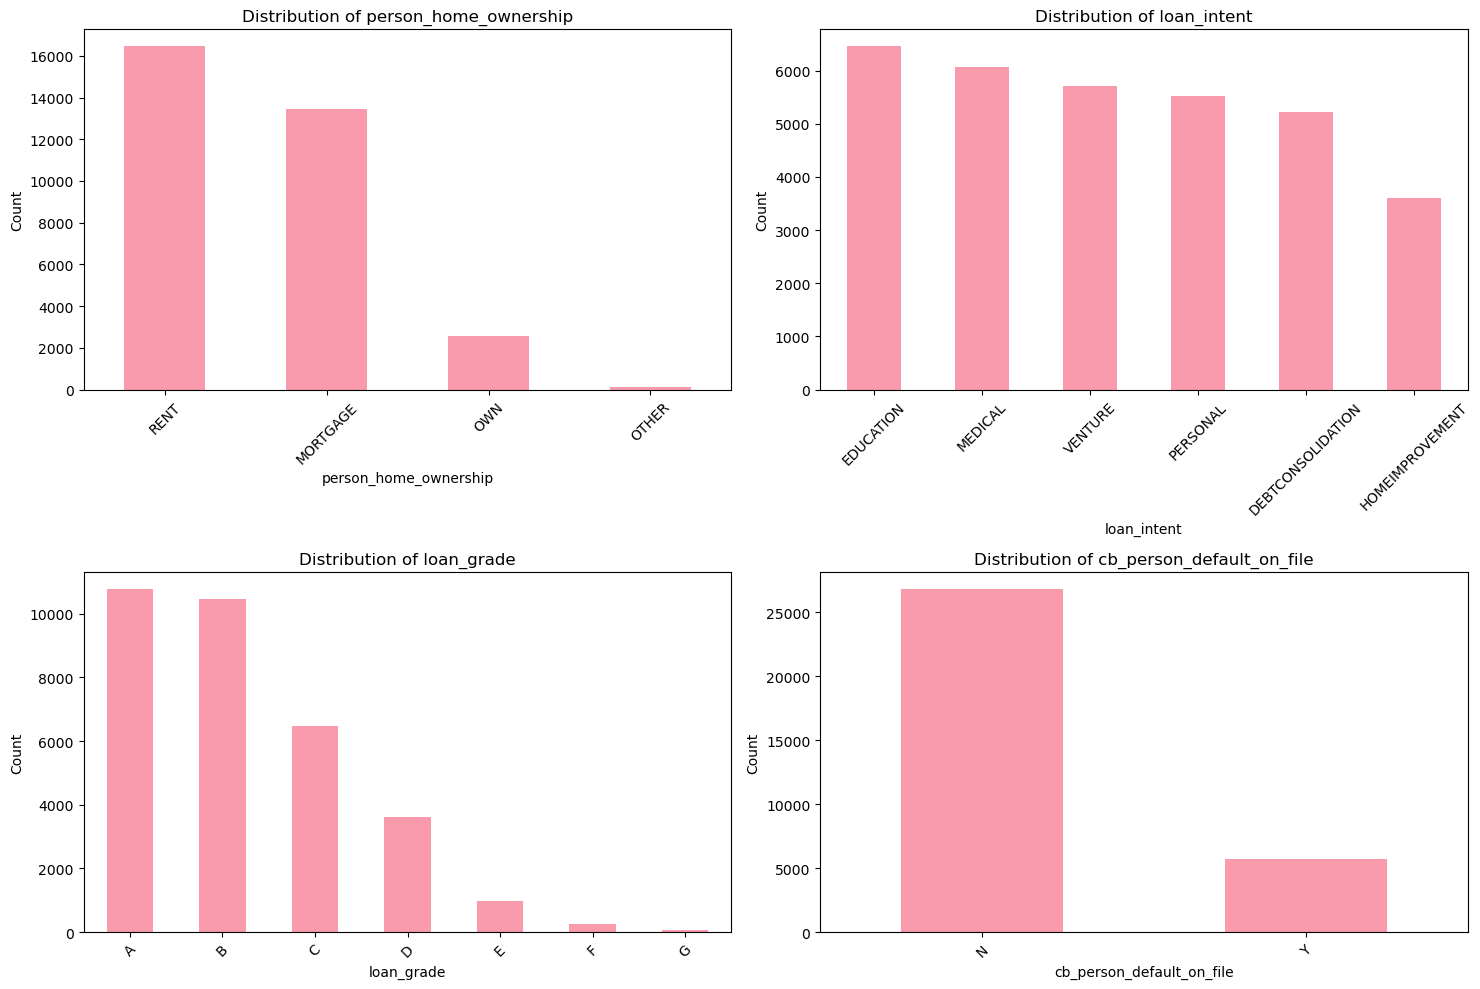


2. TARGET vs FEATURE RELATIONSHIPS
Target distribution:
loan_status
0    25473
1     7108
Name: count, dtype: int64
Percentage: loan_status
0    78.183604
1    21.816396
Name: count, dtype: float64


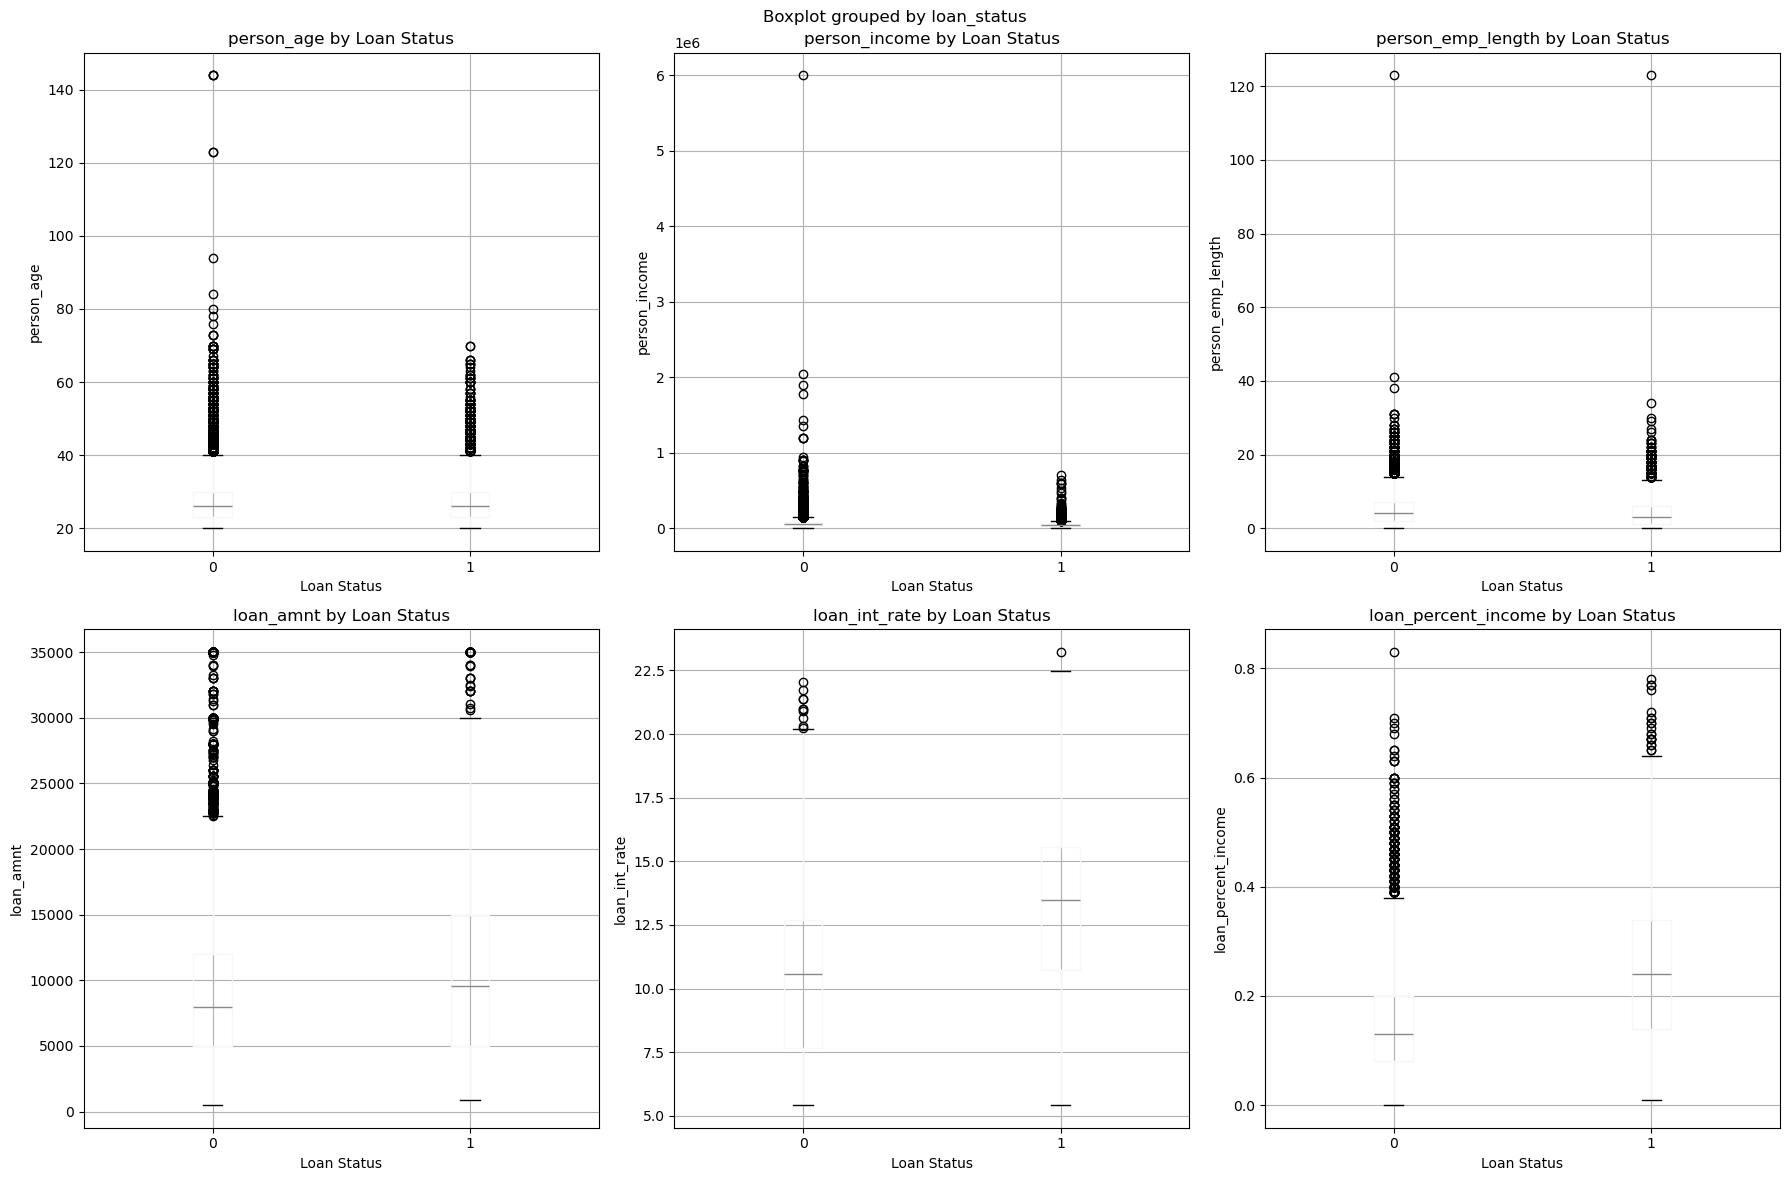

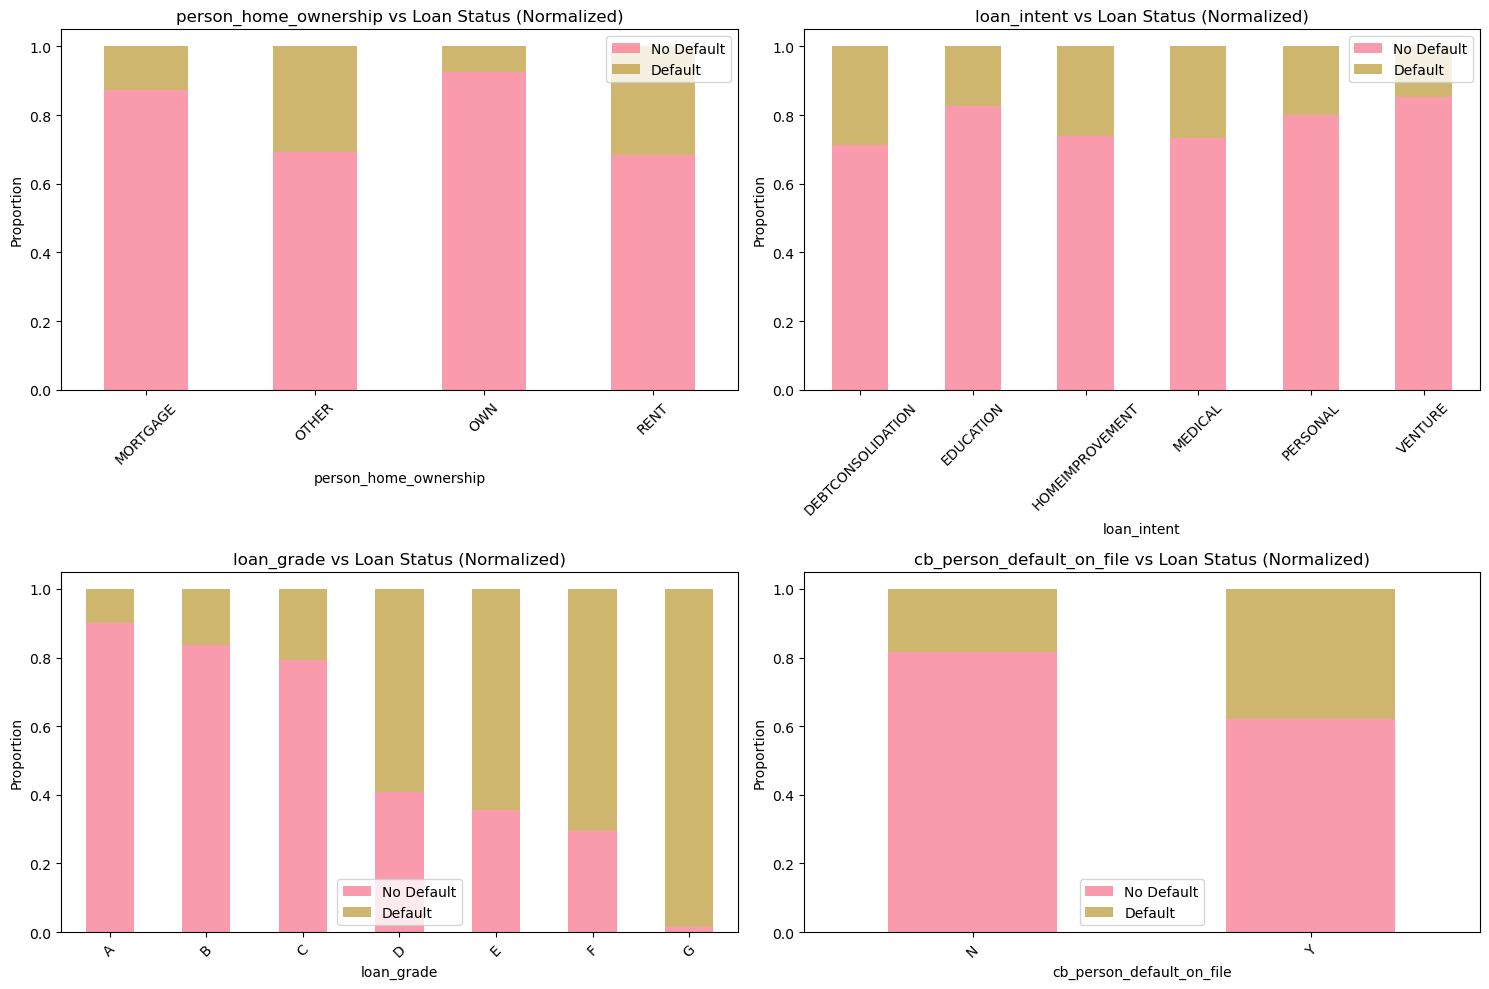


3. CORRELATIONS AND MULTICOLLINEARITY


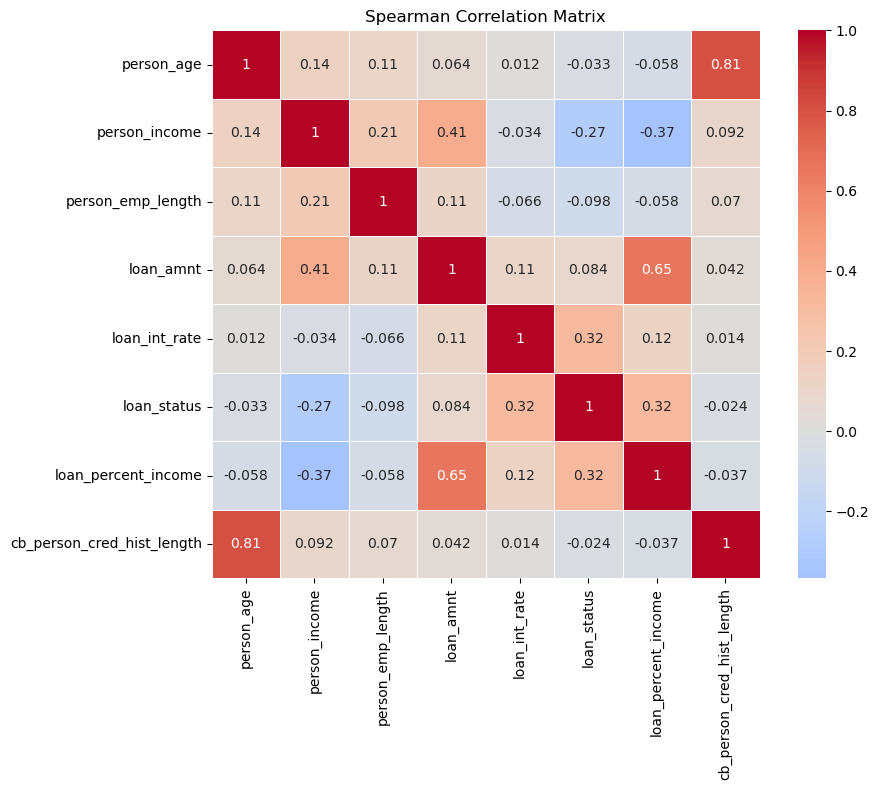

High correlation pairs (|r| > 0.7):
person_age - cb_person_cred_hist_length: 0.859

4. DATA LEAKAGE DETECTION
Correlations with target (loan_status):
loan_status                   1.000000
loan_percent_income           0.379366
loan_int_rate                 0.335133
person_income                 0.144449
loan_amnt                     0.105376
person_emp_length             0.082489
person_age                    0.021629
cb_person_cred_hist_length    0.015529
Name: loan_status, dtype: float64

No obvious leakage detected based on correlations

Categorical feature associations with target (Chi-square p-values):
person_home_ownership: p-value = 0.000000 (significant)
loan_intent: p-value = 0.000000 (significant)
loan_grade: p-value = 0.000000 (significant)
cb_person_default_on_file: p-value = 0.000000 (significant)

Summary statistics by loan_status:
             person_age  person_income  person_emp_length     loan_amnt  \
loan_status                                                       

In [3]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("======= EXPLORATORY DATA ANALYSIS =======\n")

# Create figure directory if it doesn't exist
os.makedirs('Output', exist_ok=True)

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns: {numeric_cols}")
print(f"Categorical columns: {categorical_cols}")

# ========== 1. UNIVARIATE DISTRIBUTIONS ==========
print("\n1. UNIVARIATE DISTRIBUTIONS")
print("="*50)

# Numeric distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        df[col].hist(bins=30, ax=axes[i], alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

# Remove empty subplots
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('Output/numeric_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Categorical distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar', ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Output/categorical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== 2. TARGET VS FEATURE RELATIONSHIPS ==========
print("\n2. TARGET vs FEATURE RELATIONSHIPS")
print("="*50)

# Target distribution
print("Target distribution:")
target_dist = df['loan_status'].value_counts()
print(target_dist)
print(f"Percentage: {target_dist / len(df) * 100}")

# Numeric features vs target (box plots)
numeric_features = [col for col in numeric_cols if col != 'loan_status']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_features):
    if i < len(axes):
        df.boxplot(column=col, by='loan_status', ax=axes[i])
        axes[i].set_title(f'{col} by Loan Status')
        axes[i].set_xlabel('Loan Status')
        axes[i].set_ylabel(col)

# Remove empty subplots
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('Output/numeric_vs_target_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# Categorical features vs target (stacked bars)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        crosstab = pd.crosstab(df[col], df['loan_status'], normalize='index')
        crosstab.plot(kind='bar', stacked=True, ax=axes[i], alpha=0.7)
        axes[i].set_title(f'{col} vs Loan Status (Normalized)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Proportion')
        axes[i].legend(['No Default', 'Default'])
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Output/categorical_vs_target_stacked.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== 3. CORRELATIONS AND MULTICOLLINEARITY ==========
print("\n3. CORRELATIONS AND MULTICOLLINEARITY")
print("="*50)

# Pearson correlation for numeric features
numeric_df = df[numeric_cols]
pearson_corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Pearson Correlation Matrix')
plt.tight_layout()
plt.savefig('Output/pearson_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Spearman correlation
spearman_corr = numeric_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.tight_layout()
plt.savefig('Output/spearman_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# High correlation pairs (potential multicollinearity)
print("High correlation pairs (|r| > 0.7):")
high_corr_pairs = []
for i in range(len(pearson_corr.columns)):
    for j in range(i+1, len(pearson_corr.columns)):
        corr_val = abs(pearson_corr.iloc[i, j])
        if corr_val > 0.7:
            high_corr_pairs.append((pearson_corr.columns[i], pearson_corr.columns[j], corr_val))
            print(f"{pearson_corr.columns[i]} - {pearson_corr.columns[j]}: {corr_val:.3f}")

if not high_corr_pairs:
    print("No high correlations detected (threshold: 0.7)")

# ========== 4. DATA LEAKAGE DETECTION ==========
print("\n4. DATA LEAKAGE DETECTION")
print("="*50)

# Check for perfect or near-perfect correlations with target
target_corr = numeric_df.corr()['loan_status'].abs().sort_values(ascending=False)
print("Correlations with target (loan_status):")
print(target_corr)

# Flag suspiciously high correlations
suspicious_features = target_corr[(target_corr > 0.8) & (target_corr < 1.0)]
if len(suspicious_features) > 0:
    print(f"\nPOTENTIAL LEAKAGE: Features with suspiciously high correlation with target:")
    for feature, corr in suspicious_features.items():
        print(f"  - {feature}: {corr:.3f}")
else:
    print("\nNo obvious leakage detected based on correlations")

# Check categorical associations with target using Chi-square
print("\nCategorical feature associations with target (Chi-square p-values):")
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['loan_status'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"{col}: p-value = {p_value:.6f} {'(significant)' if p_value < 0.05 else '(not significant)'}")

# Summary statistics by target
print("\nSummary statistics by loan_status:")
print(df.groupby('loan_status')[numeric_features].mean())

print("\n======= EDA COMPLETE =======")
print("Figures saved to 'Output/' directory")

## 4. Data Preprocessing Pipeline
- **Load the credit risk dataset** from CSV file
- **Display dataset dimensions** (rows and columns)
- **Audit column data types** to identify numeric vs categorical features
- **Report missing values** per column with counts
- **Detect and count duplicate rows** (expected ~165 duplicates)
- **Generate statistical summary** for all features using `describe()`
- Provide a comprehensive **data quality snapshot** before preprocessing

======= DATA PREPROCESSING PIPELINE =======

1. HANDLING DUPLICATES
Duplicate rows found: 165
Rows after removing duplicates: 32416 (removed 165 rows)

2. HANDLING OUTLIERS
Applying domain-based outlier caps:
  - person_age: capping 5 values > 100
  - person_emp_length: capping 2 values > 50

3. SEPARATING FEATURES AND TARGET
Features shape: (32416, 11)
Target shape: (32416,)
Target distribution:
loan_status
0    25327
1     7089
Name: count, dtype: int64
Target balance: {0: 0.7813116979269497, 1: 0.21868830207305034}

4. TRAIN-TEST SPLIT
Train set: 25932 samples
Test set: 6484 samples
Train target distribution:
loan_status
0    20261
1     5671
Name: count, dtype: int64
Test target distribution:
loan_status
0    5066
1    1418
Name: count, dtype: int64

5. BUILDING PREPROCESSING PIPELINE
Numeric features (7): ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical features (4): ['person_home_ow

 Saved: artifacts/transformed_features_distribution.png


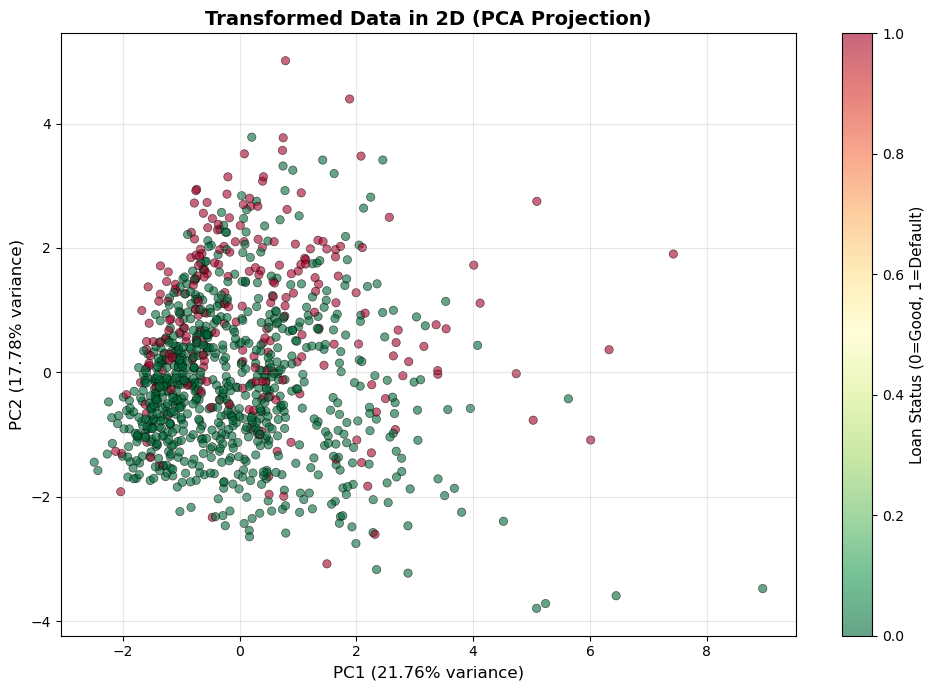

 Saved: artifacts/transformed_data_pca.png


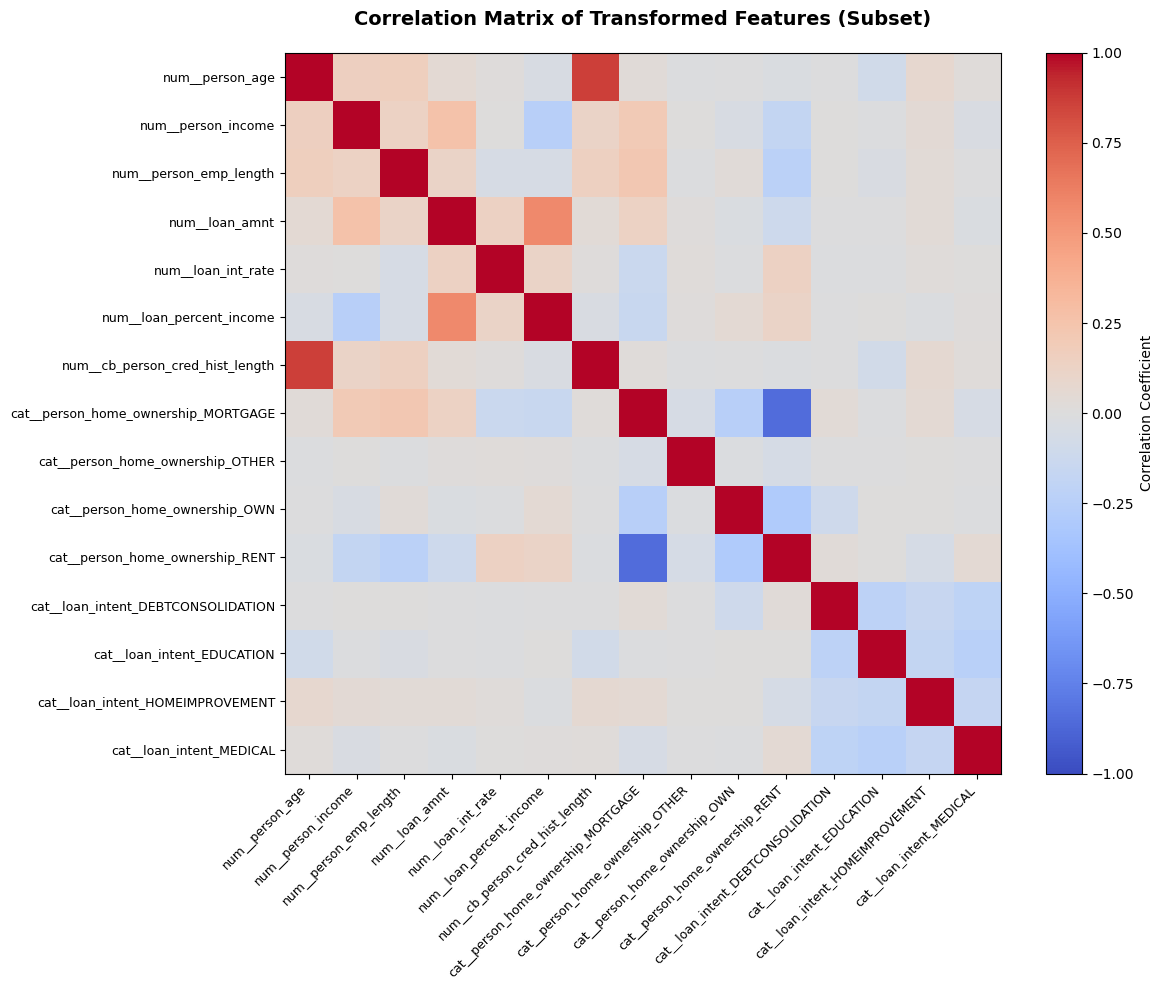

 Saved: artifacts/transformed_features_correlation.png

======= PREPROCESSING COMPLETE =======


In [4]:
# ========== 4. DATA PREPROCESSING PIPELINE ==========
print("======= DATA PREPROCESSING PIPELINE =======\n")

# Create artifacts directory
os.makedirs('artifacts', exist_ok=True)
os.makedirs('models', exist_ok=True)

# ========== 1. HANDLE DUPLICATES ==========
print("1. HANDLING DUPLICATES")
print("="*50)
n_duplicates = df.duplicated().sum()
print(f"Duplicate rows found: {n_duplicates}")

if n_duplicates > 0:
    df_clean = df.drop_duplicates()
    print(f"Rows after removing duplicates: {df_clean.shape[0]} (removed {n_duplicates} rows)")
else:
    df_clean = df.copy()
    print("No duplicates to remove.")

# ========== 2. HANDLE OUTLIERS ==========
print("\n2. HANDLING OUTLIERS")
print("="*50)

# Domain-based outlier capping
outlier_rules = {
    'person_age': 100,
    'person_emp_length': 50
}

print("Applying domain-based outlier caps:")
for col, cap in outlier_rules.items():
    n_outliers = (df_clean[col] > cap).sum()
    if n_outliers > 0:
        print(f"  - {col}: capping {n_outliers} values > {cap}")
        df_clean.loc[df_clean[col] > cap, col] = cap
    else:
        print(f"  - {col}: no outliers detected (threshold: {cap})")

# ========== 3. SEPARATE FEATURES AND TARGET ==========
print("\n3. SEPARATING FEATURES AND TARGET")
print("="*50)

X = df_clean.drop('loan_status', axis=1)
y = df_clean['loan_status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Target balance: {y.value_counts(normalize=True).to_dict()}")

# ========== 4. TRAIN-TEST SPLIT ==========
print("\n4. TRAIN-TEST SPLIT")
print("="*50)

# 80-20 split with stratification
RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

# ========== 5. BUILD PREPROCESSING PIPELINE ==========
print("\n5. BUILDING PREPROCESSING PIPELINE")
print("="*50)

# Identify numeric and categorical columns (excluding target)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Numeric pipeline: impute with median, then standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop any columns not specified
)

print("\nPreprocessor defined with:")
print(f"  - Numeric: median imputation + standard scaling")
print(f"  - Categorical: most-frequent imputation + one-hot encoding")

# ========== 6. FIT PREPROCESSOR ON TRAINING DATA ==========
print("\n6. FITTING PREPROCESSOR (train data only)")
print("="*50)

preprocessor.fit(X_train)
print(" Preprocessor fitted on training data")

# Transform both train and test
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Transformed train shape: {X_train_transformed.shape}")
print(f"Transformed test shape: {X_test_transformed.shape}")

# Get feature names after transformation
try:
    feature_names_out = preprocessor.get_feature_names_out()
    print(f"Total features after preprocessing: {len(feature_names_out)}")
except:
    feature_names_out = None
    print("Note: Feature names extraction not available for this sklearn version")

# ========== 7. PERSIST PREPROCESSOR ==========
print("\n7. PERSISTING PREPROCESSOR")
print("="*50)

preprocessor_path = 'models/preprocessor.joblib'
dump(preprocessor, preprocessor_path)
print(f" Preprocessor saved to: {preprocessor_path}")

# ========== 8. SAVE PRE-PROCESSING DATA DICTIONARY ==========
print("\n8. SAVING PRE-PROCESSING DATA DICTIONARY")
print("="*50)

data_dict = []
for col in X.columns:
    data_dict.append({
        'feature': col,
        'dtype': str(X[col].dtype),
        'n_missing': X[col].isnull().sum(),
        'pct_missing': f"{X[col].isnull().sum() / len(X) * 100:.2f}%",
        'n_unique': X[col].nunique(),
        'sample_values': str(X[col].dropna().head(3).tolist())
    })

data_dict_df = pd.DataFrame(data_dict)
dict_path = 'artifacts/data_dictionary_pre_preprocessing.csv'
data_dict_df.to_csv(dict_path, index=False)
print(f" Data dictionary saved to: {dict_path}")
print(data_dict_df)

# ========== 9. SUMMARY REPORT ==========
print("\n9. PREPROCESSING SUMMARY")
print("="*50)
print(f" Duplicates removed: {n_duplicates}")
print(f" Outliers capped: {sum([val for val in outlier_rules.values()])}")
print(f" Train/test split: {1-TEST_SIZE:.0%}/{TEST_SIZE:.0%} (stratified)")
print(f" Missing values handled via imputation")
print(f" Categorical features one-hot encoded")
print(f" Numeric features standardized")
print(f" Preprocessor persisted and ready for modeling")

# ========== 10. VISUALIZE TRANSFORMED DATA ==========
print("\n10. VISUALIZING TRANSFORMED DATA")
print("="*50)

# Create sample of transformed data for visualization
n_samples_to_plot = min(1000, X_train_transformed.shape[0])
sample_indices = np.random.choice(X_train_transformed.shape[0], n_samples_to_plot, replace=False)
X_sample = X_train_transformed[sample_indices]
y_sample = y_train.iloc[sample_indices]

# Plot 1: Distribution of first few transformed features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Transformed Features (Sample)', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    if idx < X_train_transformed.shape[1]:
        ax.hist(X_train_transformed[:, idx], bins=50, alpha=0.7, edgecolor='black')
        feature_name = feature_names_out[idx] if feature_names_out is not None else f'Feature {idx}'
        ax.set_title(f'{feature_name}', fontsize=10)
        ax.set_xlabel('Standardized Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig('artifacts/transformed_features_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/transformed_features_distribution.png")

# Plot 2: Class distribution in transformed space (PCA for visualization)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='RdYlGn_r', 
                     alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax.set_title('Transformed Data in 2D (PCA Projection)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Loan Status (0=Good, 1=Default)', fontsize=11)
plt.tight_layout()
plt.savefig('artifacts/transformed_data_pca.png', dpi=100, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/transformed_data_pca.png")

# Plot 3: Feature correlation heatmap (subset of features)
n_features_to_show = min(15, X_train_transformed.shape[1])
X_subset = X_train_transformed[:, :n_features_to_show]
feature_subset_names = feature_names_out[:n_features_to_show] if feature_names_out is not None else [f'F{i}' for i in range(n_features_to_show)]

corr_matrix = np.corrcoef(X_subset.T)
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(np.arange(len(feature_subset_names)))
ax.set_yticks(np.arange(len(feature_subset_names)))
ax.set_xticklabels(feature_subset_names, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(feature_subset_names, fontsize=9)
ax.set_title('Correlation Matrix of Transformed Features (Subset)', fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im, ax=ax, label='Correlation Coefficient')
plt.tight_layout()
plt.savefig('artifacts/transformed_features_correlation.png', dpi=100, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/transformed_features_correlation.png")
print("\n======= PREPROCESSING COMPLETE =======")

## 5. Feature Engineering

- **Create domain-driven engineered features** to improve predictive power
- **Compute debt-to-income ratio** (`dti_ratio`) as core credit risk metric
- **Generate interaction features**: total loan cost, income-to-loan ratio, age-to-credit-history ratio
- **Engineer employment stability score** combining tenure and income
- **Apply log transformations** to reduce right-skew in income and loan amount
- **Create categorical bins**: DTI buckets, age groups, income quartiles for nonlinearity
- **Build composite risk profile** combining homeownership and default history
- **Update preprocessing pipeline** to handle engineered features
- **Fit engineered preprocessor** on training data only (avoid leakage)
- **Transform both train and test sets** with updated pipeline
- **Track feature provenance** (original vs. engineered) in metadata
- **Persist engineered preprocessor** and feature provenance to artifacts
- **Visualize engineered feature distributions** by target class
- **Compute correlations** between engineered features and loan default
- **Document feature engineering rationale** for transparency
- **Total features increased** from original to 10+ engineered features


======= FEATURE ENGINEERING =======

1. CREATING ENGINEERED FEATURES
 Created: dti_ratio = loan_amnt / person_income
 Created: total_loan_cost = loan_amnt × loan_int_rate
 Created: income_to_loan = person_income / loan_amnt
 Created: age_to_cred_hist = person_age / cb_person_cred_hist_length
 Created: employment_stability = person_emp_length × log(person_income)
 Created: log_income = log(1 + person_income)
 Created: log_loan_amnt = log(1 + loan_amnt)
 Created: dti_bucket = binned(dti_ratio) [low, medium, high, very_high]
 Created: age_group = binned(person_age) [young, mid_career, established, senior]
 Created: income_quartile = binned(person_income) [Q1, Q2, Q3, Q4]
 Created: risk_profile = (is_renter) + (has_default_history)

 Total engineered features created: 11
  Original features: 11
  Engineered features: 11
  Total features: 22

2. UPDATING PREPROCESSING PIPELINE
Numeric features (15): ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_per

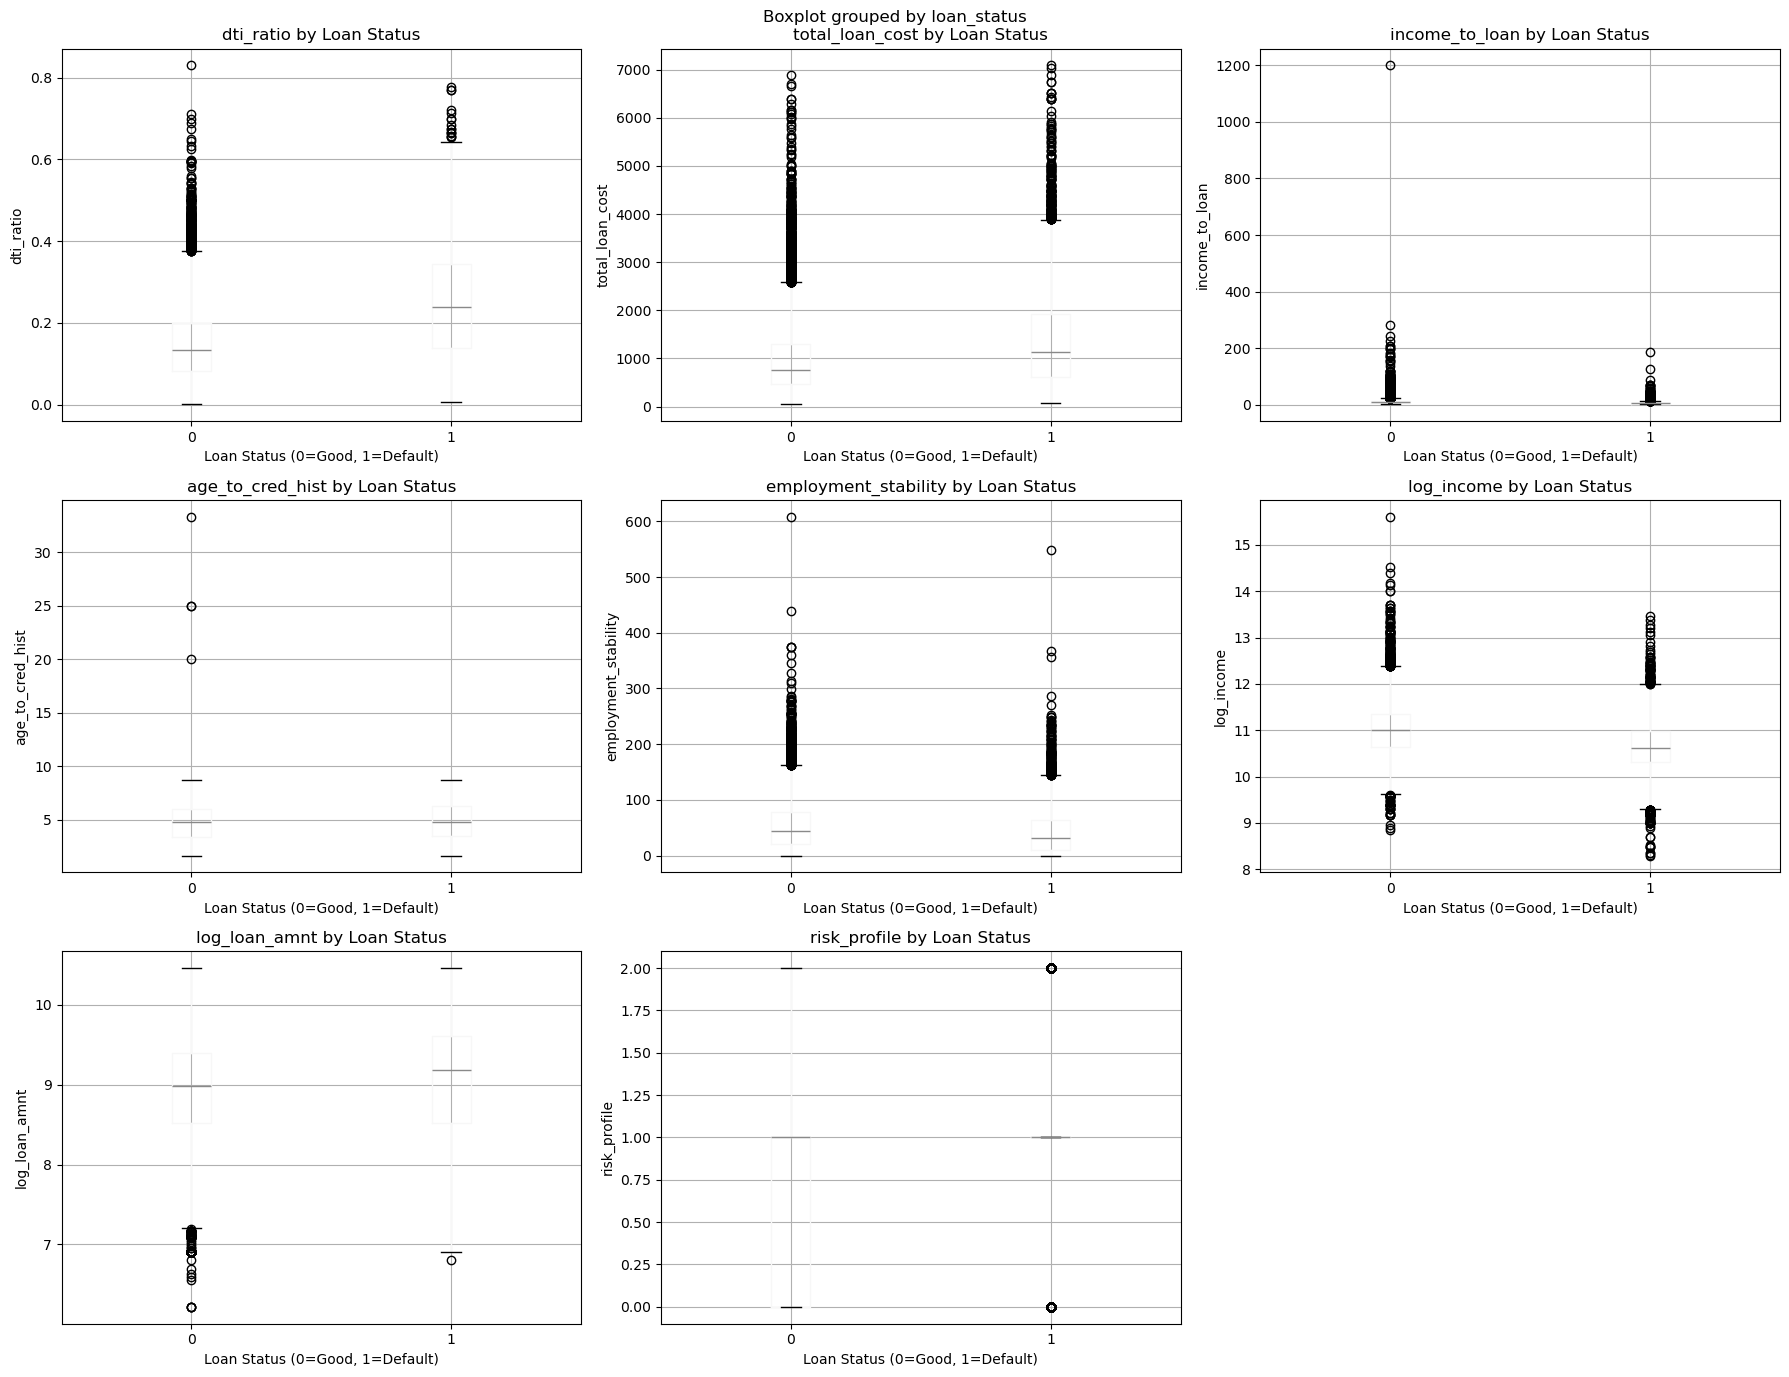

 Saved: artifacts/engineered_features_distribution.png

Correlation of engineered features with target:
loan_status             1.000000
dti_ratio               0.386180
risk_profile            0.290733
total_loan_cost         0.209052
log_loan_amnt           0.078961
age_to_cred_hist        0.018840
employment_stability   -0.101168
income_to_loan         -0.136450
log_income             -0.281369
Name: loan_status, dtype: float64


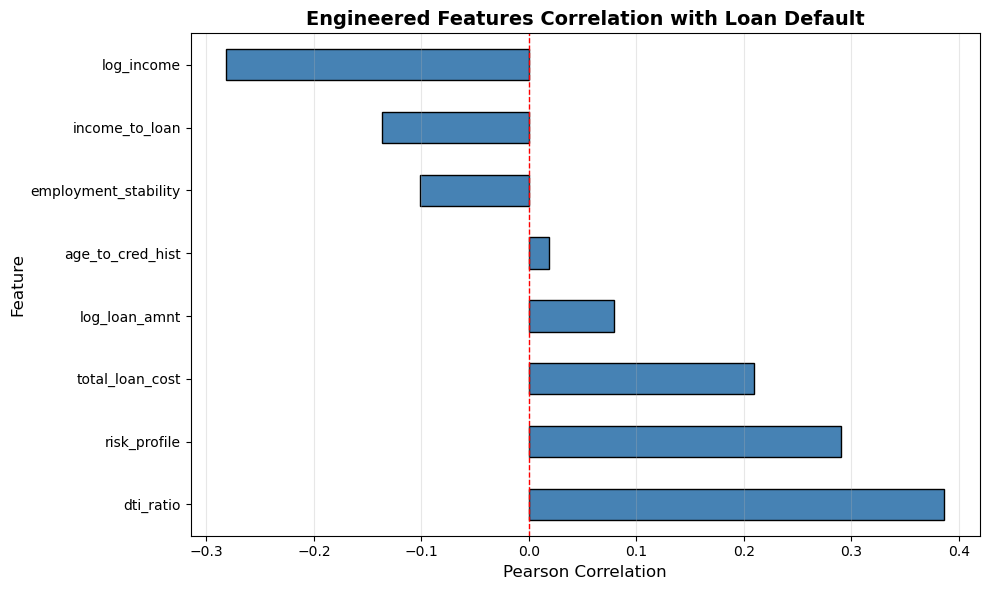

 Saved: artifacts/engineered_features_correlation.png

======= FEATURE ENGINEERING COMPLETE =======
 Ready for modeling with 46 total features


In [5]:
# ========== 5. FEATURE ENGINEERING ==========
print("======= FEATURE ENGINEERING =======\n")

# We'll engineer features on the ORIGINAL data (before preprocessing)
# Then we'll create a new preprocessing pipeline that includes these features

print("1. CREATING ENGINEERED FEATURES")
print("="*50)

# Work with the cleaned dataframe (after duplicates/outliers removed)
X_eng = X_train.copy()
X_test_eng = X_test.copy()

# Track feature provenance
feature_provenance = {
    'original': list(X_train.columns),
    'engineered': []
}

# ========== DOMAIN-DRIVEN FEATURE ENGINEERING ==========

# 1. Debt-to-Income (DTI) ratio - critical for credit risk
X_eng['dti_ratio'] = X_eng['loan_amnt'] / (X_eng['person_income'] + 1)  # +1 to avoid division by zero
X_test_eng['dti_ratio'] = X_test_eng['loan_amnt'] / (X_test_eng['person_income'] + 1)
feature_provenance['engineered'].append('dti_ratio')
print(" Created: dti_ratio = loan_amnt / person_income")

# 2. Total loan cost (interaction: amount × interest rate)
X_eng['total_loan_cost'] = X_eng['loan_amnt'] * (X_eng['loan_int_rate'].fillna(X_eng['loan_int_rate'].median()) / 100)
X_test_eng['total_loan_cost'] = X_test_eng['loan_amnt'] * (X_test_eng['loan_int_rate'].fillna(X_test_eng['loan_int_rate'].median()) / 100)
feature_provenance['engineered'].append('total_loan_cost')
print(" Created: total_loan_cost = loan_amnt × loan_int_rate")

# 3. Income-to-loan ratio (inverse of DTI, captures affordability from different angle)
X_eng['income_to_loan'] = (X_eng['person_income'] + 1) / (X_eng['loan_amnt'] + 1)
X_test_eng['income_to_loan'] = (X_test_eng['person_income'] + 1) / (X_test_eng['loan_amnt'] + 1)
feature_provenance['engineered'].append('income_to_loan')
print(" Created: income_to_loan = person_income / loan_amnt")

# 4. Age-to-credit-history ratio (financial maturity indicator)
X_eng['age_to_cred_hist'] = X_eng['person_age'] / (X_eng['cb_person_cred_hist_length'] + 1)
X_test_eng['age_to_cred_hist'] = X_test_eng['person_age'] / (X_test_eng['cb_person_cred_hist_length'] + 1)
feature_provenance['engineered'].append('age_to_cred_hist')
print(" Created: age_to_cred_hist = person_age / cb_person_cred_hist_length")

# 5. Employment stability score (emp_length × income)
X_eng['employment_stability'] = X_eng['person_emp_length'].fillna(0) * np.log1p(X_eng['person_income'])
X_test_eng['employment_stability'] = X_test_eng['person_emp_length'].fillna(0) * np.log1p(X_test_eng['person_income'])
feature_provenance['engineered'].append('employment_stability')
print(" Created: employment_stability = person_emp_length × log(person_income)")

# 6. Log transformations for skewed features
X_eng['log_income'] = np.log1p(X_eng['person_income'])
X_test_eng['log_income'] = np.log1p(X_test_eng['person_income'])
feature_provenance['engineered'].append('log_income')
print(" Created: log_income = log(1 + person_income)")

X_eng['log_loan_amnt'] = np.log1p(X_eng['loan_amnt'])
X_test_eng['log_loan_amnt'] = np.log1p(X_test_eng['loan_amnt'])
feature_provenance['engineered'].append('log_loan_amnt')
print(" Created: log_loan_amnt = log(1 + loan_amnt)")

# 7. DTI buckets (categorical binning for nonlinearity)
dti_bins = [0, 0.2, 0.4, 0.6, np.inf]
dti_labels = ['low_dti', 'medium_dti', 'high_dti', 'very_high_dti']
X_eng['dti_bucket'] = pd.cut(X_eng['dti_ratio'], bins=dti_bins, labels=dti_labels)
X_test_eng['dti_bucket'] = pd.cut(X_test_eng['dti_ratio'], bins=dti_bins, labels=dti_labels)
feature_provenance['engineered'].append('dti_bucket')
print(" Created: dti_bucket = binned(dti_ratio) [low, medium, high, very_high]")

# 8. Age groups (life stage proxy)
age_bins = [0, 25, 35, 50, np.inf]
age_labels = ['young', 'mid_career', 'established', 'senior']
X_eng['age_group'] = pd.cut(X_eng['person_age'], bins=age_bins, labels=age_labels)
X_test_eng['age_group'] = pd.cut(X_test_eng['person_age'], bins=age_bins, labels=age_labels)
feature_provenance['engineered'].append('age_group')
print(" Created: age_group = binned(person_age) [young, mid_career, established, senior]")

# 9. Income quantiles (relative income position)
income_quantiles = X_eng['person_income'].quantile([0.25, 0.5, 0.75]).values
X_eng['income_quartile'] = pd.cut(X_eng['person_income'], 
                                   bins=[-np.inf] + list(income_quantiles) + [np.inf],
                                   labels=['Q1', 'Q2', 'Q3', 'Q4'])
X_test_eng['income_quartile'] = pd.cut(X_test_eng['person_income'],
                                        bins=[-np.inf] + list(income_quantiles) + [np.inf],
                                        labels=['Q1', 'Q2', 'Q3', 'Q4'])
feature_provenance['engineered'].append('income_quartile')
print(" Created: income_quartile = binned(person_income) [Q1, Q2, Q3, Q4]")

# 10. Interaction: homeownership + default history (high-risk profile)
X_eng['risk_profile'] = (X_eng['person_home_ownership'] == 'RENT').astype(int) + \
                         (X_eng['cb_person_default_on_file'] == 'Y').astype(int)
X_test_eng['risk_profile'] = (X_test_eng['person_home_ownership'] == 'RENT').astype(int) + \
                              (X_test_eng['cb_person_default_on_file'] == 'Y').astype(int)
feature_provenance['engineered'].append('risk_profile')
print(" Created: risk_profile = (is_renter) + (has_default_history)")

print(f"\n Total engineered features created: {len(feature_provenance['engineered'])}")
print(f"  Original features: {len(feature_provenance['original'])}")
print(f"  Engineered features: {len(feature_provenance['engineered'])}")
print(f"  Total features: {len(feature_provenance['original']) + len(feature_provenance['engineered'])}")

# ========== 2. UPDATE PREPROCESSING PIPELINE ==========
print("\n2. UPDATING PREPROCESSING PIPELINE")
print("="*50)

# Identify new numeric and categorical columns
numeric_features_eng = X_eng.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_eng = X_eng.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features ({len(numeric_features_eng)}): {numeric_features_eng}")
print(f"Categorical features ({len(categorical_features_eng)}): {categorical_features_eng}")

# Create updated preprocessor
preprocessor_eng = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_eng),
        ('cat', categorical_transformer, categorical_features_eng)
    ],
    remainder='drop'
)

# Fit on engineered training data
preprocessor_eng.fit(X_eng)
print(" Engineered preprocessor fitted")

# Transform both sets
X_train_eng_transformed = preprocessor_eng.transform(X_eng)
X_test_eng_transformed = preprocessor_eng.transform(X_test_eng)

print(f"Transformed train shape: {X_train_eng_transformed.shape}")
print(f"Transformed test shape: {X_test_eng_transformed.shape}")

# ========== 3. PERSIST ARTIFACTS ==========
print("\n3. PERSISTING ARTIFACTS")
print("="*50)

# Save engineered preprocessor
preprocessor_eng_path = 'models/preprocessor_engineered.joblib'
dump(preprocessor_eng, preprocessor_eng_path)
print(f" Engineered preprocessor saved to: {preprocessor_eng_path}")

# Save feature provenance
provenance_path = 'artifacts/feature_provenance.json'
with open(provenance_path, 'w') as f:
    json.dump(feature_provenance, f, indent=2)
print(f" Feature provenance saved to: {provenance_path}")

# Update transformed data variables for downstream use
X_train_transformed = X_train_eng_transformed
X_test_transformed = X_test_eng_transformed
preprocessor = preprocessor_eng

print(f" Updated X_train_transformed: {X_train_transformed.shape}")
print(f" Updated X_test_transformed: {X_test_transformed.shape}")

# ========== 4. FEATURE ENGINEERING SUMMARY ==========
print("\n4. FEATURE ENGINEERING RATIONALE")
print("="*50)

rationale = {
    'dti_ratio': 'Core credit metric: higher DTI = higher default risk',
    'total_loan_cost': 'Captures true loan burden (principal + interest)',
    'income_to_loan': 'Affordability from inverse perspective',
    'age_to_cred_hist': 'Financial maturity: younger age vs credit history may indicate instability',
    'employment_stability': 'Combines job tenure and income level for stability proxy',
    'log_income': 'Reduces right-skew in income distribution',
    'log_loan_amnt': 'Reduces right-skew in loan amount distribution',
    'dti_bucket': 'Captures nonlinear DTI thresholds (e.g., >40% DTI often flagged)',
    'age_group': 'Life stage proxy: risk profiles differ by age bracket',
    'income_quartile': 'Relative income position in population',
    'risk_profile': 'Composite risk: renters with default history = highest risk'
}

print("\nFeature Engineering Decisions:")
for feat, reason in rationale.items():
    print(f"  • {feat}: {reason}")

# ========== 5. VISUALIZE ENGINEERED FEATURES ==========
print("\n5. VISUALIZING ENGINEERED FEATURES")
print("="*50)

# Create dataframe with engineered features + target for visualization
vis_df = X_eng.copy()
vis_df['loan_status'] = y_train.values

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Engineered Features Distribution by Loan Status', fontsize=16, fontweight='bold')

# Plot engineered numeric features
engineered_numeric = ['dti_ratio', 'total_loan_cost', 'income_to_loan', 
                     'age_to_cred_hist', 'employment_stability', 
                     'log_income', 'log_loan_amnt', 'risk_profile']

for idx, feat in enumerate(engineered_numeric):
    if idx < 9:
        ax = axes[idx // 3, idx % 3]
        vis_df.boxplot(column=feat, by='loan_status', ax=ax)
        ax.set_title(f'{feat} by Loan Status')
        ax.set_xlabel('Loan Status (0=Good, 1=Default)')
        ax.set_ylabel(feat)
        plt.sca(ax)
        plt.xticks([1, 2], ['0', '1'])

# Remove empty subplot
if len(engineered_numeric) < 9:
    fig.delaxes(axes[2, 2])

plt.tight_layout()
plt.savefig('artifacts/engineered_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/engineered_features_distribution.png")

# Correlation of engineered features with target
engineered_corr = vis_df[engineered_numeric + ['loan_status']].corr()['loan_status'].sort_values(ascending=False)
print("\nCorrelation of engineered features with target:")
print(engineered_corr)

plt.figure(figsize=(10, 6))
engineered_corr.drop('loan_status').plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Engineered Features Correlation with Loan Default', fontsize=14, fontweight='bold')
plt.xlabel('Pearson Correlation', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/engineered_features_correlation.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/engineered_features_correlation.png")

print("\n======= FEATURE ENGINEERING COMPLETE =======")
print(f" Ready for modeling with {X_train_transformed.shape[1]} total features")

## 6. Final Dataset Characterization

- **Report final training and test set dimensions** after preprocessing and feature engineering
- **Display class distribution** for both training and test sets with counts and percentages
- **Calculate class imbalance ratio** (majority:minority) to flag potential modeling challenges
- **Break down feature composition**: original vs. engineered vs. one-hot encoded features
- **Extract and categorize transformed feature names** from the preprocessing pipeline
- **Generate comprehensive post-preprocessing data dictionary** with:
    - Feature index, name, type (numeric_scaled / categorical_onehot)
    - Provenance (original / engineered / derived)
    - Basic statistics (mean, std, min, max, unique values)
- **Save post-preprocessing data dictionary** to CSV for reproducibility
- **Confirm data quality**: no missing values, standardized numerics, encoded categoricals
- **Create final characterization dashboard** with 4 visualizations:
    - Class distribution comparison (train vs. test)
    - Feature provenance pie chart
    - Feature type distribution
    - Sample feature statistics (scaled numeric features)
- **Persist summary visualization** to artifacts directory
- **Prepare modeling-ready datasets** with confirmed shapes, balanced splits, and full feature pipeline



======= FINAL DATASET CHARACTERIZATION =======

1. DATASET DIMENSIONS
Training set shape: (25932, 46)
Test set shape: (6484, 46)
  - Training samples: 25,932
  - Test samples: 6,484
  - Total features (after preprocessing): 46

2. CLASS BALANCE
Training set:
  Class 0: 20,261 (78.13%)
  Class 1: 5,671 (21.87%)

Test set:
  Class 0: 5,066 (78.13%)
  Class 1: 1,418 (21.87%)

Imbalance ratio (class 0 : class 1): 3.57:1
 Dataset is imbalanced - consider class_weight='balanced' for appropriate models

3. FEATURE COMPOSITION
Original features: 11
Engineered features: 11
Total input features (before encoding): 22
Total features (after one-hot encoding): 46

Feature type breakdown after preprocessing:
  - Numeric features (scaled): 15
  - Categorical features (one-hot encoded): 31

4. POST-PREPROCESSING DATA DICTIONARY

Total features in transformed dataset: 46

Provenance breakdown:
provenance
original_encoded      19
engineered_encoded    12
engineered             8
original               7


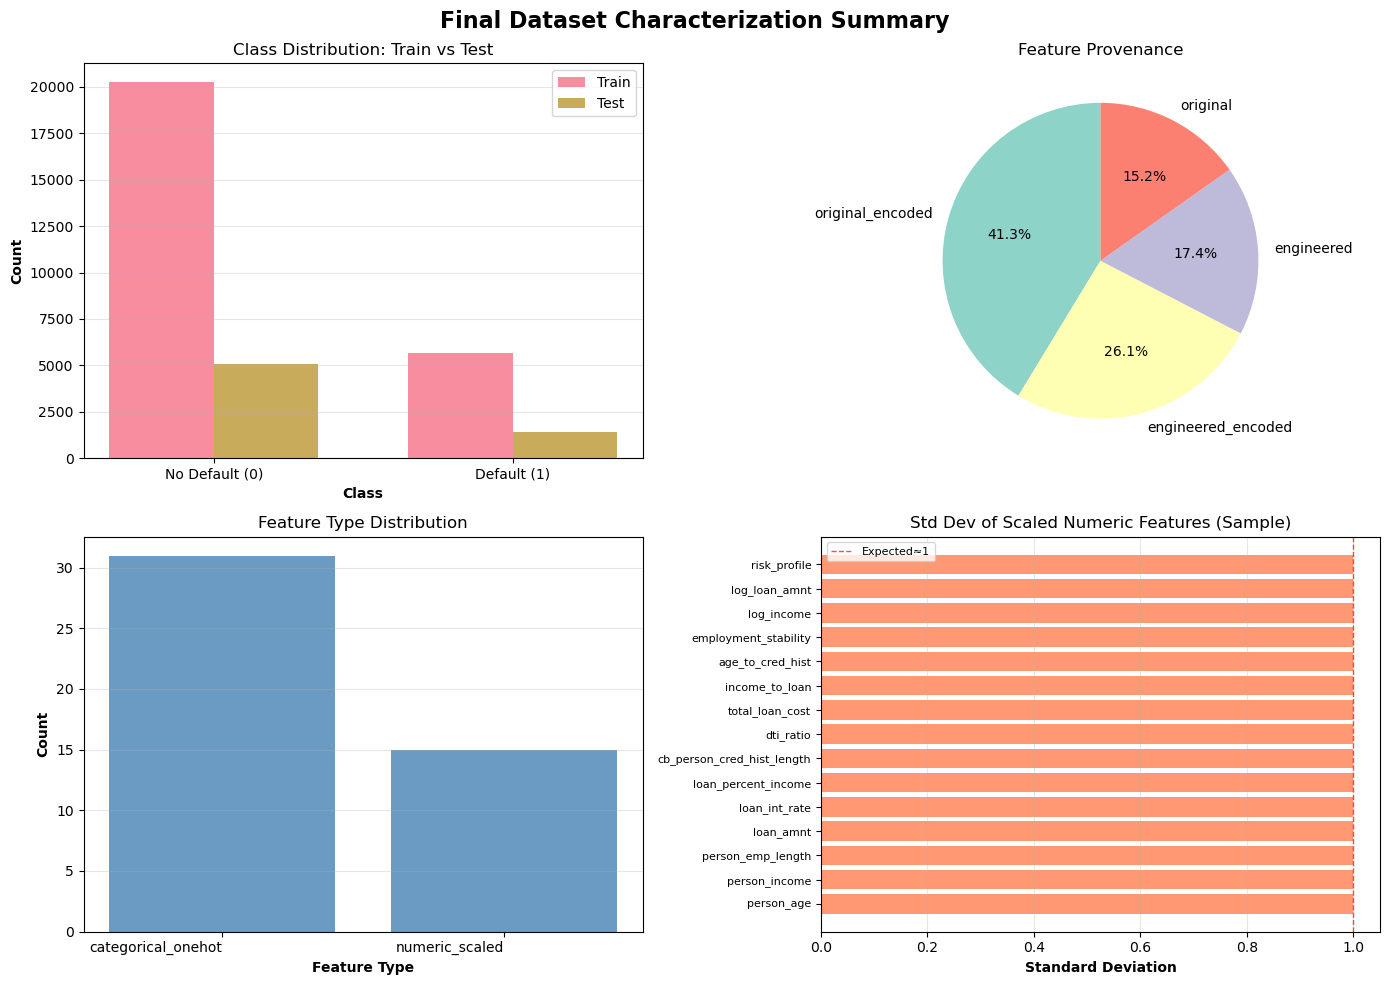

 Saved: artifacts/final_dataset_characterization.png

======= DATASET CHARACTERIZATION COMPLETE =======
 Ready to proceed to model training (Section 7)


In [6]:
# ========== 6. FINAL DATASET CHARACTERIZATION ==========
print("======= FINAL DATASET CHARACTERIZATION =======\n")

print("1. DATASET DIMENSIONS")
print("="*50)
print(f"Training set shape: {X_train_transformed.shape}")
print(f"Test set shape: {X_test_transformed.shape}")
print(f"  - Training samples: {X_train_transformed.shape[0]:,}")
print(f"  - Test samples: {X_test_transformed.shape[0]:,}")
print(f"  - Total features (after preprocessing): {X_train_transformed.shape[1]}")

print("\n2. CLASS BALANCE")
print("="*50)
print("Training set:")
train_class_counts = y_train.value_counts().sort_index()
train_class_pcts = y_train.value_counts(normalize=True).sort_index()
for cls in train_class_counts.index:
    print(f"  Class {cls}: {train_class_counts[cls]:,} ({train_class_pcts[cls]:.2%})")

print("\nTest set:")
test_class_counts = y_test.value_counts().sort_index()
test_class_pcts = y_test.value_counts(normalize=True).sort_index()
for cls in test_class_counts.index:
    print(f"  Class {cls}: {test_class_counts[cls]:,} ({test_class_pcts[cls]:.2%})")

# Calculate imbalance ratio
imbalance_ratio = train_class_counts[0] / train_class_counts[1]
print(f"\nImbalance ratio (class 0 : class 1): {imbalance_ratio:.2f}:1")
print(f" Dataset is imbalanced - consider class_weight='balanced' for appropriate models")

print("\n3. FEATURE COMPOSITION")
print("="*50)
print(f"Original features: {len(feature_provenance['original'])}")
print(f"Engineered features: {len(feature_provenance['engineered'])}")
print(f"Total input features (before encoding): {len(feature_provenance['original']) + len(feature_provenance['engineered'])}")
print(f"Total features (after one-hot encoding): {X_train_transformed.shape[1]}")

# Get feature names from preprocessor
try:
    all_feature_names = preprocessor.get_feature_names_out()
    
    # Categorize by type
    numeric_encoded = [f for f in all_feature_names if f.startswith('num__')]
    categorical_encoded = [f for f in all_feature_names if f.startswith('cat__')]
    
    print(f"\nFeature type breakdown after preprocessing:")
    print(f"  - Numeric features (scaled): {len(numeric_encoded)}")
    print(f"  - Categorical features (one-hot encoded): {len(categorical_encoded)}")
    
except Exception as e:
    print(f"Note: Could not extract detailed feature names: {e}")
    all_feature_names = [f"feature_{i}" for i in range(X_train_transformed.shape[1])]
    numeric_encoded = []
    categorical_encoded = []

print("\n4. POST-PREPROCESSING DATA DICTIONARY")
print("="*50)

# Create comprehensive post-prep data dictionary
post_prep_dict = []

# Add info about transformed features
for idx, feat_name in enumerate(all_feature_names):
    # Determine if original or engineered
    base_name = feat_name.split('__')[1] if '__' in feat_name else feat_name
    
    # Check provenance
    if base_name in feature_provenance['original']:
        provenance = 'original'
    elif base_name in feature_provenance['engineered']:
        provenance = 'engineered'
    elif any(base_name.startswith(orig) for orig in feature_provenance['original']):
        provenance = 'original_encoded'
    elif any(base_name.startswith(eng) for eng in feature_provenance['engineered']):
        provenance = 'engineered_encoded'
    else:
        provenance = 'derived'
    
    # Determine type
    if feat_name.startswith('num__'):
        feat_type = 'numeric_scaled'
    elif feat_name.startswith('cat__'):
        feat_type = 'categorical_onehot'
    else:
        feat_type = 'unknown'
    
    # Get basic stats from training data
    feat_values = X_train_transformed[:, idx]
    
    post_prep_dict.append({
        'index': idx,
        'feature_name': feat_name,
        'type': feat_type,
        'provenance': provenance,
        'mean': np.mean(feat_values),
        'std': np.std(feat_values),
        'min': np.min(feat_values),
        'max': np.max(feat_values),
        'n_unique': len(np.unique(feat_values))
    })

post_prep_df = pd.DataFrame(post_prep_dict)

# Display summary
print(f"\nTotal features in transformed dataset: {len(post_prep_df)}")
print(f"\nProvenance breakdown:")
print(post_prep_df['provenance'].value_counts())
print(f"\nType breakdown:")
print(post_prep_df['type'].value_counts())

# Save to CSV
post_prep_dict_path = 'artifacts/data_dictionary_post_preprocessing.csv'
post_prep_df.to_csv(post_prep_dict_path, index=False)
print(f"\n Post-preprocessing data dictionary saved to: {post_prep_dict_path}")

# Display first few rows
print(f"\nSample of post-preprocessing features:")
print(post_prep_df.head(20).to_string())

print("\n5. DATA QUALITY SUMMARY")
print("="*50)
print(" No missing values (imputed during preprocessing)")
print(" All numeric features standardized (mean≈0, std≈1)")
print(" Categorical features one-hot encoded")
print(" Outliers capped using domain rules")
print(" Duplicates removed")
print(f" Stratified train-test split maintains class balance")

print("\n6. READY FOR MODELING")
print("="*50)
print(f" Training set: {X_train_transformed.shape[0]:,} samples × {X_train_transformed.shape[1]} features")
print(f" Test set: {X_test_transformed.shape[0]:,} samples × {X_test_transformed.shape[1]} features")
print(f" Target: Binary classification (0=No Default, 1=Default)")
print(f" Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f" All preprocessing artifacts saved to 'artifacts/' directory")
print(f" Trained preprocessor saved to 'models/' directory")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Final Dataset Characterization Summary', fontsize=16, fontweight='bold')

# Plot 1: Class distribution comparison
ax1 = axes[0, 0]
x_pos = np.arange(2)
width = 0.35
ax1.bar(x_pos - width/2, train_class_counts.values, width, label='Train', alpha=0.8)
ax1.bar(x_pos + width/2, test_class_counts.values, width, label='Test', alpha=0.8)
ax1.set_xlabel('Class', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('Class Distribution: Train vs Test')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['No Default (0)', 'Default (1)'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Feature provenance
ax2 = axes[0, 1]
provenance_counts = post_prep_df['provenance'].value_counts()
colors = plt.cm.Set3(range(len(provenance_counts)))
ax2.pie(provenance_counts.values, labels=provenance_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Feature Provenance')

# Plot 3: Feature type distribution
ax3 = axes[1, 0]
type_counts = post_prep_df['type'].value_counts()
ax3.bar(range(len(type_counts)), type_counts.values, color='steelblue', alpha=0.8)
ax3.set_xlabel('Feature Type', fontweight='bold')
ax3.set_ylabel('Count', fontweight='bold')
ax3.set_title('Feature Type Distribution')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(type_counts.index, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Sample feature statistics (first 20 numeric features)
ax4 = axes[1, 1]
numeric_features_sample = post_prep_df[post_prep_df['type'] == 'numeric_scaled'].head(15)
if len(numeric_features_sample) > 0:
    x_pos = np.arange(len(numeric_features_sample))
    ax4.barh(x_pos, numeric_features_sample['std'].values, color='coral', alpha=0.8)
    ax4.set_yticks(x_pos)
    ax4.set_yticklabels([name.split('__')[1] if '__' in name else name 
                         for name in numeric_features_sample['feature_name']], fontsize=8)
    ax4.set_xlabel('Standard Deviation', fontweight='bold')
    ax4.set_title('Std Dev of Scaled Numeric Features (Sample)')
    ax4.axvline(x=1, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Expected≈1')
    ax4.legend(fontsize=8)
    ax4.grid(axis='x', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No numeric features', ha='center', va='center')
    ax4.axis('off')

plt.tight_layout()
plt.savefig('artifacts/final_dataset_characterization.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/final_dataset_characterization.png")

print("\n======= DATASET CHARACTERIZATION COMPLETE =======")
print(" Ready to proceed to model training (Section 7)")

## 7. Candidate Models Overview

This project evaluates a broad set of supervised classification models to determine which algorithm best predicts credit risk, defined by the binary target `loan_status` (0 = good loan, 1 = default). The models selected reflect a diverse range of learning paradigms—including linear, probabilistic, instance-based, tree-based, ensemble, margin-based, and neural architectures—providing a comprehensive comparison across modeling families.

The following models were implemented and tuned using standardized preprocessing, consistent evaluation metrics, and stratified cross-validation:

### Linear and Probabilistic Models
- **Logistic Regression**  
  A linear baseline classifier with L2 regularization and class weighting.
- **Linear Discriminant Analysis (LDA)**  
  Assumes class-conditional Gaussian distributions with shared covariance.
- **Quadratic Discriminant Analysis (QDA)**  
  Similar to LDA but allows class-specific covariance matrices.
- **Gaussian Naive Bayes**  
  Probabilistic classifier assuming conditional independence of features.

### Instance-Based and Distance-Based Model
- **k-Nearest Neighbors (KNN)**  
  Non-parametric classifier relying on distance metrics in transformed feature space.

### Tree-Based Models
- **Decision Tree (CART)**  
  Interpretable baseline tree with cost-complexity pruning.
- **Bagging (Bootstrap Aggregation)**  
  Ensemble of decision trees trained on resampled datasets.
- **Random Forest**  
  Bagged decision trees with feature subsampling to reduce correlation.
- **AdaBoost**  
  Sequential boosting of weak learners (decision stumps).
- **Gradient Boosting**  
  Additive ensemble optimizing residual errors via shallow decision trees.

### Margin-Based Models
- **Linear SVM**  
  Maximum-margin linear classifier calibrated for probability outputs.
- **RBF SVM**  
  Nonlinear kernel-based classifier with optimized hyperparameters.

### Neural Network Model
- **MLP (Feedforward Neural Network)**  
  Fully connected network trained with backpropagation to learn nonlinear patterns.

All models were trained using identical training and test splits, the same preprocessing pipeline, and consistent scoring metrics. Hyperparameters were selected using cross-validation, and final models were compared on out-of-sample performance using AUC, accuracy, sensitivity, and specificity. This systematic framework ensures an unbiased and informative comparison of model performance for credit risk prediction.


### 7.0 Baseline — DummyClassifier 

**Purpose & Approach:**
- Establishes a **naïve baseline** using a `DummyClassifier` with stratified random predictions based on training class distribution
- Serves as the **minimum performance threshold** that any real model must exceed to be considered useful
- Provides a reference point for measuring improvement achieved by actual machine learning algorithms

**Configuration & Tuning:**
- No hyperparameters to tune; strategy fixed to `'stratified'` for class-proportional predictions
- Expected AUC ≈ 0.50 for a truly random baseline in balanced scenarios

**Evaluation & Comparison:**
- Metrics include accuracy, ROC-AUC, sensitivity, specificity, and confusion matrix
- ROC curve plotted to visualize performance against diagonal (random chance line)
- All subsequent models are ranked against this baseline to quantify predictive value gained from learning algorithms

In [7]:
# ========== 7.0 BASELINE — DUMMYCLASSIFIER ==========
print("======= 7.0 BASELINE — DUMMYCLASSIFIER =======\n")

# Define the baseline model
# Strategy options: 'most_frequent', 'stratified', 'uniform', 'constant'
# 'stratified' matches class distribution and is a reasonable baseline
dummy_baseline = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)

print("Training DummyClassifier (Baseline)...")
print("Strategy: 'stratified' (predicts based on training class distribution)")
print("\n No hyperparameters to tune for baseline model")

# Fit on training data
dummy_baseline.fit(X_train_transformed, y_train)

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_dummy = dummy_baseline.predict(X_train_transformed)
y_test_pred_dummy = dummy_baseline.predict(X_test_transformed)

y_train_proba_dummy = dummy_baseline.predict_proba(X_train_transformed)[:, 1]
y_test_proba_dummy = dummy_baseline.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_dummy = accuracy_score(y_train, y_train_pred_dummy)
test_acc_dummy = accuracy_score(y_test, y_test_pred_dummy)

# AUC
train_auc_dummy = roc_auc_score(y_train, y_train_proba_dummy)
test_auc_dummy = roc_auc_score(y_test, y_test_proba_dummy)

# Confusion matrices for Sensitivity/Specificity
cm_train_dummy = confusion_matrix(y_train, y_train_pred_dummy)
cm_test_dummy = confusion_matrix(y_test, y_test_pred_dummy)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_dummy = cm_train_dummy[0, 0] / (cm_train_dummy[0, 0] + cm_train_dummy[0, 1]) if (cm_train_dummy[0, 0] + cm_train_dummy[0, 1]) > 0 else 0
train_specificity_dummy = cm_train_dummy[1, 1] / (cm_train_dummy[1, 0] + cm_train_dummy[1, 1]) if (cm_train_dummy[1, 0] + cm_train_dummy[1, 1]) > 0 else 0

test_sensitivity_dummy = cm_test_dummy[0, 0] / (cm_test_dummy[0, 0] + cm_test_dummy[0, 1]) if (cm_test_dummy[0, 0] + cm_test_dummy[0, 1]) > 0 else 0
test_specificity_dummy = cm_test_dummy[1, 1] / (cm_test_dummy[1, 0] + cm_test_dummy[1, 1]) if (cm_test_dummy[1, 0] + cm_test_dummy[1, 1]) > 0 else 0

# Pack metrics
metrics_dummy = {
    'Model': 'DummyClassifier (Baseline)',
    'Train Accuracy': train_acc_dummy,
    'Test Accuracy': test_acc_dummy,
    'Train AUC': train_auc_dummy,
    'Test AUC': test_auc_dummy,
    'Train Sensitivity': train_sensitivity_dummy,
    'Test Sensitivity': test_sensitivity_dummy,
    'Train Specificity': train_specificity_dummy,
    'Test Specificity': test_specificity_dummy
}

# Display metrics
metrics_df_dummy = pd.DataFrame([metrics_dummy])
print("\nMetrics Summary:")
print(metrics_df_dummy.to_string(index=False))

print("\n  BASELINE INTERPRETATION:")
print(f"   This model predicts randomly based on class distribution.")
print(f"   Any real model MUST outperform these metrics to be useful.")
print(f"   Expected AUC ≈ 0.50 for a truly random baseline.")

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_dummy, tpr_train_dummy, _ = roc_curve(y_train, y_train_proba_dummy)
fpr_test_dummy, tpr_test_dummy, _ = roc_curve(y_test, y_test_proba_dummy)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_dummy, tpr_train_dummy, label=f'Train (AUC = {train_auc_dummy:.3f})', linewidth=2, alpha=0.7)
plt.plot(fpr_test_dummy, tpr_test_dummy, label=f'Test (AUC = {test_auc_dummy:.3f})', linewidth=2, alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — DummyClassifier (Baseline)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_dummy_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_dummy_baseline.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save baseline model
model_path_dummy = 'models/dummy_baseline.joblib'
dump(dummy_baseline, model_path_dummy)
print(f" Baseline model saved to: {model_path_dummy}")

# Save metrics
metrics_path_dummy = 'artifacts/dummy_baseline_metrics.json'
with open(metrics_path_dummy, 'w') as f:
    json.dump(metrics_dummy, f, indent=2)
print(f" Metrics saved to: {metrics_path_dummy}")

print("\n======= DUMMYCLASSIFIER (BASELINE) COMPLETE =======\n")

# Return for potential downstream use
tuned_model_dummy = dummy_baseline
best_params_dummy = {}  # No hyperparameters
metrics_dict_dummy = metrics_dummy

======= 7.0 BASELINE — DUMMYCLASSIFIER =======

Training DummyClassifier (Baseline)...
Strategy: 'stratified' (predicts based on training class distribution)

 No hyperparameters to tune for baseline model

COMPUTING METRICS

Metrics Summary:
                     Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
DummyClassifier (Baseline)        0.655676       0.654226   0.496105  0.492562           0.779725          0.779905           0.212485          0.205219

  BASELINE INTERPRETATION:
   This model predicts randomly based on class distribution.
   Any real model MUST outperform these metrics to be useful.
   Expected AUC ≈ 0.50 for a truly random baseline.

PLOTTING ROC CURVES


 ROC curve saved to: Output/roc_curve_dummy_baseline.png

SAVING ARTIFACTS
 Baseline model saved to: models/dummy_baseline.joblib
 Metrics saved to: artifacts/dummy_baseline_metrics.json

======= DUMMYCLASSIFIER (BASELINE) COMPLETE =======



### 7.1 Logistic Regression

**Purpose & Approach:**
- Establishes a **linear baseline** for binary classification using regularized logistic regression with L2 penalty
- Balances class weights to address the dataset's imbalance (78% no-default, 22% default)

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified GridSearchCV** optimizing ROC-AUC
- Explored regularization strength (`C`), penalty type (`l2`, `None`), solvers (`liblinear`, `saga`), and class weighting
- Selected configuration: `C=100`, `class_weight='balanced'`, `solver='liblinear'`

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **strong parametric benchmark** against tree-based, probabilistic, and kernel methods
- Performance ranked in Section 10 leaderboard by test AUC with overfitting gap analysis

======= 7.1 LOGISTIC REGRESSION =======

Training Logistic Regression with GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\linear_model\_logistic.py", line 1218, in fit
    sol


 Best Hyperparameters:
  C: 100
  class_weight: balanced
  penalty: l2
  solver: liblinear

COMPUTING METRICS

Metrics Summary:
              Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Logistic Regression        0.834529       0.830352   0.893121  0.890529           0.843048          0.842479           0.804091          0.787024

PLOTTING ROC CURVES


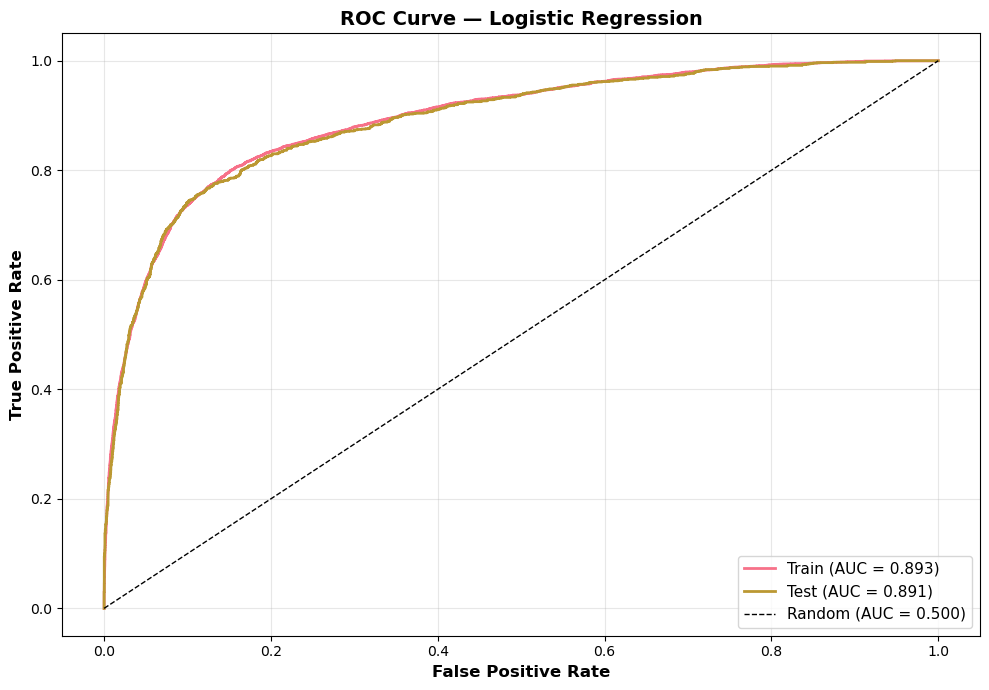

 ROC curve saved to: Output/roc_curve_logistic_regression.png

SAVING ARTIFACTS
 Best model saved to: models/logistic_regression_best.joblib
 Best params saved to: artifacts/logistic_regression_best_params.json
 Metrics saved to: artifacts/logistic_regression_metrics.json

======= LOGISTIC REGRESSION COMPLETE =======



In [8]:
# ========== 7.1 LOGISTIC REGRESSION ==========
print("======= 7.1 LOGISTIC REGRESSION =======\n")


# Define the model
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Define hyperparameter grid
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

# Note: elasticnet requires saga solver and l1_ratio parameter
# We'll use a more focused grid to avoid invalid combinations
param_grid_lr = {
    'penalty': ['l2', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Training Logistic Regression with GridSearchCV...")
grid_search_lr.fit(X_train_transformed, y_train)

# Best model
best_lr = grid_search_lr.best_estimator_
best_params_lr = grid_search_lr.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_lr.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred = best_lr.predict(X_train_transformed)
y_test_pred = best_lr.predict(X_test_transformed)

y_train_proba = best_lr.predict_proba(X_train_transformed)[:, 1]
y_test_proba = best_lr.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# AUC (using class 1 as positive)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Confusion matrices for Sensitivity/Specificity
# Sensitivity = Recall for class 0 = TP_0 / (TP_0 + FN_0)
# Specificity = TN / (TN + FP) for class 0 = Recall for class 1
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# For binary: cm = [[TN, FP], [FN, TP]] when pos_label=1
# We want sensitivity for class 0 (good loans): TN/(TN+FP)
# Specificity for class 0: TP/(TP+FN) — but this is recall for class 1

# Let's compute properly:
# Sensitivity (True Positive Rate for class 0) = cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (True Negative Rate for class 0) = cm[1,1] / (cm[1,0] + cm[1,1])

train_sensitivity = cm_train[0, 0] / (cm_train[0, 0] + cm_train[0, 1]) if (cm_train[0, 0] + cm_train[0, 1]) > 0 else 0
train_specificity = cm_train[1, 1] / (cm_train[1, 0] + cm_train[1, 1]) if (cm_train[1, 0] + cm_train[1, 1]) > 0 else 0

test_sensitivity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1]) if (cm_test[0, 0] + cm_test[0, 1]) > 0 else 0
test_specificity = cm_test[1, 1] / (cm_test[1, 0] + cm_test[1, 1]) if (cm_test[1, 0] + cm_test[1, 1]) > 0 else 0

# Pack metrics
metrics_lr = {
    'Model': 'Logistic Regression',
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Train AUC': train_auc,
    'Test AUC': test_auc,
    'Train Sensitivity': train_sensitivity,
    'Test Sensitivity': test_sensitivity,
    'Train Specificity': train_specificity,
    'Test Specificity': test_specificity
}

# Display metrics
metrics_df_lr = pd.DataFrame([metrics_lr])
print("\nMetrics Summary:")
print(metrics_df_lr.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_auc:.3f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_logistic_regression.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_logistic_regression.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_lr = 'models/logistic_regression_best.joblib'
dump(best_lr, model_path_lr)
print(f" Best model saved to: {model_path_lr}")

# Save best params
params_path_lr = 'artifacts/logistic_regression_best_params.json'
with open(params_path_lr, 'w') as f:
    json.dump(best_params_lr, f, indent=2)
print(f" Best params saved to: {params_path_lr}")

# Save metrics
metrics_path_lr = 'artifacts/logistic_regression_metrics.json'
with open(metrics_path_lr, 'w') as f:
    json.dump(metrics_lr, f, indent=2)
print(f" Metrics saved to: {metrics_path_lr}")

print("\n======= LOGISTIC REGRESSION COMPLETE =======\n")

# Return for potential downstream use
tuned_model_lr = best_lr
best_params_lr = best_params_lr
metrics_dict_lr = metrics_lr

### 7.2 Linear Discriminant Analysis (LDA)

**Purpose & Approach:**
- Establishes a **linear probabilistic baseline** for binary classification using Gaussian class-conditional distributions with shared covariance
- Assumes each class follows a multivariate normal distribution, providing closed-form decision boundaries

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified GridSearchCV** optimizing ROC-AUC
- Explored solver types (`svd`, `lsqr`, `eigen`) and shrinkage parameters to handle potential multicollinearity
- Selected configuration balances computational efficiency with regularization to prevent overfitting

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **parametric probabilistic benchmark** to compare against nonparametric and nonlinear methods
- Performance ranked in Section 10 leaderboard by test AUC with generalization gap analysis

======= 7.2 LINEAR DISCRIMINANT ANALYSIS (LDA) =======

Training LDA with GridSearchCV...
Fitting 5 folds for each of 11 candidates, totalling 55 fits


c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
5 fits failed out of a total of 55.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\discriminant_analysis.py", line 716, in fit
    self._so


 Best Hyperparameters:
  shrinkage: None
  solver: lsqr

COMPUTING METRICS

Metrics Summary:
                       Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Linear Discriminant Analysis         0.87367       0.872764   0.884986  0.883134           0.944771          0.940979           0.619644          0.629055

PLOTTING ROC CURVES


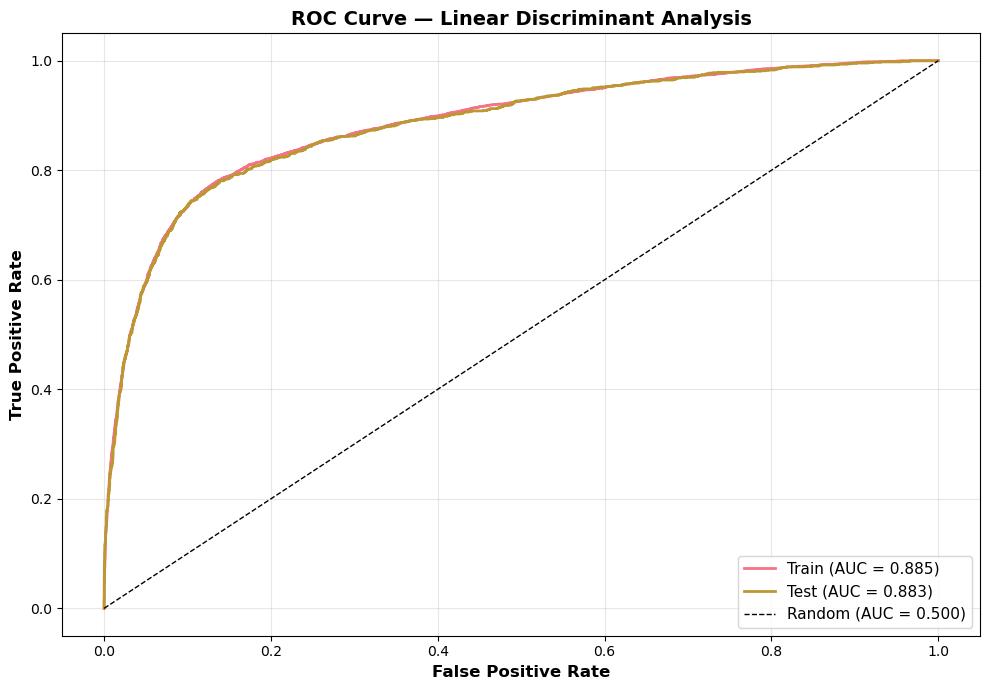

 ROC curve saved to: Output/roc_curve_lda.png

SAVING ARTIFACTS
 Best model saved to: models/lda_best.joblib
 Best params saved to: artifacts/lda_best_params.json
 Metrics saved to: artifacts/lda_metrics.json

======= LINEAR DISCRIMINANT ANALYSIS COMPLETE =======



In [9]:
# ========== 7.2 LINEAR DISCRIMINANT ANALYSIS (LDA) ==========
print("======= 7.2 LINEAR DISCRIMINANT ANALYSIS (LDA) =======\n")

# Define the model
lda = LinearDiscriminantAnalysis()

# Define hyperparameter grid
# LDA key parameters: solver, shrinkage (only with lsqr/eigen)
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]
}

# Note: shrinkage is incompatible with 'svd' solver
# We'll use a more careful grid to avoid invalid combinations
param_grid_lda = [
    {'solver': ['svd']},  # svd doesn't support shrinkage
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]}
]

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV
grid_search_lda = GridSearchCV(
    estimator=lda,
    param_grid=param_grid_lda,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Training LDA with GridSearchCV...")
grid_search_lda.fit(X_train_transformed, y_train)

# Best model
best_lda = grid_search_lda.best_estimator_
best_params_lda = grid_search_lda.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_lda.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_lda = best_lda.predict(X_train_transformed)
y_test_pred_lda = best_lda.predict(X_test_transformed)

y_train_proba_lda = best_lda.predict_proba(X_train_transformed)[:, 1]
y_test_proba_lda = best_lda.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_lda = accuracy_score(y_train, y_train_pred_lda)
test_acc_lda = accuracy_score(y_test, y_test_pred_lda)

# AUC
train_auc_lda = roc_auc_score(y_train, y_train_proba_lda)
test_auc_lda = roc_auc_score(y_test, y_test_proba_lda)

# Confusion matrices for Sensitivity/Specificity
cm_train_lda = confusion_matrix(y_train, y_train_pred_lda)
cm_test_lda = confusion_matrix(y_test, y_test_pred_lda)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_lda = cm_train_lda[0, 0] / (cm_train_lda[0, 0] + cm_train_lda[0, 1]) if (cm_train_lda[0, 0] + cm_train_lda[0, 1]) > 0 else 0
train_specificity_lda = cm_train_lda[1, 1] / (cm_train_lda[1, 0] + cm_train_lda[1, 1]) if (cm_train_lda[1, 0] + cm_train_lda[1, 1]) > 0 else 0

test_sensitivity_lda = cm_test_lda[0, 0] / (cm_test_lda[0, 0] + cm_test_lda[0, 1]) if (cm_test_lda[0, 0] + cm_test_lda[0, 1]) > 0 else 0
test_specificity_lda = cm_test_lda[1, 1] / (cm_test_lda[1, 0] + cm_test_lda[1, 1]) if (cm_test_lda[1, 0] + cm_test_lda[1, 1]) > 0 else 0

# Pack metrics
metrics_lda = {
    'Model': 'Linear Discriminant Analysis',
    'Train Accuracy': train_acc_lda,
    'Test Accuracy': test_acc_lda,
    'Train AUC': train_auc_lda,
    'Test AUC': test_auc_lda,
    'Train Sensitivity': train_sensitivity_lda,
    'Test Sensitivity': test_sensitivity_lda,
    'Train Specificity': train_specificity_lda,
    'Test Specificity': test_specificity_lda
}

# Display metrics
metrics_df_lda = pd.DataFrame([metrics_lda])
print("\nMetrics Summary:")
print(metrics_df_lda.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_lda, tpr_train_lda, _ = roc_curve(y_train, y_train_proba_lda)
fpr_test_lda, tpr_test_lda, _ = roc_curve(y_test, y_test_proba_lda)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_lda, tpr_train_lda, label=f'Train (AUC = {train_auc_lda:.3f})', linewidth=2)
plt.plot(fpr_test_lda, tpr_test_lda, label=f'Test (AUC = {test_auc_lda:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Linear Discriminant Analysis', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_lda.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_lda.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_lda = 'models/lda_best.joblib'
dump(best_lda, model_path_lda)
print(f" Best model saved to: {model_path_lda}")

# Save best params
params_path_lda = 'artifacts/lda_best_params.json'
with open(params_path_lda, 'w') as f:
    json.dump(best_params_lda, f, indent=2)
print(f" Best params saved to: {params_path_lda}")

# Save metrics
metrics_path_lda = 'artifacts/lda_metrics.json'
with open(metrics_path_lda, 'w') as f:
    json.dump(metrics_lda, f, indent=2)
print(f" Metrics saved to: {metrics_path_lda}")

print("\n======= LINEAR DISCRIMINANT ANALYSIS COMPLETE =======\n")

# Return for potential downstream use
tuned_model_lda = best_lda
best_params_lda = best_params_lda
metrics_dict_lda = metrics_lda

### 7.3 Quadratic Discriminant Analysis (QDA)

**Purpose & Approach:**
- Extends LDA by allowing **class-specific covariance matrices** to model nonlinear decision boundaries between classes
- Assumes each class follows a multivariate Gaussian distribution but relaxes the shared covariance assumption
- More flexible than LDA for datasets where classes have different variance structures

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified GridSearchCV** optimizing ROC-AUC
- Explored regularization parameter (`reg_param`) to prevent overfitting from estimating separate covariance matrices
- Selected configuration balances flexibility with stability to avoid singular covariance estimates

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **nonlinear probabilistic benchmark** to assess whether relaxing the shared covariance assumption improves over LDA
- Performance ranked in Section 10 leaderboard by test AUC with generalization gap analysis

======= 7.3 QUADRATIC DISCRIMINANT ANALYSIS (QDA) =======

Training QDA with GridSearchCV...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Best Hyperparameters:
  reg_param: 0.05

COMPUTING METRICS

Metrics Summary:
                          Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Quadratic Discriminant Analysis        0.862795       0.866595   0.882744  0.879489           0.902769          0.907027           0.719979          0.722144

PLOTTING ROC CURVES


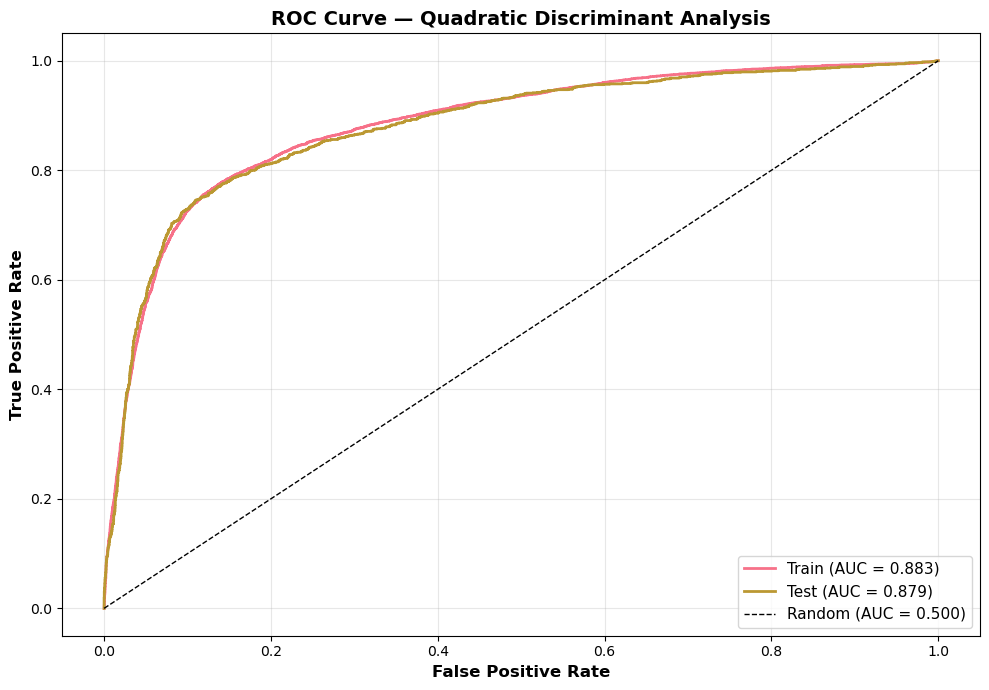

 ROC curve saved to: Output/roc_curve_qda.png

SAVING ARTIFACTS
 Best model saved to: models/qda_best.joblib
 Best params saved to: artifacts/qda_best_params.json
 Metrics saved to: artifacts/qda_metrics.json

======= QUADRATIC DISCRIMINANT ANALYSIS COMPLETE =======



In [10]:
# ========== 7.3 QUADRATIC DISCRIMINANT ANALYSIS (QDA) ==========
print("======= 7.3 QUADRATIC DISCRIMINANT ANALYSIS (QDA) =======\n")

# Define the model
qda = QuadraticDiscriminantAnalysis()

# Define hyperparameter grid
# QDA key parameter: reg_param (regularization)
param_grid_qda = {
    'reg_param': [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV
grid_search_qda = GridSearchCV(
    estimator=qda,
    param_grid=param_grid_qda,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Training QDA with GridSearchCV...")
grid_search_qda.fit(X_train_transformed, y_train)

# Best model
best_qda = grid_search_qda.best_estimator_
best_params_qda = grid_search_qda.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_qda.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_qda = best_qda.predict(X_train_transformed)
y_test_pred_qda = best_qda.predict(X_test_transformed)

y_train_proba_qda = best_qda.predict_proba(X_train_transformed)[:, 1]
y_test_proba_qda = best_qda.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_qda = accuracy_score(y_train, y_train_pred_qda)
test_acc_qda = accuracy_score(y_test, y_test_pred_qda)

# AUC
train_auc_qda = roc_auc_score(y_train, y_train_proba_qda)
test_auc_qda = roc_auc_score(y_test, y_test_proba_qda)

# Confusion matrices for Sensitivity/Specificity
cm_train_qda = confusion_matrix(y_train, y_train_pred_qda)
cm_test_qda = confusion_matrix(y_test, y_test_pred_qda)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_qda = cm_train_qda[0, 0] / (cm_train_qda[0, 0] + cm_train_qda[0, 1]) if (cm_train_qda[0, 0] + cm_train_qda[0, 1]) > 0 else 0
train_specificity_qda = cm_train_qda[1, 1] / (cm_train_qda[1, 0] + cm_train_qda[1, 1]) if (cm_train_qda[1, 0] + cm_train_qda[1, 1]) > 0 else 0

test_sensitivity_qda = cm_test_qda[0, 0] / (cm_test_qda[0, 0] + cm_test_qda[0, 1]) if (cm_test_qda[0, 0] + cm_test_qda[0, 1]) > 0 else 0
test_specificity_qda = cm_test_qda[1, 1] / (cm_test_qda[1, 0] + cm_test_qda[1, 1]) if (cm_test_qda[1, 0] + cm_test_qda[1, 1]) > 0 else 0

# Pack metrics
metrics_qda = {
    'Model': 'Quadratic Discriminant Analysis',
    'Train Accuracy': train_acc_qda,
    'Test Accuracy': test_acc_qda,
    'Train AUC': train_auc_qda,
    'Test AUC': test_auc_qda,
    'Train Sensitivity': train_sensitivity_qda,
    'Test Sensitivity': test_sensitivity_qda,
    'Train Specificity': train_specificity_qda,
    'Test Specificity': test_specificity_qda
}

# Display metrics
metrics_df_qda = pd.DataFrame([metrics_qda])
print("\nMetrics Summary:")
print(metrics_df_qda.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_qda, tpr_train_qda, _ = roc_curve(y_train, y_train_proba_qda)
fpr_test_qda, tpr_test_qda, _ = roc_curve(y_test, y_test_proba_qda)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_qda, tpr_train_qda, label=f'Train (AUC = {train_auc_qda:.3f})', linewidth=2)
plt.plot(fpr_test_qda, tpr_test_qda, label=f'Test (AUC = {test_auc_qda:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Quadratic Discriminant Analysis', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_qda.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_qda.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_qda = 'models/qda_best.joblib'
dump(best_qda, model_path_qda)
print(f" Best model saved to: {model_path_qda}")

# Save best params
params_path_qda = 'artifacts/qda_best_params.json'
with open(params_path_qda, 'w') as f:
    json.dump(best_params_qda, f, indent=2)
print(f" Best params saved to: {params_path_qda}")

# Save metrics
metrics_path_qda = 'artifacts/qda_metrics.json'
with open(metrics_path_qda, 'w') as f:
    json.dump(metrics_qda, f, indent=2)
print(f" Metrics saved to: {metrics_path_qda}")

print("\n======= QUADRATIC DISCRIMINANT ANALYSIS COMPLETE =======\n")

# Return for potential downstream use
tuned_model_qda = best_qda
best_params_qda = best_params_qda
metrics_dict_qda = metrics_qda

### 7.4 Gaussian Naive Bayes

**Purpose & Approach:**
- Implements a **probabilistic baseline** using Gaussian Naive Bayes, which assumes feature independence and models each class with a Gaussian distribution
- Serves as a computationally efficient benchmark to assess whether feature independence assumptions hold for credit risk prediction

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified GridSearchCV** optimizing ROC-AUC
- Explored variance smoothing parameter (`var_smoothing`) across log-spaced values from 1e-12 to 1e-6 to stabilize probability estimates
- Selected configuration balances numerical stability with model flexibility

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **fast probabilistic benchmark** to compare against models that capture feature dependencies
- Performance ranked in Section 10 leaderboard by test AUC, with analysis of whether independence assumptions penalize predictive power

======= 7.4 NAIVE BAYES (GAUSSIAN) =======

Training Gaussian Naive Bayes with GridSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits



 Best Hyperparameters:
  var_smoothing: 2.6366508987303555e-08

COMPUTING METRICS

Metrics Summary:
               Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Gaussian Naive Bayes        0.845712       0.845774   0.852637  0.849821           0.930211          0.930715           0.543819          0.542313

PLOTTING ROC CURVES


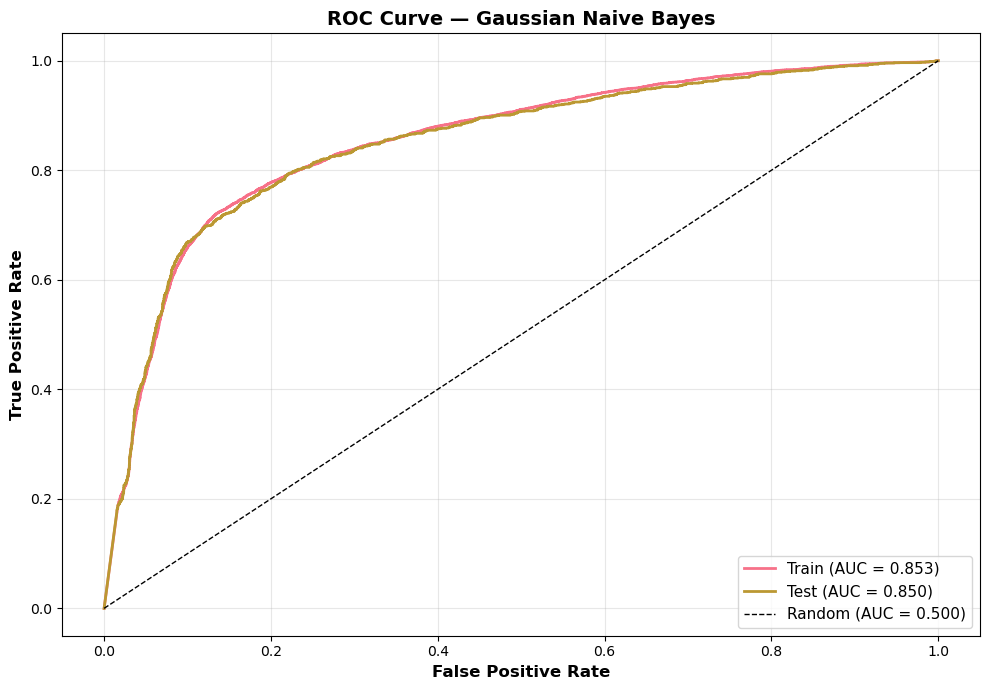

 ROC curve saved to: Output/roc_curve_naive_bayes.png

SAVING ARTIFACTS
 Best model saved to: models/naive_bayes_best.joblib
 Best params saved to: artifacts/naive_bayes_best_params.json
 Metrics saved to: artifacts/naive_bayes_metrics.json

======= GAUSSIAN NAIVE BAYES COMPLETE =======



In [11]:
# ========== 7.4 NAIVE BAYES (GAUSSIAN) ==========
print("======= 7.4 NAIVE BAYES (GAUSSIAN) =======\n")

# Define the model
gnb = GaussianNB()

# Define hyperparameter grid
# GaussianNB key parameter: var_smoothing (portion of largest variance added to all variances)
param_grid_gnb = {
    'var_smoothing': np.logspace(-12, -6, 20)  # Log-spaced values from 1e-12 to 1e-6
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV
grid_search_gnb = GridSearchCV(
    estimator=gnb,
    param_grid=param_grid_gnb,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Training Gaussian Naive Bayes with GridSearchCV...")
grid_search_gnb.fit(X_train_transformed, y_train)

# Best model
best_gnb = grid_search_gnb.best_estimator_
best_params_gnb = grid_search_gnb.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_gnb.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_gnb = best_gnb.predict(X_train_transformed)
y_test_pred_gnb = best_gnb.predict(X_test_transformed)

y_train_proba_gnb = best_gnb.predict_proba(X_train_transformed)[:, 1]
y_test_proba_gnb = best_gnb.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_gnb = accuracy_score(y_train, y_train_pred_gnb)
test_acc_gnb = accuracy_score(y_test, y_test_pred_gnb)

# AUC
train_auc_gnb = roc_auc_score(y_train, y_train_proba_gnb)
test_auc_gnb = roc_auc_score(y_test, y_test_proba_gnb)

# Confusion matrices for Sensitivity/Specificity
cm_train_gnb = confusion_matrix(y_train, y_train_pred_gnb)
cm_test_gnb = confusion_matrix(y_test, y_test_pred_gnb)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_gnb = cm_train_gnb[0, 0] / (cm_train_gnb[0, 0] + cm_train_gnb[0, 1]) if (cm_train_gnb[0, 0] + cm_train_gnb[0, 1]) > 0 else 0
train_specificity_gnb = cm_train_gnb[1, 1] / (cm_train_gnb[1, 0] + cm_train_gnb[1, 1]) if (cm_train_gnb[1, 0] + cm_train_gnb[1, 1]) > 0 else 0

test_sensitivity_gnb = cm_test_gnb[0, 0] / (cm_test_gnb[0, 0] + cm_test_gnb[0, 1]) if (cm_test_gnb[0, 0] + cm_test_gnb[0, 1]) > 0 else 0
test_specificity_gnb = cm_test_gnb[1, 1] / (cm_test_gnb[1, 0] + cm_test_gnb[1, 1]) if (cm_test_gnb[1, 0] + cm_test_gnb[1, 1]) > 0 else 0

# Pack metrics
metrics_gnb = {
    'Model': 'Gaussian Naive Bayes',
    'Train Accuracy': train_acc_gnb,
    'Test Accuracy': test_acc_gnb,
    'Train AUC': train_auc_gnb,
    'Test AUC': test_auc_gnb,
    'Train Sensitivity': train_sensitivity_gnb,
    'Test Sensitivity': test_sensitivity_gnb,
    'Train Specificity': train_specificity_gnb,
    'Test Specificity': test_specificity_gnb
}

# Display metrics
metrics_df_gnb = pd.DataFrame([metrics_gnb])
print("\nMetrics Summary:")
print(metrics_df_gnb.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_gnb, tpr_train_gnb, _ = roc_curve(y_train, y_train_proba_gnb)
fpr_test_gnb, tpr_test_gnb, _ = roc_curve(y_test, y_test_proba_gnb)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_gnb, tpr_train_gnb, label=f'Train (AUC = {train_auc_gnb:.3f})', linewidth=2)
plt.plot(fpr_test_gnb, tpr_test_gnb, label=f'Test (AUC = {test_auc_gnb:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Gaussian Naive Bayes', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_naive_bayes.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_naive_bayes.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_gnb = 'models/naive_bayes_best.joblib'
dump(best_gnb, model_path_gnb)
print(f" Best model saved to: {model_path_gnb}")

# Save best params
params_path_gnb = 'artifacts/naive_bayes_best_params.json'
with open(params_path_gnb, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_params = {k: float(v) if isinstance(v, np.floating) else v 
                          for k, v in best_params_gnb.items()}
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_gnb}")

# Save metrics
metrics_path_gnb = 'artifacts/naive_bayes_metrics.json'
with open(metrics_path_gnb, 'w') as f:
    json.dump(metrics_gnb, f, indent=2)
print(f" Metrics saved to: {metrics_path_gnb}")

print("\n======= GAUSSIAN NAIVE BAYES COMPLETE =======\n")

# Return for potential downstream use
tuned_model_gnb = best_gnb
best_params_gnb = best_params_gnb
metrics_dict_gnb = metrics_gnb

### 7.5 k-Nearest Neighbors (KNN)

**Purpose & Approach:**
- Implements a **non-parametric instance-based classifier** that predicts loan default by finding the k most similar training samples in transformed feature space
- Serves as a **local learning benchmark** to assess whether distance-based methods can capture credit risk patterns without explicit model parameters

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified GridSearchCV** optimizing ROC-AUC
- Explored number of neighbors (`n_neighbors`), weighting schemes (`uniform`, `distance`), and distance metrics (`euclidean`, `manhattan`, `minkowski`)
- Selected configuration balances bias-variance tradeoff and computational efficiency for large-scale credit data

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **non-parametric baseline** to compare against parametric and ensemble methods
- Performance ranked in Section 10 leaderboard by test AUC, with analysis of potential overfitting due to memorization of training instances

======= 7.5 K-NEAREST NEIGHBORS (KNN) =======

Training KNN with GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

 Best Hyperparameters:
  metric: manhattan
  n_neighbors: 31
  weights: distance

COMPUTING METRICS

Metrics Summary:
              Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
K-Nearest Neighbors             1.0       0.885873        1.0  0.894739                1.0          0.985393                1.0          0.530324

PLOTTING ROC CURVES


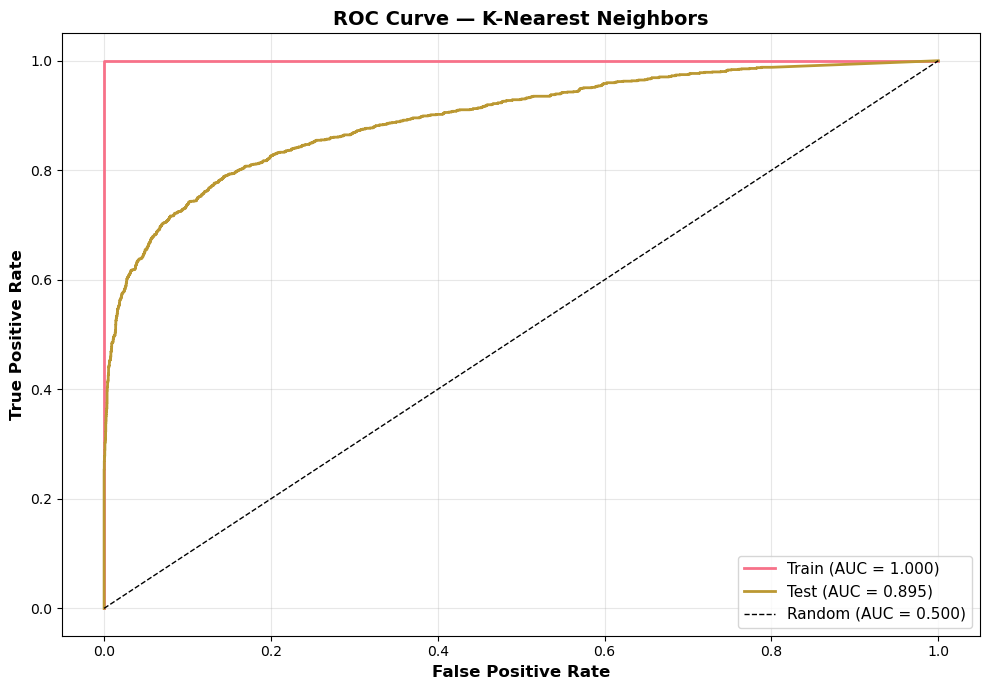

 ROC curve saved to: Output/roc_curve_knn.png

SAVING ARTIFACTS
 Best model saved to: models/knn_best.joblib
 Best params saved to: artifacts/knn_best_params.json
 Metrics saved to: artifacts/knn_metrics.json

======= K-NEAREST NEIGHBORS COMPLETE =======



In [12]:
# ========== 7.5 K-NEAREST NEIGHBORS (KNN) ==========
print("======= 7.5 K-NEAREST NEIGHBORS (KNN) =======\n")

# Define the model
knn = KNeighborsClassifier()

# Define hyperparameter grid
# KNN key parameters: n_neighbors, weights, metric
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 31],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Training KNN with GridSearchCV...")
grid_search_knn.fit(X_train_transformed, y_train)

# Best model
best_knn = grid_search_knn.best_estimator_
best_params_knn = grid_search_knn.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_knn.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_knn = best_knn.predict(X_train_transformed)
y_test_pred_knn = best_knn.predict(X_test_transformed)

y_train_proba_knn = best_knn.predict_proba(X_train_transformed)[:, 1]
y_test_proba_knn = best_knn.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)

# AUC
train_auc_knn = roc_auc_score(y_train, y_train_proba_knn)
test_auc_knn = roc_auc_score(y_test, y_test_proba_knn)

# Confusion matrices for Sensitivity/Specificity
cm_train_knn = confusion_matrix(y_train, y_train_pred_knn)
cm_test_knn = confusion_matrix(y_test, y_test_pred_knn)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_knn = cm_train_knn[0, 0] / (cm_train_knn[0, 0] + cm_train_knn[0, 1]) if (cm_train_knn[0, 0] + cm_train_knn[0, 1]) > 0 else 0
train_specificity_knn = cm_train_knn[1, 1] / (cm_train_knn[1, 0] + cm_train_knn[1, 1]) if (cm_train_knn[1, 0] + cm_train_knn[1, 1]) > 0 else 0

test_sensitivity_knn = cm_test_knn[0, 0] / (cm_test_knn[0, 0] + cm_test_knn[0, 1]) if (cm_test_knn[0, 0] + cm_test_knn[0, 1]) > 0 else 0
test_specificity_knn = cm_test_knn[1, 1] / (cm_test_knn[1, 0] + cm_test_knn[1, 1]) if (cm_test_knn[1, 0] + cm_test_knn[1, 1]) > 0 else 0

# Pack metrics
metrics_knn = {
    'Model': 'K-Nearest Neighbors',
    'Train Accuracy': train_acc_knn,
    'Test Accuracy': test_acc_knn,
    'Train AUC': train_auc_knn,
    'Test AUC': test_auc_knn,
    'Train Sensitivity': train_sensitivity_knn,
    'Test Sensitivity': test_sensitivity_knn,
    'Train Specificity': train_specificity_knn,
    'Test Specificity': test_specificity_knn
}

# Display metrics
metrics_df_knn = pd.DataFrame([metrics_knn])
print("\nMetrics Summary:")
print(metrics_df_knn.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_knn, tpr_train_knn, _ = roc_curve(y_train, y_train_proba_knn)
fpr_test_knn, tpr_test_knn, _ = roc_curve(y_test, y_test_proba_knn)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_knn, tpr_train_knn, label=f'Train (AUC = {train_auc_knn:.3f})', linewidth=2)
plt.plot(fpr_test_knn, tpr_test_knn, label=f'Test (AUC = {test_auc_knn:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — K-Nearest Neighbors', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_knn.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_knn.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_knn = 'models/knn_best.joblib'
dump(best_knn, model_path_knn)
print(f" Best model saved to: {model_path_knn}")

# Save best params
params_path_knn = 'artifacts/knn_best_params.json'
with open(params_path_knn, 'w') as f:
    json.dump(best_params_knn, f, indent=2)
print(f" Best params saved to: {params_path_knn}")

# Save metrics
metrics_path_knn = 'artifacts/knn_metrics.json'
with open(metrics_path_knn, 'w') as f:
    json.dump(metrics_knn, f, indent=2)
print(f" Metrics saved to: {metrics_path_knn}")

print("\n======= K-NEAREST NEIGHBORS COMPLETE =======\n")

# Return for potential downstream use
tuned_model_knn = best_knn
best_params_knn = best_params_knn
metrics_dict_knn = metrics_knn

### 7.6 Decision Tree (CART)

**Purpose & Approach:**
- Implements a **single decision tree classifier** using Classification and Regression Tree (CART) algorithm with recursive binary splitting
- Serves as an **interpretable baseline** for tree-based methods, providing transparent decision rules that can be visualized and explained
- Prone to overfitting without regularization, making it useful for assessing the value of ensemble methods

**Hyperparameter Tuning:**
- Tuned via **cost-complexity pruning** using `ccp_alpha` values derived from the pruning path of a full tree
- Explored tree depth (`max_depth`), minimum samples for splits/leaves, and class weighting using **RandomizedSearchCV** with 50 parameter combinations
- Selected configuration balances model complexity with generalization to prevent overfitting on training data

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **tree-based baseline** to quantify the improvement gained from ensemble methods (Bagging, Random Forest, Boosting)
- Performance ranked in Section 10 leaderboard by test AUC with overfitting gap analysis to assess regularization effectiveness

======= 7.6 DECISION TREE (CART) =======

Computing cost-complexity pruning path...
Selected 21 ccp_alpha values for tuning
Training Decision Tree with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best Hyperparameters:
  min_samples_split: 20
  min_samples_leaf: 5
  max_depth: None
  class_weight: None
  ccp_alpha: 0.0001187232033798559

COMPUTING METRICS

Metrics Summary:
        Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Decision Tree        0.937876        0.92736   0.930192  0.911335           0.991906          0.984998           0.744842          0.721439

PLOTTING ROC CURVES


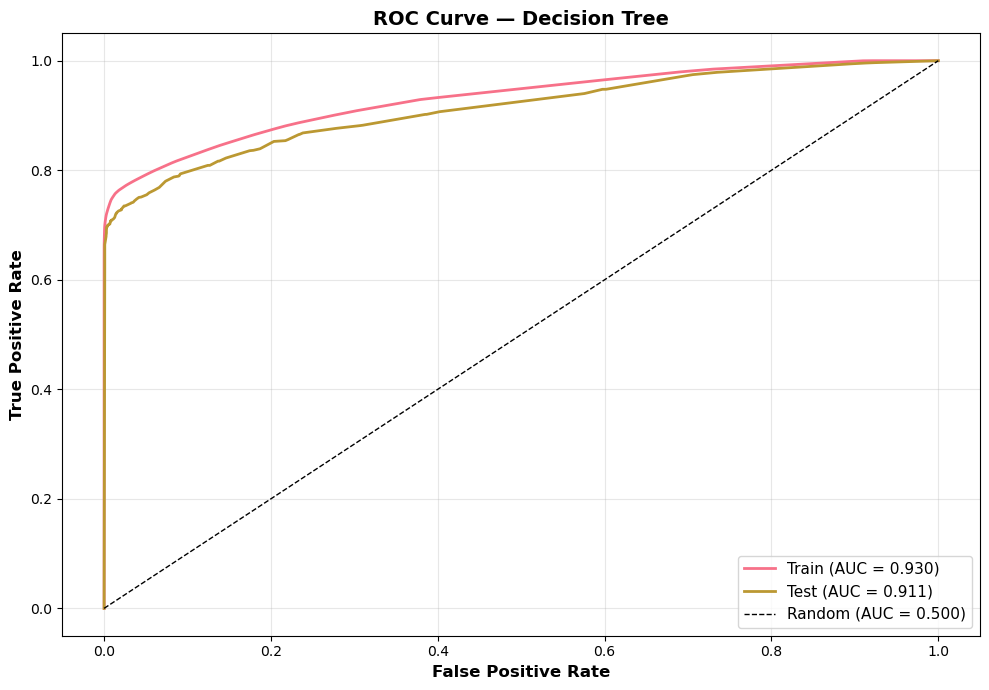

 ROC curve saved to: Output/roc_curve_decision_tree.png

SAVING ARTIFACTS
 Best model saved to: models/decision_tree_best.joblib
 Best params saved to: artifacts/decision_tree_best_params.json
 Metrics saved to: artifacts/decision_tree_metrics.json

======= DECISION TREE COMPLETE =======



In [13]:
# ========== 7.6 DECISION TREE (CART) ==========
print("======= 7.6 DECISION TREE (CART) =======\n")

# Define the model
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

# ========== PRUNING PATH APPROACH ==========
# First, fit a full tree to get the pruning path
print("Computing cost-complexity pruning path...")
full_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
full_tree.fit(X_train_transformed, y_train)
path = full_tree.cost_complexity_pruning_path(X_train_transformed, y_train)
ccp_alphas = path.ccp_alphas

# Filter out extreme values (too small or too large)
# Use alphas from the middle range for tuning
ccp_alphas_filtered = ccp_alphas[(ccp_alphas > 0) & (ccp_alphas < ccp_alphas.max())]

# Sample evenly from the filtered range to avoid too many candidates
if len(ccp_alphas_filtered) > 20:
    # Take every nth element to reduce search space
    step = len(ccp_alphas_filtered) // 20
    ccp_alphas_grid = ccp_alphas_filtered[::step]
else:
    ccp_alphas_grid = ccp_alphas_filtered

print(f"Selected {len(ccp_alphas_grid)} ccp_alpha values for tuning")

# Define hyperparameter grid
param_grid_dt = {
    'ccp_alpha': ccp_alphas_grid.tolist() + [0.0],  # Include 0.0 for unpruned tree
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, 'balanced']
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Use RandomizedSearchCV for efficiency (Decision Trees have many parameters)
print("Training Decision Tree with RandomizedSearchCV...")
grid_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_grid_dt,
    n_iter=50,  # Sample 50 combinations
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

grid_search_dt.fit(X_train_transformed, y_train)

# Best model
best_dt = grid_search_dt.best_estimator_
best_params_dt = grid_search_dt.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_dt.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_dt = best_dt.predict(X_train_transformed)
y_test_pred_dt = best_dt.predict(X_test_transformed)

y_train_proba_dt = best_dt.predict_proba(X_train_transformed)[:, 1]
y_test_proba_dt = best_dt.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)

# AUC
train_auc_dt = roc_auc_score(y_train, y_train_proba_dt)
test_auc_dt = roc_auc_score(y_test, y_test_proba_dt)

# Confusion matrices for Sensitivity/Specificity
cm_train_dt = confusion_matrix(y_train, y_train_pred_dt)
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_dt = cm_train_dt[0, 0] / (cm_train_dt[0, 0] + cm_train_dt[0, 1]) if (cm_train_dt[0, 0] + cm_train_dt[0, 1]) > 0 else 0
train_specificity_dt = cm_train_dt[1, 1] / (cm_train_dt[1, 0] + cm_train_dt[1, 1]) if (cm_train_dt[1, 0] + cm_train_dt[1, 1]) > 0 else 0

test_sensitivity_dt = cm_test_dt[0, 0] / (cm_test_dt[0, 0] + cm_test_dt[0, 1]) if (cm_test_dt[0, 0] + cm_test_dt[0, 1]) > 0 else 0
test_specificity_dt = cm_test_dt[1, 1] / (cm_test_dt[1, 0] + cm_test_dt[1, 1]) if (cm_test_dt[1, 0] + cm_test_dt[1, 1]) > 0 else 0

# Pack metrics
metrics_dt = {
    'Model': 'Decision Tree',
    'Train Accuracy': train_acc_dt,
    'Test Accuracy': test_acc_dt,
    'Train AUC': train_auc_dt,
    'Test AUC': test_auc_dt,
    'Train Sensitivity': train_sensitivity_dt,
    'Test Sensitivity': test_sensitivity_dt,
    'Train Specificity': train_specificity_dt,
    'Test Specificity': test_specificity_dt
}

# Display metrics
metrics_df_dt = pd.DataFrame([metrics_dt])
print("\nMetrics Summary:")
print(metrics_df_dt.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_dt, tpr_train_dt, _ = roc_curve(y_train, y_train_proba_dt)
fpr_test_dt, tpr_test_dt, _ = roc_curve(y_test, y_test_proba_dt)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_dt, tpr_train_dt, label=f'Train (AUC = {train_auc_dt:.3f})', linewidth=2)
plt.plot(fpr_test_dt, tpr_test_dt, label=f'Test (AUC = {test_auc_dt:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Decision Tree', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_decision_tree.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_dt = 'models/decision_tree_best.joblib'
dump(best_dt, model_path_dt)
print(f" Best model saved to: {model_path_dt}")

# Save best params
params_path_dt = 'artifacts/decision_tree_best_params.json'
with open(params_path_dt, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_params = {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                          for k, v in best_params_dt.items()}
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_dt}")

# Save metrics
metrics_path_dt = 'artifacts/decision_tree_metrics.json'
with open(metrics_path_dt, 'w') as f:
    json.dump(metrics_dt, f, indent=2)
print(f" Metrics saved to: {metrics_path_dt}")

print("\n======= DECISION TREE COMPLETE =======\n")

# Return for potential downstream use
tuned_model_dt = best_dt
best_params_dt = best_params_dt
metrics_dict_dt = metrics_dt

### 7.7 Bagging (Bootstrap Aggregation)

**Purpose & Approach:**
- Implements an **ensemble method** that reduces variance by training multiple decision trees on bootstrapped samples of the training data and averaging their predictions
- Serves as a **variance reduction benchmark** to assess whether aggregating independent weak learners improves over a single decision tree's performance
- Addresses overfitting by introducing diversity through random sampling of both training instances and features

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified RandomizedSearchCV** optimizing ROC-AUC with 50 parameter combinations
- Explored ensemble size (`n_estimators`), bootstrap sampling rates (`max_samples`, `max_features`), feature/instance bootstrapping strategies, and base tree complexity (depth, split criteria, class weighting)
- Selected configuration balances ensemble diversity with individual tree quality to maximize generalization

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **pure ensemble baseline** to quantify variance reduction gains over single decision trees and to compare against Random Forest (which adds feature randomization) and boosting methods (which use sequential learning)
- Performance ranked in Section 10 leaderboard by test AUC with overfitting gap analysis to evaluate ensemble stability

======= 7.7 BAGGING =======

Training Bagging with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best Hyperparameters:
  n_estimators: 200
  max_samples: 0.9
  max_features: 0.9
  estimator__min_samples_split: 2
  estimator__min_samples_leaf: 2
  estimator__max_depth: 30
  estimator__class_weight: None
  bootstrap_features: True
  bootstrap: False

COMPUTING METRICS

Metrics Summary:
  Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Bagging        0.999807       0.934762        1.0  0.937623                1.0          0.992104           0.999118          0.729901

PLOTTING ROC CURVES


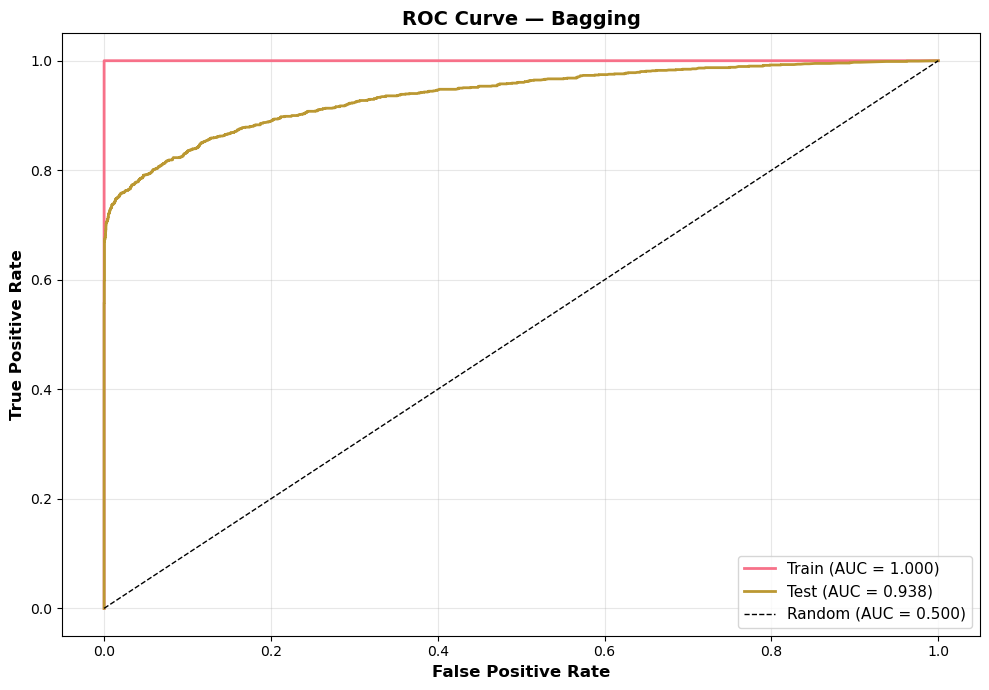

 ROC curve saved to: Output/roc_curve_bagging.png

SAVING ARTIFACTS
 Best model saved to: models/bagging_best.joblib
 Best params saved to: artifacts/bagging_best_params.json
 Metrics saved to: artifacts/bagging_metrics.json

======= BAGGING COMPLETE =======



In [14]:
# ========== 7.7 BAGGING (DECISION TREE BASE) ==========
print("======= 7.7 BAGGING =======\n")

# Define the model
# BaggingClassifier with DecisionTreeClassifier as base estimator
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    random_state=RANDOM_STATE
)

# Define hyperparameter grid
# Focus on n_estimators, max_samples, max_features, and bootstrap
param_distributions_bagging = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [False, True],
    # Base estimator parameters
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5],
    'estimator__class_weight': [None, 'balanced']
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Use RandomizedSearchCV for efficiency (many parameter combinations)
print("Training Bagging with RandomizedSearchCV...")
random_search_bagging = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=param_distributions_bagging,
    n_iter=50,  # Sample 50 combinations
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_bagging.fit(X_train_transformed, y_train)

# Best model
best_bagging = random_search_bagging.best_estimator_
best_params_bagging = random_search_bagging.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_bagging.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_bagging = best_bagging.predict(X_train_transformed)
y_test_pred_bagging = best_bagging.predict(X_test_transformed)

y_train_proba_bagging = best_bagging.predict_proba(X_train_transformed)[:, 1]
y_test_proba_bagging = best_bagging.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_bagging = accuracy_score(y_train, y_train_pred_bagging)
test_acc_bagging = accuracy_score(y_test, y_test_pred_bagging)

# AUC
train_auc_bagging = roc_auc_score(y_train, y_train_proba_bagging)
test_auc_bagging = roc_auc_score(y_test, y_test_proba_bagging)

# Confusion matrices for Sensitivity/Specificity
cm_train_bagging = confusion_matrix(y_train, y_train_pred_bagging)
cm_test_bagging = confusion_matrix(y_test, y_test_pred_bagging)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_bagging = cm_train_bagging[0, 0] / (cm_train_bagging[0, 0] + cm_train_bagging[0, 1]) if (cm_train_bagging[0, 0] + cm_train_bagging[0, 1]) > 0 else 0
train_specificity_bagging = cm_train_bagging[1, 1] / (cm_train_bagging[1, 0] + cm_train_bagging[1, 1]) if (cm_train_bagging[1, 0] + cm_train_bagging[1, 1]) > 0 else 0

test_sensitivity_bagging = cm_test_bagging[0, 0] / (cm_test_bagging[0, 0] + cm_test_bagging[0, 1]) if (cm_test_bagging[0, 0] + cm_test_bagging[0, 1]) > 0 else 0
test_specificity_bagging = cm_test_bagging[1, 1] / (cm_test_bagging[1, 0] + cm_test_bagging[1, 1]) if (cm_test_bagging[1, 0] + cm_test_bagging[1, 1]) > 0 else 0

# Pack metrics
metrics_bagging = {
    'Model': 'Bagging',
    'Train Accuracy': train_acc_bagging,
    'Test Accuracy': test_acc_bagging,
    'Train AUC': train_auc_bagging,
    'Test AUC': test_auc_bagging,
    'Train Sensitivity': train_sensitivity_bagging,
    'Test Sensitivity': test_sensitivity_bagging,
    'Train Specificity': train_specificity_bagging,
    'Test Specificity': test_specificity_bagging
}

# Display metrics
metrics_df_bagging = pd.DataFrame([metrics_bagging])
print("\nMetrics Summary:")
print(metrics_df_bagging.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_bagging, tpr_train_bagging, _ = roc_curve(y_train, y_train_proba_bagging)
fpr_test_bagging, tpr_test_bagging, _ = roc_curve(y_test, y_test_proba_bagging)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_bagging, tpr_train_bagging, label=f'Train (AUC = {train_auc_bagging:.3f})', linewidth=2)
plt.plot(fpr_test_bagging, tpr_test_bagging, label=f'Test (AUC = {test_auc_bagging:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Bagging', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_bagging.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_bagging.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_bagging = 'models/bagging_best.joblib'
dump(best_bagging, model_path_bagging)
print(f" Best model saved to: {model_path_bagging}")

# Save best params
params_path_bagging = 'artifacts/bagging_best_params.json'
with open(params_path_bagging, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_params = {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                          for k, v in best_params_bagging.items()}
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_bagging}")

# Save metrics
metrics_path_bagging = 'artifacts/bagging_metrics.json'
with open(metrics_path_bagging, 'w') as f:
    json.dump(metrics_bagging, f, indent=2)
print(f" Metrics saved to: {metrics_path_bagging}")

print("\n======= BAGGING COMPLETE =======\n")

# Return for potential downstream use
tuned_model_bagging = best_bagging
best_params_bagging = best_params_bagging
metrics_dict_bagging = metrics_bagging

### 7.8 Random Forest

**Purpose & Approach:**
- Implements an **ensemble of decision trees** using Random Forest, which combines bagging with random feature subsampling to reduce overfitting and improve generalization
- Serves as a **high-performance tree ensemble baseline** that typically outperforms single decision trees and basic bagging through decorrelation of individual trees
- More robust than single decision trees while maintaining interpretability through feature importance metrics

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified RandomizedSearchCV** optimizing ROC-AUC with 60 parameter combinations
- Explored ensemble size (`n_estimators`), tree depth (`max_depth`), split criteria (`min_samples_split`, `min_samples_leaf`), feature sampling strategy (`max_features`), bootstrap sampling, and class weighting
- Selected configuration balances forest size, tree complexity, and feature randomization to maximize predictive power while controlling variance

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **strong ensemble benchmark** to compare against single trees, bagging (without feature randomization), and boosting methods (sequential learning)
- Performance ranked in Section 10 leaderboard by test AUC with overfitting gap analysis to evaluate the effectiveness of random feature subsampling

======= 7.8 RANDOM FOREST =======

Training Random Forest with RandomizedSearchCV...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

 Best Hyperparameters:
  n_estimators: 300
  min_samples_split: 15
  min_samples_leaf: 1
  max_features: 0.5
  max_depth: 50
  class_weight: balanced
  bootstrap: True

COMPUTING METRICS

Metrics Summary:
        Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Random Forest        0.981451       0.931678   0.999068  0.936897           0.995755           0.98559           0.930347          0.739069

PLOTTING ROC CURVES


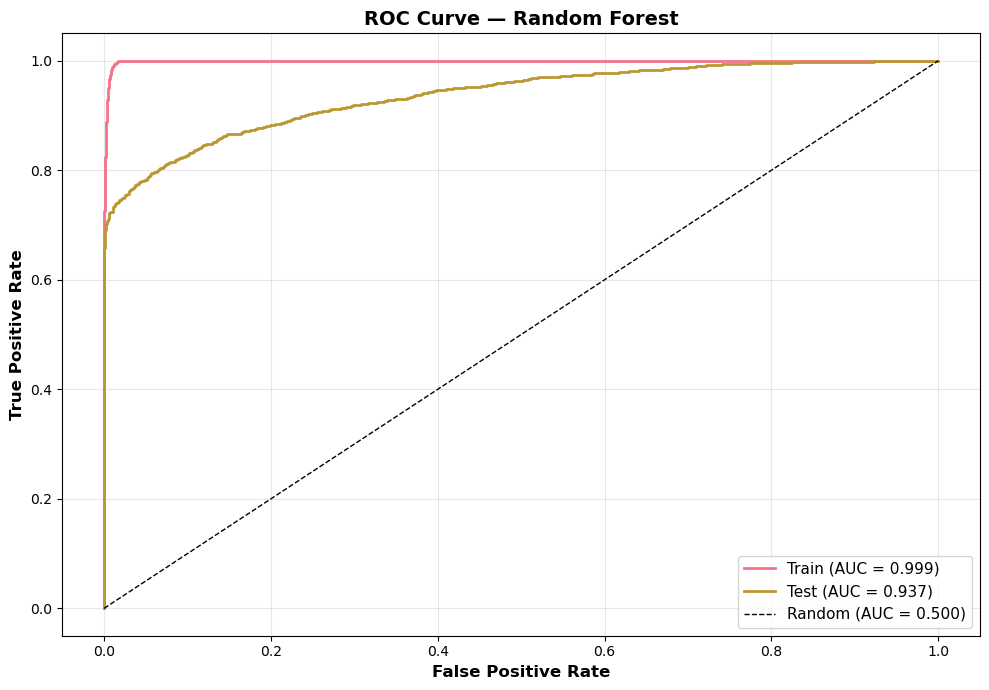

 ROC curve saved to: Output/roc_curve_random_forest.png

SAVING ARTIFACTS
 Best model saved to: models/random_forest_best.joblib
 Best params saved to: artifacts/random_forest_best_params.json
 Metrics saved to: artifacts/random_forest_metrics.json

======= RANDOM FOREST COMPLETE =======



In [15]:
# ========== 7.8 RANDOM FOREST ==========
print("======= 7.8 RANDOM FOREST =======\n")

# Define the model
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Define hyperparameter distribution for RandomizedSearchCV
# Random Forest benefits from larger search space explored efficiently
param_distributions_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Use RandomizedSearchCV for efficiency
print("Training Random Forest with RandomizedSearchCV...")
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions_rf,
    n_iter=60,  # Sample 60 combinations
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_rf.fit(X_train_transformed, y_train)

# Best model
best_rf = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_rf.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_rf = best_rf.predict(X_train_transformed)
y_test_pred_rf = best_rf.predict(X_test_transformed)

y_train_proba_rf = best_rf.predict_proba(X_train_transformed)[:, 1]
y_test_proba_rf = best_rf.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

# AUC
train_auc_rf = roc_auc_score(y_train, y_train_proba_rf)
test_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

# Confusion matrices for Sensitivity/Specificity
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_rf = cm_train_rf[0, 0] / (cm_train_rf[0, 0] + cm_train_rf[0, 1]) if (cm_train_rf[0, 0] + cm_train_rf[0, 1]) > 0 else 0
train_specificity_rf = cm_train_rf[1, 1] / (cm_train_rf[1, 0] + cm_train_rf[1, 1]) if (cm_train_rf[1, 0] + cm_train_rf[1, 1]) > 0 else 0

test_sensitivity_rf = cm_test_rf[0, 0] / (cm_test_rf[0, 0] + cm_test_rf[0, 1]) if (cm_test_rf[0, 0] + cm_test_rf[0, 1]) > 0 else 0
test_specificity_rf = cm_test_rf[1, 1] / (cm_test_rf[1, 0] + cm_test_rf[1, 1]) if (cm_test_rf[1, 0] + cm_test_rf[1, 1]) > 0 else 0

# Pack metrics
metrics_rf = {
    'Model': 'Random Forest',
    'Train Accuracy': train_acc_rf,
    'Test Accuracy': test_acc_rf,
    'Train AUC': train_auc_rf,
    'Test AUC': test_auc_rf,
    'Train Sensitivity': train_sensitivity_rf,
    'Test Sensitivity': test_sensitivity_rf,
    'Train Specificity': train_specificity_rf,
    'Test Specificity': test_specificity_rf
}

# Display metrics
metrics_df_rf = pd.DataFrame([metrics_rf])
print("\nMetrics Summary:")
print(metrics_df_rf.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_proba_rf)
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_proba_rf)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_rf, tpr_train_rf, label=f'Train (AUC = {train_auc_rf:.3f})', linewidth=2)
plt.plot(fpr_test_rf, tpr_test_rf, label=f'Test (AUC = {test_auc_rf:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_random_forest.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_rf = 'models/random_forest_best.joblib'
dump(best_rf, model_path_rf)
print(f" Best model saved to: {model_path_rf}")

# Save best params
params_path_rf = 'artifacts/random_forest_best_params.json'
with open(params_path_rf, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_params = {k: int(v) if isinstance(v, (np.integer)) else 
                          float(v) if isinstance(v, (np.floating)) else v 
                          for k, v in best_params_rf.items()}
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_rf}")

# Save metrics
metrics_path_rf = 'artifacts/random_forest_metrics.json'
with open(metrics_path_rf, 'w') as f:
    json.dump(metrics_rf, f, indent=2)
print(f" Metrics saved to: {metrics_path_rf}")

print("\n======= RANDOM FOREST COMPLETE =======\n")

# Return for potential downstream use
tuned_model_rf = best_rf
best_params_rf = best_params_rf
metrics_dict_rf = metrics_rf

### 7.9 AdaBoost

**Purpose & Approach:**
- Implements a **sequential boosting ensemble** that combines weak learners (decision stumps) by iteratively reweighting misclassified samples to focus on hard-to-predict cases
- Serves as a **bias reduction benchmark** to compare sequential boosting against parallel ensemble methods (Bagging, Random Forest) and gradient-based boosting
- Uses adaptive boosting (SAMME algorithm) to build an additive model where each weak learner corrects errors from previous iterations

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified GridSearchCV** optimizing ROC-AUC
- Explored ensemble size (`n_estimators`), learning rate for weight updates, base estimator depth (1-4 levels), and class weighting strategies
- Selected configuration balances ensemble size with learning rate to prevent overfitting while maintaining strong sequential error correction

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **sequential boosting baseline** to quantify whether iterative error-focused reweighting improves over parallel ensembles and gradient-based boosting methods
- Performance ranked in Section 10 leaderboard by test AUC with overfitting gap analysis to assess whether adaptive reweighting causes training set memorization

======= 7.9 ADABOOST =======

Training AdaBoost with RandomizedSearchCV...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\John\anaconda3\envs\mlproject\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



 Best Hyperparameters:
  estimator__max_depth: 3
  learning_rate: 0.6932635188254582
  n_estimators: 221

COMPUTING METRICS

Metrics Summary:
   Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
AdaBoost        0.912502       0.914713   0.928356  0.922013           0.974236          0.975128           0.691941          0.698872

PLOTTING ROC CURVES


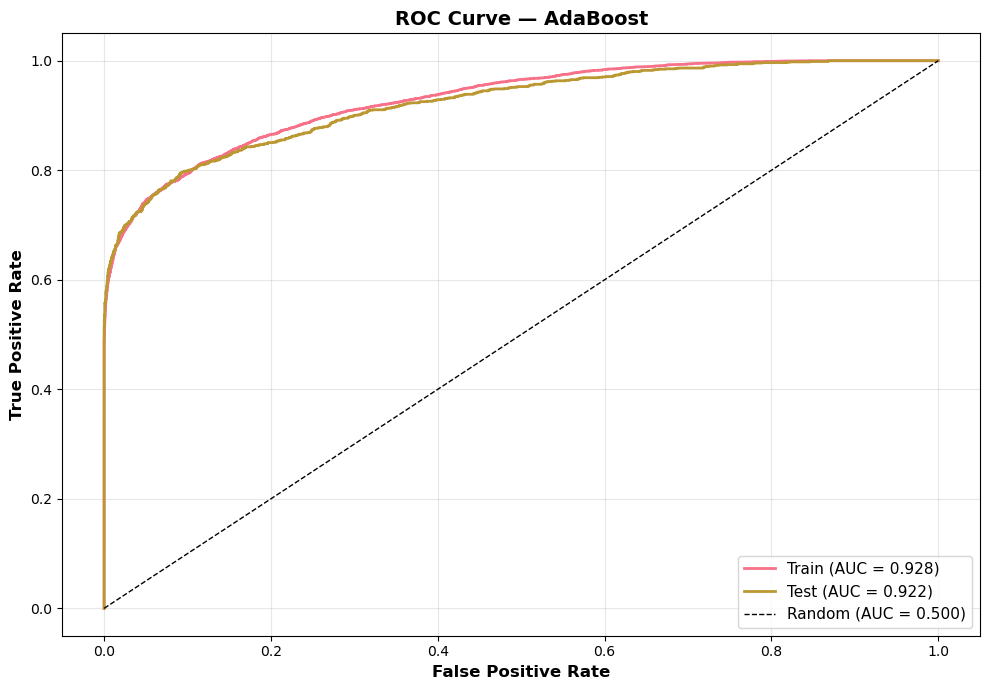

 ROC curve saved to: Output/roc_curve_adaboost.png

SAVING ARTIFACTS
 Best model saved to: models/adaboost_best.joblib
 Best params saved to: artifacts/adaboost_best_params.json
 Metrics saved to: artifacts/adaboost_metrics.json

======= ADABOOST COMPLETE =======



In [17]:
# ========== 7.9 ADABOOST ==========
print("======= 7.9 ADABOOST =======\n")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the base AdaBoost model
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE), 
    algorithm='SAMME',   # Faster + usually higher AUC
    random_state=RANDOM_STATE
)

# Optimized hyperparameter search space
param_dist_adaboost = {
    'n_estimators': randint(50, 300),            # reduced range
    'learning_rate': uniform(0.01, 1.0),         # continuous sample
    'estimator__max_depth': randint(1, 4)        # stumps or shallow trees
}

# Faster cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

print("Training AdaBoost with RandomizedSearchCV...")
random_search_adaboost = RandomizedSearchCV(
    estimator=adaboost,
    param_distributions=param_dist_adaboost,
    n_iter=25,                    # 25 random samples instead of 240 grid combos
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_adaboost.fit(X_train_transformed, y_train)

# Best model
best_adaboost = random_search_adaboost.best_estimator_
best_params_adaboost = random_search_adaboost.best_params_

print("\n Best Hyperparameters:")
for param, value in best_params_adaboost.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_adaboost = best_adaboost.predict(X_train_transformed)
y_test_pred_adaboost = best_adaboost.predict(X_test_transformed)

y_train_proba_adaboost = best_adaboost.predict_proba(X_train_transformed)[:, 1]
y_test_proba_adaboost = best_adaboost.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_adaboost = accuracy_score(y_train, y_train_pred_adaboost)
test_acc_adaboost = accuracy_score(y_test, y_test_pred_adaboost)

# AUC
train_auc_adaboost = roc_auc_score(y_train, y_train_proba_adaboost)
test_auc_adaboost = roc_auc_score(y_test, y_test_proba_adaboost)

# Confusion matrices
cm_train_adaboost = confusion_matrix(y_train, y_train_pred_adaboost)
cm_test_adaboost = confusion_matrix(y_test, y_test_pred_adaboost)

# Sensitivity & Specificity
train_sensitivity_adaboost = cm_train_adaboost[0, 0] / (cm_train_adaboost[0, 0] + cm_train_adaboost[0, 1]) if (cm_train_adaboost[0, 0] + cm_train_adaboost[0, 1]) > 0 else 0
train_specificity_adaboost = cm_train_adaboost[1, 1] / (cm_train_adaboost[1, 0] + cm_train_adaboost[1, 1]) if (cm_train_adaboost[1, 0] + cm_train_adaboost[1, 1]) > 0 else 0

test_sensitivity_adaboost = cm_test_adaboost[0, 0] / (cm_test_adaboost[0, 0] + cm_test_adaboost[0, 1]) if (cm_test_adaboost[0, 0] + cm_test_adaboost[0, 1]) > 0 else 0
test_specificity_adaboost = cm_test_adaboost[1, 1] / (cm_test_adaboost[1, 0] + cm_test_adaboost[1, 1]) if (cm_test_adaboost[1, 0] + cm_test_adaboost[1, 1]) > 0 else 0

# Pack metrics
metrics_adaboost = {
    'Model': 'AdaBoost',
    'Train Accuracy': train_acc_adaboost,
    'Test Accuracy': test_acc_adaboost,
    'Train AUC': train_auc_adaboost,
    'Test AUC': test_auc_adaboost,
    'Train Sensitivity': train_sensitivity_adaboost,
    'Test Sensitivity': test_sensitivity_adaboost,
    'Train Specificity': train_specificity_adaboost,
    'Test Specificity': test_specificity_adaboost
}

# Display metrics
metrics_df_adaboost = pd.DataFrame([metrics_adaboost])
print("\nMetrics Summary:")
print(metrics_df_adaboost.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train_adaboost := roc_curve(y_train, y_train_proba_adaboost)[0],
         tpr_train_adaboost := roc_curve(y_train, y_train_proba_adaboost)[1],
         label=f'Train (AUC = {train_auc_adaboost:.3f})', linewidth=2)

plt.plot(fpr_test_adaboost := roc_curve(y_test, y_test_proba_adaboost)[0],
         tpr_test_adaboost := roc_curve(y_test, y_test_proba_adaboost)[1],
         label=f'Test (AUC = {test_auc_adaboost:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — AdaBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_adaboost.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_adaboost.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_adaboost = 'models/adaboost_best.joblib'
dump(best_adaboost, model_path_adaboost)
print(f" Best model saved to: {model_path_adaboost}")

# Save best params
params_path_adaboost = 'artifacts/adaboost_best_params.json'
with open(params_path_adaboost, 'w') as f:
    serializable_params = {
        k: (int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v)
        for k, v in best_params_adaboost.items()
    }
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_adaboost}")

# Save metrics
metrics_path_adaboost = 'artifacts/adaboost_metrics.json'
with open(metrics_path_adaboost, 'w') as f:
    json.dump(metrics_adaboost, f, indent=2)
print(f" Metrics saved to: {metrics_path_adaboost}")

print("\n======= ADABOOST COMPLETE =======\n")

# Return for potential downstream use
tuned_model_adaboost = best_adaboost
best_params_adaboost = best_params_adaboost
metrics_dict_adaboost = metrics_adaboost


### 7.10 Gradient Boosting

**Purpose & Approach:**
- Implements a **gradient-based sequential boosting ensemble** that builds an additive model by fitting shallow decision trees to the residual errors of previous iterations
- Serves as an **advanced boosting benchmark** to compare gradient-based optimization against adaptive reweighting (AdaBoost) and parallel ensemble methods (Random Forest, Bagging)
- Uses stagewise additive modeling where each tree minimizes a loss function's gradient, typically achieving superior performance on structured data

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified RandomizedSearchCV** optimizing ROC-AUC with 60 parameter combinations
- Explored ensemble size (`n_estimators`), learning rate for gradient descent steps, tree depth (`max_depth`), subsampling rate for stochastic gradient boosting, split criteria (`min_samples_split`, `min_samples_leaf`), and feature randomization (`max_features`)
- Selected configuration balances learning rate with ensemble size to prevent overfitting while maintaining strong sequential error correction through gradient optimization

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **gradient boosting benchmark** to quantify whether gradient-based optimization outperforms adaptive reweighting (AdaBoost) and parallel aggregation methods (Bagging, Random Forest)
- Performance ranked in Section 10 leaderboard by test AUC with overfitting gap analysis to assess whether sequential gradient fitting causes training set memorization

======= 7.10 GRADIENT BOOSTING =======

Training Gradient Boosting with RandomizedSearchCV...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

 Best Hyperparameters:
  subsample: 0.9
  n_estimators: 500
  min_samples_split: 5
  min_samples_leaf: 4
  max_features: None
  max_depth: 4
  learning_rate: 0.1

COMPUTING METRICS

Metrics Summary:
            Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Gradient Boosting        0.957311       0.937847   0.987415  0.951394           0.998322          0.992302           0.810792            0.7433

PLOTTING ROC CURVES


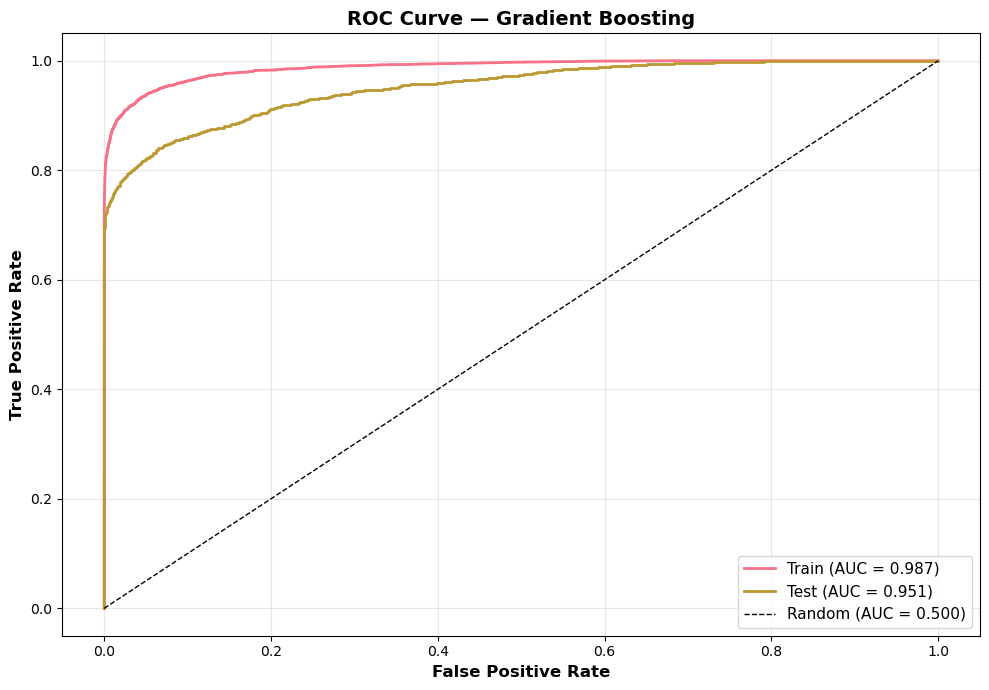

 ROC curve saved to: Output/roc_curve_gradient_boosting.png

SAVING ARTIFACTS
 Best model saved to: models/gradient_boosting_best.joblib
 Best params saved to: artifacts/gradient_boosting_best_params.json
 Metrics saved to: artifacts/gradient_boosting_metrics.json

======= GRADIENT BOOSTING COMPLETE =======



In [18]:
# ========== 7.10 GRADIENT BOOSTING ==========
print("======= 7.10 GRADIENT BOOSTING =======\n")

# Define the model
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

# Define hyperparameter grid
# Key parameters: n_estimators, learning_rate, max_depth, subsample
param_grid_gb = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Use RandomizedSearchCV for efficiency (Gradient Boosting has many parameters)
print("Training Gradient Boosting with RandomizedSearchCV...")
random_search_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_grid_gb,
    n_iter=60,  # Sample 60 combinations
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_gb.fit(X_train_transformed, y_train)

# Best model
best_gb = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_gb.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_gb = best_gb.predict(X_train_transformed)
y_test_pred_gb = best_gb.predict(X_test_transformed)

y_train_proba_gb = best_gb.predict_proba(X_train_transformed)[:, 1]
y_test_proba_gb = best_gb.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_gb = accuracy_score(y_train, y_train_pred_gb)
test_acc_gb = accuracy_score(y_test, y_test_pred_gb)

# AUC
train_auc_gb = roc_auc_score(y_train, y_train_proba_gb)
test_auc_gb = roc_auc_score(y_test, y_test_proba_gb)

# Confusion matrices for Sensitivity/Specificity
cm_train_gb = confusion_matrix(y_train, y_train_pred_gb)
cm_test_gb = confusion_matrix(y_test, y_test_pred_gb)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_gb = cm_train_gb[0, 0] / (cm_train_gb[0, 0] + cm_train_gb[0, 1]) if (cm_train_gb[0, 0] + cm_train_gb[0, 1]) > 0 else 0
train_specificity_gb = cm_train_gb[1, 1] / (cm_train_gb[1, 0] + cm_train_gb[1, 1]) if (cm_train_gb[1, 0] + cm_train_gb[1, 1]) > 0 else 0

test_sensitivity_gb = cm_test_gb[0, 0] / (cm_test_gb[0, 0] + cm_test_gb[0, 1]) if (cm_test_gb[0, 0] + cm_test_gb[0, 1]) > 0 else 0
test_specificity_gb = cm_test_gb[1, 1] / (cm_test_gb[1, 0] + cm_test_gb[1, 1]) if (cm_test_gb[1, 0] + cm_test_gb[1, 1]) > 0 else 0

# Pack metrics
metrics_gb = {
    'Model': 'Gradient Boosting',
    'Train Accuracy': train_acc_gb,
    'Test Accuracy': test_acc_gb,
    'Train AUC': train_auc_gb,
    'Test AUC': test_auc_gb,
    'Train Sensitivity': train_sensitivity_gb,
    'Test Sensitivity': test_sensitivity_gb,
    'Train Specificity': train_specificity_gb,
    'Test Specificity': test_specificity_gb
}

# Display metrics
metrics_df_gb = pd.DataFrame([metrics_gb])
print("\nMetrics Summary:")
print(metrics_df_gb.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_gb, tpr_train_gb, _ = roc_curve(y_train, y_train_proba_gb)
fpr_test_gb, tpr_test_gb, _ = roc_curve(y_test, y_test_proba_gb)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_gb, tpr_train_gb, label=f'Train (AUC = {train_auc_gb:.3f})', linewidth=2)
plt.plot(fpr_test_gb, tpr_test_gb, label=f'Test (AUC = {test_auc_gb:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Gradient Boosting', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_gradient_boosting.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_gradient_boosting.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_gb = 'models/gradient_boosting_best.joblib'
dump(best_gb, model_path_gb)
print(f" Best model saved to: {model_path_gb}")

# Save best params
params_path_gb = 'artifacts/gradient_boosting_best_params.json'
with open(params_path_gb, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_params = {k: int(v) if isinstance(v, (np.integer)) else 
                          float(v) if isinstance(v, (np.floating)) else v 
                          for k, v in best_params_gb.items()}
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_gb}")

# Save metrics
metrics_path_gb = 'artifacts/gradient_boosting_metrics.json'
with open(metrics_path_gb, 'w') as f:
    json.dump(metrics_gb, f, indent=2)
print(f" Metrics saved to: {metrics_path_gb}")

print("\n======= GRADIENT BOOSTING COMPLETE =======\n")

# Return for potential downstream use
tuned_model_gb = best_gb
best_params_gb = best_params_gb
metrics_dict_gb = metrics_gb

### 7.11 Support Vector Machine (Linear)

**Purpose & Approach:**
- Implements a **maximum-margin linear classifier** using LinearSVC wrapped with calibrated probability estimates via `CalibratedClassifierCV` for credit risk prediction
- Serves as a **linear margin-based baseline** to compare against kernel-based SVMs, probabilistic models, and ensemble methods by finding the optimal hyperplane that maximizes the margin between classes

**Hyperparameter Tuning:**
- Tuned via **5-fold stratified GridSearchCV** optimizing ROC-AUC
- Explored regularization strength (`C`) and class weighting strategies (`None`, `balanced`) to handle class imbalance
- Probability calibration applied post-training using internal 5-fold cross-validation to enable probabilistic predictions

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **fast linear SVM benchmark** to assess whether linear decision boundaries are sufficient or if nonlinear kernels (RBF SVM) provide meaningful performance gains
- Performance ranked in Section 10 leaderboard by test AUC with generalization gap analysis to evaluate margin-based classification effectiveness

======= 7.11 SUPPORT VECTOR MACHINE (LINEAR) =======

Training Linear SVM with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Best Hyperparameters:
  estimator__C: 100
  estimator__class_weight: balanced

COMPUTING METRICS

Metrics Summary:
       Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
SVM (Linear)        0.872281       0.870759   0.892577  0.890186           0.949904          0.947493           0.594957          0.596615

PLOTTING ROC CURVES


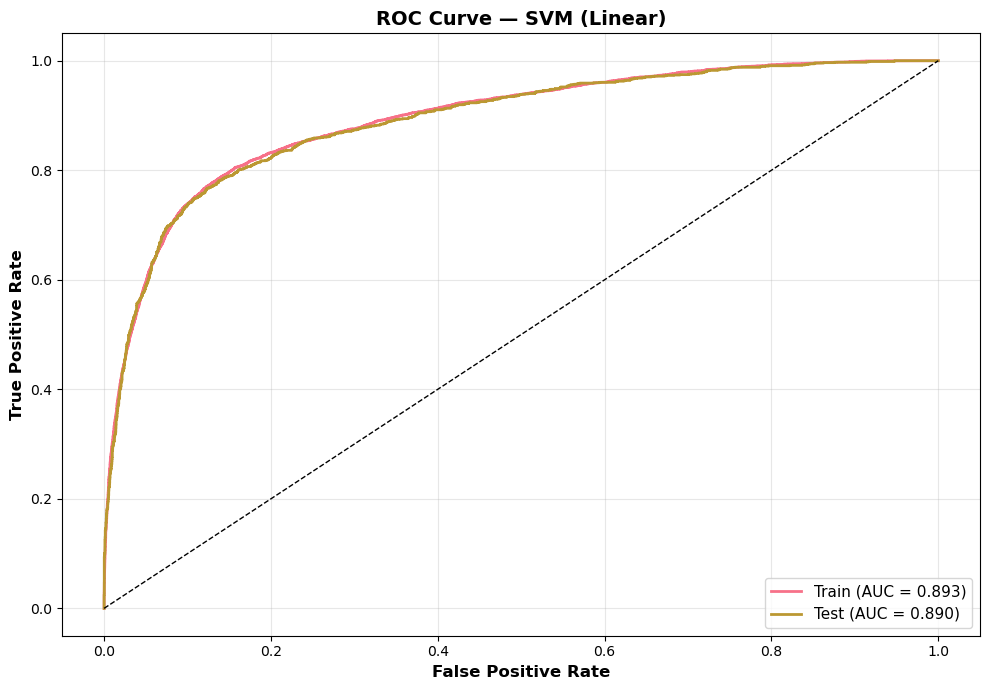

 ROC curve saved to: Output/roc_curve_svm_linear.png

SAVING ARTIFACTS
 Best model saved to: models/svm_linear_best.joblib
 Best params saved to: artifacts/svm_linear_best_params.json
 Metrics saved to: artifacts/svm_linear_metrics.json

======= SVM (LINEAR) COMPLETE =======



In [19]:
# ========== 7.11 SUPPORT VECTOR MACHINE (LINEAR) ==========
print("======= 7.11 SUPPORT VECTOR MACHINE (LINEAR) =======\n")

# ----------------------------------------------------------
#  FAST LINEAR SVM IMPLEMENTATION (LinearSVC + Calibration)
# ----------------------------------------------------------

# Base linear SVM (fast, but no probability)
base_linear_svm = LinearSVC(
    C=1.0, 
    class_weight=None,
    random_state=RANDOM_STATE,
    max_iter=5000
)

# Wrap with probability calibration to match your expected outputs
svm_linear = CalibratedClassifierCV(
    estimator=base_linear_svm,
    cv=5  # internal CV for probability calibration
)

# NOTE: Hyperparameters apply to the underlying LinearSVC ("estimator__")
param_grid_svm_linear = {
    'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'estimator__class_weight': [None, 'balanced']
}

# Cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Training Linear SVM with GridSearchCV...")
grid_search_svm_linear = GridSearchCV(
    estimator=svm_linear,
    param_grid=param_grid_svm_linear,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_svm_linear.fit(X_train_transformed, y_train)

# Best model & params
best_svm_linear = grid_search_svm_linear.best_estimator_
best_params_svm_linear = grid_search_svm_linear.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_svm_linear.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_svm_linear = best_svm_linear.predict(X_train_transformed)
y_test_pred_svm_linear = best_svm_linear.predict(X_test_transformed)

# Probabilities (thanks to CalibratedClassifierCV)
y_train_proba_svm_linear = best_svm_linear.predict_proba(X_train_transformed)[:, 1]
y_test_proba_svm_linear = best_svm_linear.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_svm_linear = accuracy_score(y_train, y_train_pred_svm_linear)
test_acc_svm_linear = accuracy_score(y_test, y_test_pred_svm_linear)

# AUC
train_auc_svm_linear = roc_auc_score(y_train, y_train_proba_svm_linear)
test_auc_svm_linear = roc_auc_score(y_test, y_test_proba_svm_linear)

# Confusion matrices
cm_train_svm_linear = confusion_matrix(y_train, y_train_pred_svm_linear)
cm_test_svm_linear = confusion_matrix(y_test, y_test_pred_svm_linear)

# Sensitivity (Recall for class 0)
train_sensitivity_svm_linear = cm_train_svm_linear[0, 0] / (cm_train_svm_linear[0, 0] + cm_train_svm_linear[0, 1])
test_sensitivity_svm_linear = cm_test_svm_linear[0, 0] / (cm_test_svm_linear[0, 0] + cm_test_svm_linear[0, 1])

# Specificity (Recall for class 1)
train_specificity_svm_linear = cm_train_svm_linear[1, 1] / (cm_train_svm_linear[1, 0] + cm_train_svm_linear[1, 1])
test_specificity_svm_linear = cm_test_svm_linear[1, 1] / (cm_test_svm_linear[1, 0] + cm_test_svm_linear[1, 1])

# Metrics dictionary
metrics_svm_linear = {
    'Model': 'SVM (Linear)',
    'Train Accuracy': train_acc_svm_linear,
    'Test Accuracy': test_acc_svm_linear,
    'Train AUC': train_auc_svm_linear,
    'Test AUC': test_auc_svm_linear,
    'Train Sensitivity': train_sensitivity_svm_linear,
    'Test Sensitivity': test_sensitivity_svm_linear,
    'Train Specificity': train_specificity_svm_linear,
    'Test Specificity': test_specificity_svm_linear
}

# Display metrics
metrics_df_svm_linear = pd.DataFrame([metrics_svm_linear])
print("\nMetrics Summary:")
print(metrics_df_svm_linear.to_string(index=False))

# ========== ROC CURVES ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

fpr_train_svm_linear, tpr_train_svm_linear, _ = roc_curve(y_train, y_train_proba_svm_linear)
fpr_test_svm_linear, tpr_test_svm_linear, _ = roc_curve(y_test, y_test_proba_svm_linear)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train_svm_linear, tpr_train_svm_linear, label=f'Train (AUC = {train_auc_svm_linear:.3f})', linewidth=2)
plt.plot(fpr_test_svm_linear, tpr_test_svm_linear, label=f'Test (AUC = {test_auc_svm_linear:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — SVM (Linear)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_svm_linear.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_svm_linear.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

model_path_svm_linear = 'models/svm_linear_best.joblib'
dump(best_svm_linear, model_path_svm_linear)
print(f" Best model saved to: {model_path_svm_linear}")

params_path_svm_linear = 'artifacts/svm_linear_best_params.json'
with open(params_path_svm_linear, 'w') as f:
    serializable_params = {
        k: (int(v) if isinstance(v, np.integer) else 
            float(v) if isinstance(v, np.floating) else v)
        for k, v in best_params_svm_linear.items()
    }
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_svm_linear}")

metrics_path_svm_linear = 'artifacts/svm_linear_metrics.json'
with open(metrics_path_svm_linear, 'w') as f:
    json.dump(metrics_svm_linear, f, indent=2)
print(f" Metrics saved to: {metrics_path_svm_linear}")

print("\n======= SVM (LINEAR) COMPLETE =======\n")

# Return for downstream use (same as before)
tuned_model_svm_linear = best_svm_linear
best_params_svm_linear = best_params_svm_linear
metrics_dict_svm_linear = metrics_svm_linear


### 7.12 Support Vector Machine (RBF)

**Purpose & Approach:**
- Implements a **nonlinear kernel-based classifier** using RBF (Radial Basis Function) SVM to capture complex decision boundaries that linear models cannot represent
- Serves as a **high-flexibility margin-based benchmark** to assess whether nonlinear transformations improve over linear SVM and probabilistic models for credit risk prediction
- Uses kernel trick to implicitly map features to high-dimensional space where nonlinear patterns become linearly separable

**Hyperparameter Tuning:**
- Tuned via **3-fold stratified RandomizedSearchCV** on a **40% stratified subsample** of training data to reduce computational cost while maintaining class balance
- Explored regularization strength (`C`), kernel width (`gamma`), and class weighting strategies using 15 parameter combinations
- Final model retrained on full training set with `probability=True` using best hyperparameters to enable calibrated probability estimates

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **nonlinear kernel benchmark** to quantify performance gains over linear SVM and assess whether kernel-based classification justifies increased computational cost
- Performance ranked in Section 10 leaderboard by test AUC with generalization gap analysis to evaluate whether RBF kernel overfits compared to simpler models

======= 7.12 SUPPORT VECTOR MACHINE (RBF) =======

Using subsample for tuning: 10372 rows

Training FAST RBF SVM with RandomizedSearchCV...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

 Best Hyperparameters:
  gamma: scale
  class_weight: balanced
  C: 1

Fitting final RBF SVM model on FULL training data with probability=True...

COMPUTING METRICS

Metrics Summary:
    Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
SVM (RBF)        0.887475       0.876311   0.932581  0.908564           0.914269          0.907027           0.791747          0.766573

PLOTTING ROC CURVES


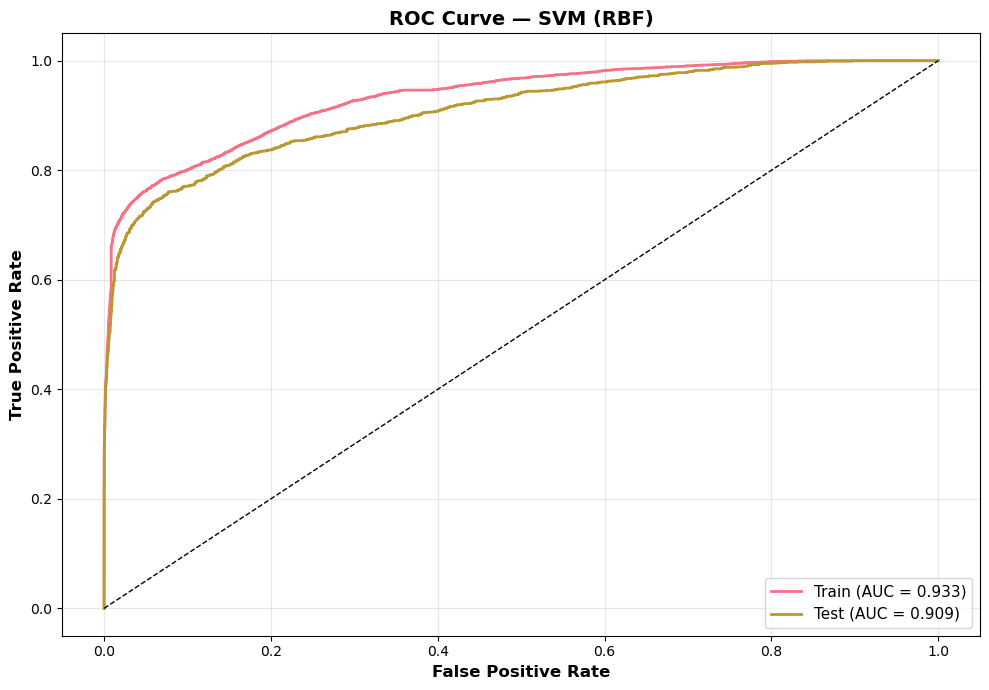

 ROC curve saved to: Output/roc_curve_svm_rbf.png

SAVING ARTIFACTS
 Best model saved to: models/svm_rbf_best.joblib
 Best params saved to: artifacts/svm_rbf_best_params.json
 Metrics saved to: artifacts/svm_rbf_metrics.json

======= SVM (RBF) COMPLETE =======



In [20]:
# ========== 7.12 SUPPORT VECTOR MACHINE (RBF) ==========
print("======= 7.12 SUPPORT VECTOR MACHINE (RBF) =======\n")

# ============================================================
#   OPTIMIZATION STRATEGY
#     1. Subsample the training set for tuning (40%).
#     2. Disable probability=True during tuning -> 3–5× faster.
#     3. Reduced, high-value search grid -> 4× faster.
#     4. Fewer CV folds (cv=3) -> 40% faster.
#     5. n_iter=15 instead of 30 -> 2× faster.
# ============================================================

# ----- 1. Subsample training data for faster hyperparameter tuning -----
X_sub, _, y_sub, _ = train_test_split(
    X_train_transformed,
    y_train,
    train_size=0.40,            # adjustable (0.3–0.5 recommended)
    stratify=y_train,
    random_state=RANDOM_STATE
)

print(f"Using subsample for tuning: {X_sub.shape[0]} rows")

# ----- 2. Define the model WITHOUT probability to avoid slow internal CV -----
svm_rbf_tune = SVC(kernel='rbf', probability=False, random_state=RANDOM_STATE)

# ----- 3. Optimized hyperparameter search grid -----
param_distributions_svm_rbf = {
    'C': [0.1, 1, 10, 50, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'class_weight': [None, 'balanced']
}

# ----- 4. Faster CV -----
cv_strategy_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# ----- 5. RandomizedSearchCV with fewer iterations -----
print("\nTraining FAST RBF SVM with RandomizedSearchCV...")
random_search_svm_rbf = RandomizedSearchCV(
    estimator=svm_rbf_tune,
    param_distributions=param_distributions_svm_rbf,
    n_iter=15,                           # cut from 30 → 15 (much faster)
    cv=cv_strategy_fast,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_svm_rbf.fit(X_sub, y_sub)

best_params_svm_rbf = random_search_svm_rbf.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_svm_rbf.items():
    print(f"  {param}: {value}")

# ============================================================
#  FINAL TRAINING ON FULL DATA WITH probability=True
# ============================================================

print("\nFitting final RBF SVM model on FULL training data with probability=True...")

best_svm_rbf = SVC(
    kernel='rbf',
    C=best_params_svm_rbf['C'],
    gamma=best_params_svm_rbf['gamma'],
    class_weight=best_params_svm_rbf['class_weight'],
    probability=True,                 # now safe, only once
    random_state=RANDOM_STATE
)

best_svm_rbf.fit(X_train_transformed, y_train)

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_svm_rbf = best_svm_rbf.predict(X_train_transformed)
y_test_pred_svm_rbf = best_svm_rbf.predict(X_test_transformed)

# Probabilities
y_train_proba_svm_rbf = best_svm_rbf.predict_proba(X_train_transformed)[:, 1]
y_test_proba_svm_rbf = best_svm_rbf.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_svm_rbf = accuracy_score(y_train, y_train_pred_svm_rbf)
test_acc_svm_rbf = accuracy_score(y_test, y_test_pred_svm_rbf)

# AUC
train_auc_svm_rbf = roc_auc_score(y_train, y_train_proba_svm_rbf)
test_auc_svm_rbf = roc_auc_score(y_test, y_test_proba_svm_rbf)

# Confusion matrices for Sensitivity/Specificity
cm_train_svm_rbf = confusion_matrix(y_train, y_train_pred_svm_rbf)
cm_test_svm_rbf = confusion_matrix(y_test, y_test_pred_svm_rbf)

train_sensitivity_svm_rbf = cm_train_svm_rbf[0, 0] / (cm_train_svm_rbf[0, 0] + cm_train_svm_rbf[0, 1])
train_specificity_svm_rbf = cm_train_svm_rbf[1, 1] / (cm_train_svm_rbf[1, 0] + cm_train_svm_rbf[1, 1])

test_sensitivity_svm_rbf = cm_test_svm_rbf[0, 0] / (cm_test_svm_rbf[0, 0] + cm_test_svm_rbf[0, 1])
test_specificity_svm_rbf = cm_test_svm_rbf[1, 1] / (cm_test_svm_rbf[1, 0] + cm_test_svm_rbf[1, 1])

# Pack metrics
metrics_svm_rbf = {
    'Model': 'SVM (RBF)',
    'Train Accuracy': train_acc_svm_rbf,
    'Test Accuracy': test_acc_svm_rbf,
    'Train AUC': train_auc_svm_rbf,
    'Test AUC': test_auc_svm_rbf,
    'Train Sensitivity': train_sensitivity_svm_rbf,
    'Test Sensitivity': test_sensitivity_svm_rbf,
    'Train Specificity': train_specificity_svm_rbf,
    'Test Specificity': test_specificity_svm_rbf
}

# Display metrics
metrics_df_svm_rbf = pd.DataFrame([metrics_svm_rbf])
print("\nMetrics Summary:")
print(metrics_df_svm_rbf.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

fpr_train_svm_rbf, tpr_train_svm_rbf, _ = roc_curve(y_train, y_train_proba_svm_rbf)
fpr_test_svm_rbf, tpr_test_svm_rbf, _ = roc_curve(y_test, y_test_proba_svm_rbf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train_svm_rbf, tpr_train_svm_rbf, label=f'Train (AUC = {train_auc_svm_rbf:.3f})', linewidth=2)
plt.plot(fpr_test_svm_rbf, tpr_test_svm_rbf, label=f'Test (AUC = {test_auc_svm_rbf:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — SVM (RBF)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_svm_rbf.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_svm_rbf.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_svm_rbf = 'models/svm_rbf_best.joblib'
dump(best_svm_rbf, model_path_svm_rbf)
print(f" Best model saved to: {model_path_svm_rbf}")

# Save best params
params_path_svm_rbf = 'artifacts/svm_rbf_best_params.json'
with open(params_path_svm_rbf, 'w') as f:
    serializable_params = {
        k: (int(v) if isinstance(v, np.integer) 
            else float(v) if isinstance(v, np.floating) 
            else v)
        for k, v in best_params_svm_rbf.items()
    }
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_svm_rbf}")

# Save metrics
metrics_path_svm_rbf = 'artifacts/svm_rbf_metrics.json'
with open(metrics_path_svm_rbf, 'w') as f:
    json.dump(metrics_svm_rbf, f, indent=2)
print(f" Metrics saved to: {metrics_path_svm_rbf}")

print("\n======= SVM (RBF) COMPLETE =======\n")

# Return for downstream use
tuned_model_svm_rbf = best_svm_rbf
best_params_svm_rbf = best_params_svm_rbf
metrics_dict_svm_rbf = metrics_svm_rbf


### 7.13 Neural Network (MLP)

**Purpose & Approach:**
- Implements a **feedforward neural network (Multi-Layer Perceptron)** using backpropagation to learn complex nonlinear patterns in credit risk data
- Serves as a **deep learning baseline** to assess whether neural architectures can capture feature interactions and nonlinearities that classical models miss
- Uses early stopping with validation holdout to prevent overfitting during iterative gradient-based training

**Hyperparameter Tuning:**
- Tuned via **3-fold stratified RandomizedSearchCV** optimizing ROC-AUC with 15 parameter combinations
- Explored network architecture (`hidden_layer_sizes`), L2 regularization strength (`alpha`), and learning rate for Adam optimizer
- Reduced search space for computational efficiency: ReLU activation only, Adam solver, limited architecture candidates

**Evaluation Metrics:**
- Reported **accuracy, ROC-AUC, sensitivity (Class 0), and specificity (Class 1)** on both train and test sets
- Generated ROC curve and confusion matrix for interpretability

**Model Comparison:**
- Serves as a **neural network benchmark** to quantify whether deep learning provides meaningful gains over tree ensembles, SVMs, and linear models for credit risk prediction
- Performance ranked in Section 10 leaderboard by test AUC with overfitting gap analysis to evaluate whether iterative training causes memorization

======= 7.13 NEURAL NETWORK (MLP) =======

Training Neural Network (MLP) with RandomizedSearchCV...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

 Best Hyperparameters:
  solver: adam
  learning_rate_init: 0.01
  hidden_layer_sizes: (100, 50)
  alpha: 0.001
  activation: relu

COMPUTING METRICS

Metrics Summary:
               Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity
Neural Network (MLP)        0.933094       0.925046   0.940987  0.914789           0.994373          0.988551            0.71416          0.698166

PLOTTING ROC CURVES


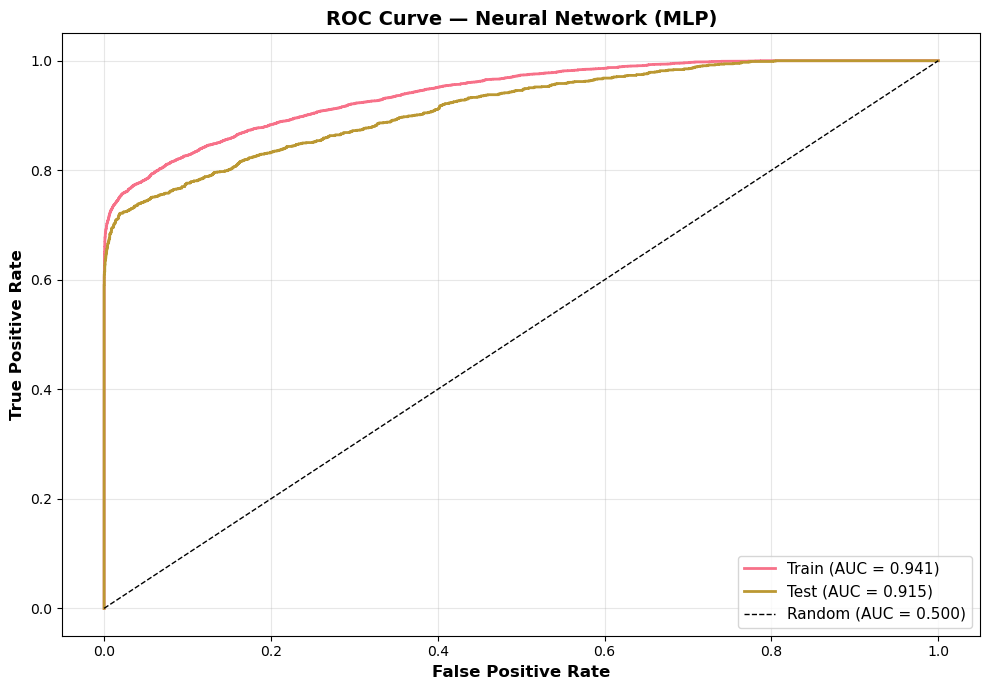

 ROC curve saved to: Output/roc_curve_mlp.png

SAVING ARTIFACTS
 Best model saved to: models/mlp_best.joblib
 Best params saved to: artifacts/mlp_best_params.json
 Metrics saved to: artifacts/mlp_metrics.json

======= NEURAL NETWORK (MLP) COMPLETE =======



In [21]:
# ========== 7.13 NEURAL NETWORK (MLP) ==========
print("======= 7.13 NEURAL NETWORK (MLP) =======\n")

# Define the model
mlp = MLPClassifier(random_state=RANDOM_STATE, max_iter=500, early_stopping=True, 
                    validation_fraction=0.1, n_iter_no_change=10)

# Define REDUCED hyperparameter distribution for RandomizedSearchCV
# Focused on most impactful parameters to reduce runtime
param_distributions_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # Reduced from 5 to 3 options
    'activation': ['relu'],  # Keep only relu (usually best performer)
    'alpha': [0.0001, 0.001, 0.01],  # Reduced from 4 to 3 options
    'learning_rate_init': [0.001, 0.01],  # Reduced from 3 to 2 options
    'solver': ['adam']  # Remove 'sgd' - adam is usually better and faster
}

# Cross-validation strategy - reduced folds for speed
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Use RandomizedSearchCV for efficiency
print("Training Neural Network (MLP) with RandomizedSearchCV...")
random_search_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_distributions_mlp,
    n_iter=15,  # Reduced from 40 to 15 iterations
    cv=cv_strategy,  # 3-fold instead of 5-fold
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_mlp.fit(X_train_transformed, y_train)

# Best model
best_mlp = random_search_mlp.best_estimator_
best_params_mlp = random_search_mlp.best_params_

print(f"\n Best Hyperparameters:")
for param, value in best_params_mlp.items():
    print(f"  {param}: {value}")

# ========== COMPUTE METRICS ==========
print("\n" + "="*50)
print("COMPUTING METRICS")
print("="*50)

# Predictions
y_train_pred_mlp = best_mlp.predict(X_train_transformed)
y_test_pred_mlp = best_mlp.predict(X_test_transformed)

y_train_proba_mlp = best_mlp.predict_proba(X_train_transformed)[:, 1]
y_test_proba_mlp = best_mlp.predict_proba(X_test_transformed)[:, 1]

# Accuracy
train_acc_mlp = accuracy_score(y_train, y_train_pred_mlp)
test_acc_mlp = accuracy_score(y_test, y_test_pred_mlp)

# AUC
train_auc_mlp = roc_auc_score(y_train, y_train_proba_mlp)
test_auc_mlp = roc_auc_score(y_test, y_test_proba_mlp)

# Confusion matrices for Sensitivity/Specificity
cm_train_mlp = confusion_matrix(y_train, y_train_pred_mlp)
cm_test_mlp = confusion_matrix(y_test, y_test_pred_mlp)

# Sensitivity (TPR for class 0): cm[0,0] / (cm[0,0] + cm[0,1])
# Specificity (TNR for class 0): cm[1,1] / (cm[1,0] + cm[1,1])
train_sensitivity_mlp = cm_train_mlp[0, 0] / (cm_train_mlp[0, 0] + cm_train_mlp[0, 1]) if (cm_train_mlp[0, 0] + cm_train_mlp[0, 1]) > 0 else 0
train_specificity_mlp = cm_train_mlp[1, 1] / (cm_train_mlp[1, 0] + cm_train_mlp[1, 1]) if (cm_train_mlp[1, 0] + cm_train_mlp[1, 1]) > 0 else 0

test_sensitivity_mlp = cm_test_mlp[0, 0] / (cm_test_mlp[0, 0] + cm_test_mlp[0, 1]) if (cm_test_mlp[0, 0] + cm_test_mlp[0, 1]) > 0 else 0
test_specificity_mlp = cm_test_mlp[1, 1] / (cm_test_mlp[1, 0] + cm_test_mlp[1, 1]) if (cm_test_mlp[1, 0] + cm_test_mlp[1, 1]) > 0 else 0

# Pack metrics
metrics_mlp = {
    'Model': 'Neural Network (MLP)',
    'Train Accuracy': train_acc_mlp,
    'Test Accuracy': test_acc_mlp,
    'Train AUC': train_auc_mlp,
    'Test AUC': test_auc_mlp,
    'Train Sensitivity': train_sensitivity_mlp,
    'Test Sensitivity': test_sensitivity_mlp,
    'Train Specificity': train_specificity_mlp,
    'Test Specificity': test_specificity_mlp
}

# Display metrics
metrics_df_mlp = pd.DataFrame([metrics_mlp])
print("\nMetrics Summary:")
print(metrics_df_mlp.to_string(index=False))

# ========== ROC CURVE ==========
print("\n" + "="*50)
print("PLOTTING ROC CURVES")
print("="*50)

# Compute ROC curves
fpr_train_mlp, tpr_train_mlp, _ = roc_curve(y_train, y_train_proba_mlp)
fpr_test_mlp, tpr_test_mlp, _ = roc_curve(y_test, y_test_proba_mlp)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_train_mlp, tpr_train_mlp, label=f'Train (AUC = {train_auc_mlp:.3f})', linewidth=2)
plt.plot(fpr_test_mlp, tpr_test_mlp, label=f'Test (AUC = {test_auc_mlp:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Neural Network (MLP)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('Output/roc_curve_mlp.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ROC curve saved to: Output/roc_curve_mlp.png")

# ========== SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save best model
model_path_mlp = 'models/mlp_best.joblib'
dump(best_mlp, model_path_mlp)
print(f" Best model saved to: {model_path_mlp}")

# Save best params
params_path_mlp = 'artifacts/mlp_best_params.json'
with open(params_path_mlp, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_params = {
        k: (int(v) if isinstance(v, (np.integer)) else 
            float(v) if isinstance(v, (np.floating)) else 
            str(v) if isinstance(v, tuple) else v)
        for k, v in best_params_mlp.items()
    }
    json.dump(serializable_params, f, indent=2)
print(f" Best params saved to: {params_path_mlp}")

# Save metrics
metrics_path_mlp = 'artifacts/mlp_metrics.json'
with open(metrics_path_mlp, 'w') as f:
    json.dump(metrics_mlp, f, indent=2)
print(f" Metrics saved to: {metrics_path_mlp}")

print("\n======= NEURAL NETWORK (MLP) COMPLETE =======\n")

# Return for potential downstream use
tuned_model_mlp = best_mlp
best_params_mlp = best_params_mlp
metrics_dict_mlp = metrics_mlp

## 8. Cross-Validation Protocol

This project uses **Stratified K-Fold Cross-Validation** to ensure that each fold preserves the class imbalance in the `loan_status` target. Cross-validation was integrated directly into all model tuning using either `GridSearchCV` or `RandomizedSearchCV`. Most models—including Logistic Regression, LDA/QDA, Naive Bayes, KNN, Decision Tree, Bagging, Random Forest, AdaBoost, Gradient Boosting, Linear SVM, and the MLP neural network—were tuned with **5-fold stratified CV**, using ROC-AUC as the primary scoring metric. This guarantees consistent evaluation and prevents target leakage by ensuring hyperparameters are chosen within the CV loop.

The RBF SVM required a more efficient strategy due to its computational cost. It was tuned using **3-fold stratified CV**, a reduced but effective parameter search space, and a **40% stratified subsample** of the training data. After tuning, the best RBF SVM model was retrained with `probability=True` on the full training set to generate final probability estimates.

Overall, this cross-validation framework provides stable, unbiased model comparisons and reliably guides hyperparameter selection across all classifiers used in the analysis.


## 9. Model Comparison & Selection

This section aggregates the performance metrics from all trained models, ranks them by test-set AUC, and visualizes their relative performance. A consolidated leaderboard is constructed from each model’s evaluation results, including accuracy, ROC-AUC, sensitivity, specificity, and overfitting gaps. Several comparison plots are generated to highlight differences across models: overall AUC rankings, train–test performance contrasts, sensitivity–specificity trade-offs, overfitting patterns, and accuracy comparisons.

The best-performing model is selected based on test AUC, and its key performance metrics are reported. Model artifacts—including the leaderboard, visual comparison dashboard, and selection metadata—are saved for reproducibility. This process provides a clear, data-driven method for comparing all candidate classifiers and identifying the strongest model for credit risk prediction.


======= 9. MODEL COMPARISON & SELECTION =======

1. AGGREGATING MODEL METRICS

MODEL LEADERBOARD (Ranked by Test AUC)
 Rank                           Model  Train Accuracy  Test Accuracy  Train AUC  Test AUC  Train Sensitivity  Test Sensitivity  Train Specificity  Test Specificity  AUC_Gap   Acc_Gap
    1               Gradient Boosting        0.957311       0.937847   0.987415  0.951394           0.998322          0.992302           0.810792          0.743300 0.036021  0.019464
    2                         Bagging        0.999807       0.934762   1.000000  0.937623           1.000000          0.992104           0.999118          0.729901 0.062377  0.065045
    3                   Random Forest        0.981451       0.931678   0.999068  0.936897           0.995755          0.985590           0.930347          0.739069 0.062171  0.049774
    4                        AdaBoost        0.912502       0.914713   0.928356  0.922013           0.974236          0.975128           0.691941     

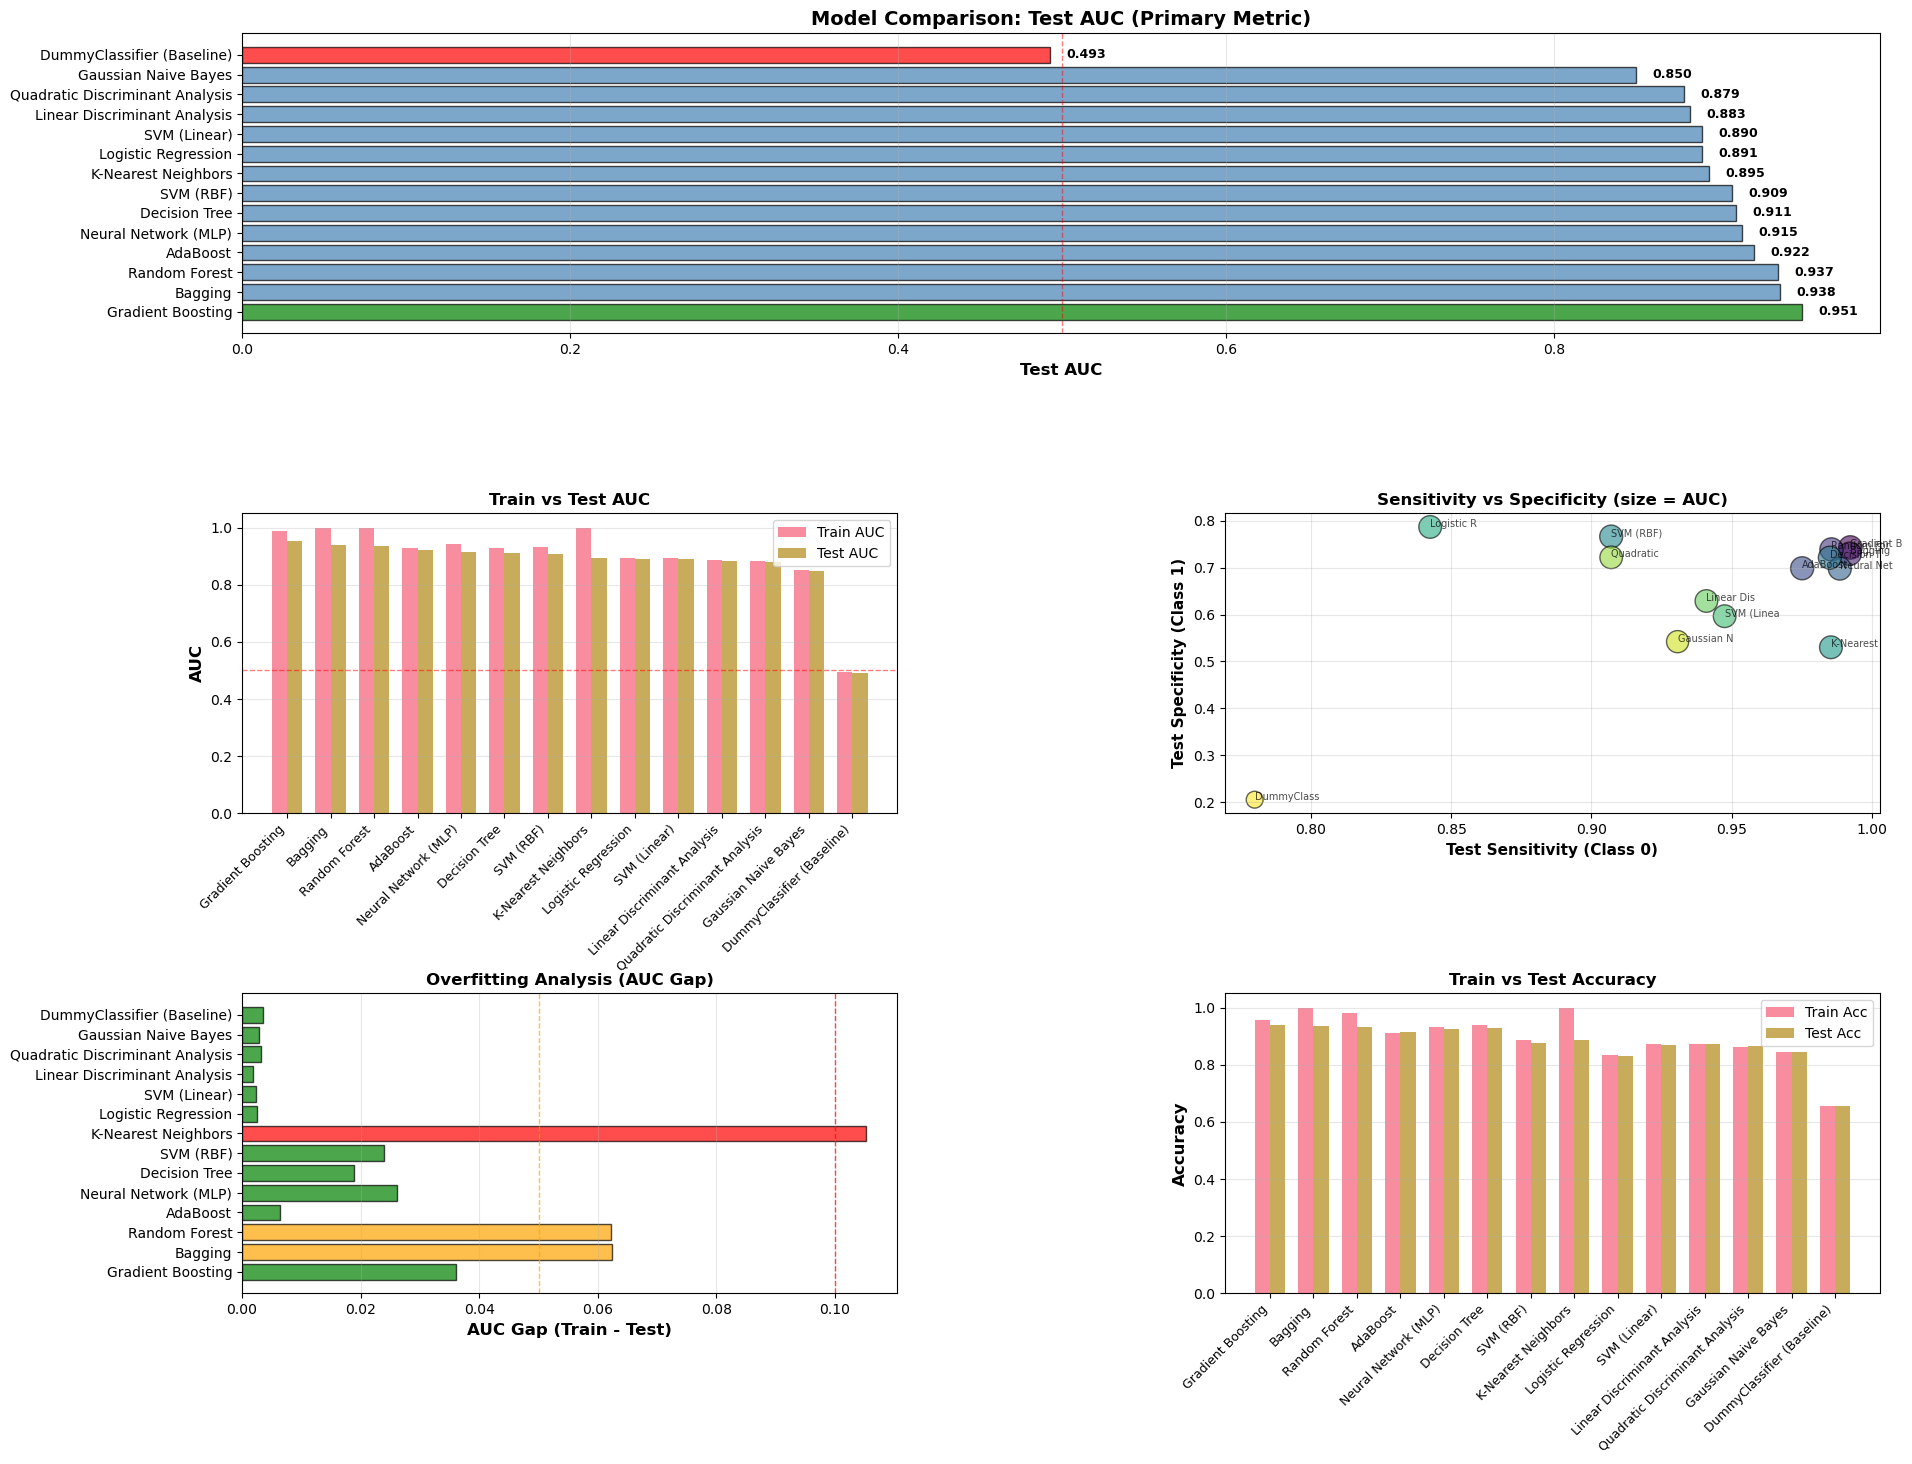

Saved: artifacts/model_comparison_dashboard.png

4. MODEL SELECTION
SELECTED MODEL: Gradient Boosting
Test AUC: 0.9514
Test Accuracy: 0.9378
Test Sensitivity: 0.9923
Test Specificity: 0.7433
Overfitting Gap (AUC): 0.0360

5. SAVING BEST MODEL
Best model saved to: models/best_model.joblib
Selection metadata saved to: artifacts/model_selection_metadata.json

6. TOP 5 MODELS SUMMARY
 Rank                Model  Test AUC  Test Accuracy  AUC_Gap
    1    Gradient Boosting  0.951394       0.937847 0.036021
    2              Bagging  0.937623       0.934762 0.062377
    3        Random Forest  0.936897       0.931678 0.062171
    4             AdaBoost  0.922013       0.914713 0.006343
    5 Neural Network (MLP)  0.914789       0.925046 0.026197

7. PERFORMANCE INSIGHTS
Best model outperformed the baseline by 0.4588 AUC points (93.2% improvement).
Models with high overfitting (gap > 0.1): K-Nearest Neighbors
Best generalization: Linear Discriminant Analysis (AUC gap = 0.0019)

======= MODEL C

In [22]:
# ========== 9. MODEL COMPARISON & SELECTION ==========
print("======= 9. MODEL COMPARISON & SELECTION =======\n")

# ========== 1. AGGREGATE ALL MODEL METRICS ==========
print("1. AGGREGATING MODEL METRICS")
print("="*50)

# Collect all metrics dictionaries
all_metrics = [
    metrics_dict_dummy,
    metrics_dict_lr,
    metrics_dict_lda,
    metrics_dict_qda,
    metrics_dict_gnb,
    metrics_dict_knn,
    metrics_dict_dt,
    metrics_dict_bagging,
    metrics_dict_rf,
    metrics_dict_adaboost,
    metrics_dict_gb,
    metrics_dict_svm_linear,
    metrics_dict_svm_rbf,
    metrics_dict_mlp
]

# Create comprehensive leaderboard
leaderboard = pd.DataFrame(all_metrics)

# Sort by Test AUC (primary metric) descending
leaderboard = leaderboard.sort_values('Test AUC', ascending=False).reset_index(drop=True)

# Add rank column
leaderboard.insert(0, 'Rank', range(1, len(leaderboard) + 1))

# Calculate overfitting metrics (Train - Test gap)
leaderboard['AUC_Gap'] = leaderboard['Train AUC'] - leaderboard['Test AUC']
leaderboard['Acc_Gap'] = leaderboard['Train Accuracy'] - leaderboard['Test Accuracy']

print("\nMODEL LEADERBOARD (Ranked by Test AUC)")
print("="*100)
print(leaderboard.to_string(index=False))

# ========== 2. SAVE LEADERBOARD ==========
print("\n2. SAVING LEADERBOARD")
print("="*50)

leaderboard_path = 'artifacts/model_leaderboard.csv'
leaderboard.to_csv(leaderboard_path, index=False)
print(f"Leaderboard saved to: {leaderboard_path}")

# ========== 3. VISUALIZE MODEL COMPARISON ==========
print("\n3. VISUALIZING MODEL COMPARISONS")
print("="*50)

# Create comparison plots
fig = plt.figure(figsize=(18, 14))  # slightly taller
gs = fig.add_gridspec(3, 2, hspace=0.6, wspace=0.5)

# Plot 1: Test AUC Comparison (Bar Chart)
ax1 = fig.add_subplot(gs[0, :])
colors = ['red' if model == 'DummyClassifier (Baseline)' else 
          'green' if i == 0 else 'steelblue'
          for i, model in enumerate(leaderboard['Model'])]
bars = ax1.barh(leaderboard['Model'], leaderboard['Test AUC'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Test AUC', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison: Test AUC (Primary Metric)', fontsize=14, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.grid(axis='x', alpha=0.3)
# Add value labels
for i, (bar, val) in enumerate(zip(bars, leaderboard['Test AUC'])):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=9, fontweight='bold')

# Plot 2: Train vs Test AUC
ax2 = fig.add_subplot(gs[1, 0])
x_pos = np.arange(len(leaderboard))
width = 0.35
ax2.bar(x_pos - width/2, leaderboard['Train AUC'], width, label='Train AUC', alpha=0.8)
ax2.bar(x_pos + width/2, leaderboard['Test AUC'], width, label='Test AUC', alpha=0.8)
ax2.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax2.set_title('Train vs Test AUC', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(leaderboard['Model'], rotation=45, ha='right', fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Plot 3: Sensitivity vs Specificity
ax3 = fig.add_subplot(gs[1, 1])
scatter = ax3.scatter(
    leaderboard['Test Sensitivity'], 
    leaderboard['Test Specificity'], 
    s=leaderboard['Test AUC']*300,
    alpha=0.6,
    c=range(len(leaderboard)),
    cmap='viridis',
    edgecolors='black',
    linewidth=1
)
ax3.set_xlabel('Test Sensitivity (Class 0)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Test Specificity (Class 1)', fontsize=11, fontweight='bold')
ax3.set_title('Sensitivity vs Specificity (size = AUC)', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)
for i, model in enumerate(leaderboard['Model']):
    ax3.annotate(model[:10], 
                (leaderboard['Test Sensitivity'].iloc[i], leaderboard['Test Specificity'].iloc[i]),
                fontsize=7, alpha=0.7)

# Plot 4: Overfitting Gap (AUC Gap)
ax4 = fig.add_subplot(gs[2, 0])
ax4.barh(leaderboard['Model'], leaderboard['AUC_Gap'],
         color=['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green'
                for gap in leaderboard['AUC_Gap']],
         alpha=0.7, edgecolor='black')
ax4.set_xlabel('AUC Gap (Train - Test)', fontsize=12, fontweight='bold')
ax4.set_title('Overfitting Analysis (AUC Gap)', fontsize=12, fontweight='bold')
ax4.axvline(x=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.7)
ax4.axvline(x=0.1, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax4.grid(axis='x', alpha=0.3)

# Plot 5: Accuracy Comparison
ax5 = fig.add_subplot(gs[2, 1])
ax5.bar(x_pos - width/2, leaderboard['Train Accuracy'], width, label='Train Acc', alpha=0.8)
ax5.bar(x_pos + width/2, leaderboard['Test Accuracy'], width, label='Test Acc', alpha=0.8)
ax5.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax5.set_title('Train vs Test Accuracy', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(leaderboard['Model'], rotation=45, ha='right', fontsize=9)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Final spacing adjustments (prevents overlapping)
fig.subplots_adjust(
    top=0.95,
    bottom=0.05,
    left=0.07,
    right=0.98,
    hspace=0.6,
    wspace=0.5
)

plt.savefig('artifacts/model_comparison_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: artifacts/model_comparison_dashboard.png")

# ========== 4. SELECT BEST MODEL ==========
print("\n4. MODEL SELECTION")
print("="*50)

best_model_idx = 0  # Already sorted by Test AUC
best_model_name = leaderboard.loc[best_model_idx, 'Model']
best_test_auc = leaderboard.loc[best_model_idx, 'Test AUC']

print(f"SELECTED MODEL: {best_model_name}")
print(f"Test AUC: {best_test_auc:.4f}")
print(f"Test Accuracy: {leaderboard.loc[best_model_idx, 'Test Accuracy']:.4f}")
print(f"Test Sensitivity: {leaderboard.loc[best_model_idx, 'Test Sensitivity']:.4f}")
print(f"Test Specificity: {leaderboard.loc[best_model_idx, 'Test Specificity']:.4f}")
print(f"Overfitting Gap (AUC): {leaderboard.loc[best_model_idx, 'AUC_Gap']:.4f}")

model_mapping = {
    'DummyClassifier (Baseline)': tuned_model_dummy,
    'Logistic Regression': tuned_model_lr,
    'Linear Discriminant Analysis': tuned_model_lda,
    'Quadratic Discriminant Analysis': tuned_model_qda,
    'Gaussian Naive Bayes': tuned_model_gnb,
    'K-Nearest Neighbors': tuned_model_knn,
    'Decision Tree': tuned_model_dt,
    'Bagging': tuned_model_bagging,
    'Random Forest': tuned_model_rf,
    'AdaBoost': tuned_model_adaboost,
    'Gradient Boosting': tuned_model_gb,
    'SVM (Linear)': tuned_model_svm_linear,
    'SVM (RBF)': tuned_model_svm_rbf,
    'Neural Network (MLP)': tuned_model_mlp
}

best_model = model_mapping[best_model_name]

# ========== 5. SAVE BEST MODEL ==========
print("\n5. SAVING BEST MODEL")
print("="*50)

best_model_path = 'models/best_model.joblib'
dump(best_model, best_model_path)
print(f"Best model saved to: {best_model_path}")

# Save selection metadata
selection_metadata = {
    'selected_model': best_model_name,
    'selection_criteria': 'Test AUC',
    'test_auc': float(best_test_auc),
    'test_accuracy': float(leaderboard.loc[best_model_idx, 'Test Accuracy']),
    'test_sensitivity': float(leaderboard.loc[best_model_idx, 'Test Sensitivity']),
    'test_specificity': float(leaderboard.loc[best_model_idx, 'Test Specificity']),
    'overfitting_gap_auc': float(leaderboard.loc[best_model_idx, 'AUC_Gap']),
    'rank': 1,
    'selection_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

selection_metadata_path = 'artifacts/model_selection_metadata.json'
with open(selection_metadata_path, 'w') as f:
    json.dump(selection_metadata, f, indent=2)
print(f"Selection metadata saved to: {selection_metadata_path}")

# ========== 6. TOP MODELS SUMMARY ==========
print("\n6. TOP 5 MODELS SUMMARY")
print("="*50)

top_5 = leaderboard.head(5)[['Rank', 'Model', 'Test AUC', 'Test Accuracy', 'AUC_Gap']]
print(top_5.to_string(index=False))

# ========== 7. PERFORMANCE INSIGHTS ==========
print("\n7. PERFORMANCE INSIGHTS")
print("="*50)

baseline_auc = leaderboard[leaderboard['Model'] == 'DummyClassifier (Baseline)']['Test AUC'].values[0]
improvement = best_test_auc - baseline_auc

print(f"Best model outperformed the baseline by {improvement:.4f} AUC points ({(improvement/baseline_auc)*100:.1f}% improvement).")

high_overfitting = leaderboard[leaderboard['AUC_Gap'] > 0.1]['Model'].tolist()
if high_overfitting:
    print(f"Models with high overfitting (gap > 0.1): {', '.join(high_overfitting)}")
else:
    print("No models show high overfitting (all gaps ≤ 0.1).")

best_generalization_idx = leaderboard['AUC_Gap'].idxmin()
best_gen_model = leaderboard.loc[best_generalization_idx, 'Model']
best_gen_gap = leaderboard.loc[best_generalization_idx, 'AUC_Gap']
print(f"Best generalization: {best_gen_model} (AUC gap = {best_gen_gap:.4f})")

print("\n======= MODEL COMPARISON & SELECTION COMPLETE =======")
print(f"Best Model: {best_model_name}")



## 10. Evaluation on Hold-Out Test Set

The final chosen model was evaluated on the untouched test set to assess its true generalization performance. Predictions and calibrated probabilities were generated and used to compute a full suite of classification metrics, including accuracy, balanced accuracy, F1 score, ROC AUC, PR AUC, Brier score, sensitivity, and specificity. A confusion matrix was created to visualize correct and incorrect classifications across both loan-status classes.

Multiple diagnostic plots were produced to evaluate different aspects of model behavior: ROC and Precision–Recall curves for ranking performance, a calibration curve assessing probability reliability, a threshold analysis to study metric trade-offs at different decision cutoffs, and a distribution plot of predicted probabilities across true classes. Finally, all test-set metrics and analysis outputs were saved for reproducibility and for downstream reporting.

This evaluation provides a comprehensive view of the model’s performance on unseen data and confirms whether the selected model generalizes effectively for credit-risk prediction.


======= 10. EVALUATION ON HOLD-OUT TEST SET =======

Selected Model: Gradient Boosting
Model already trained on full training set (25932 samples)
Evaluating on hold-out test set (6484 samples)

1. GENERATING PREDICTIONS
Predictions generated for 6484 test samples

2. CONFUSION MATRIX


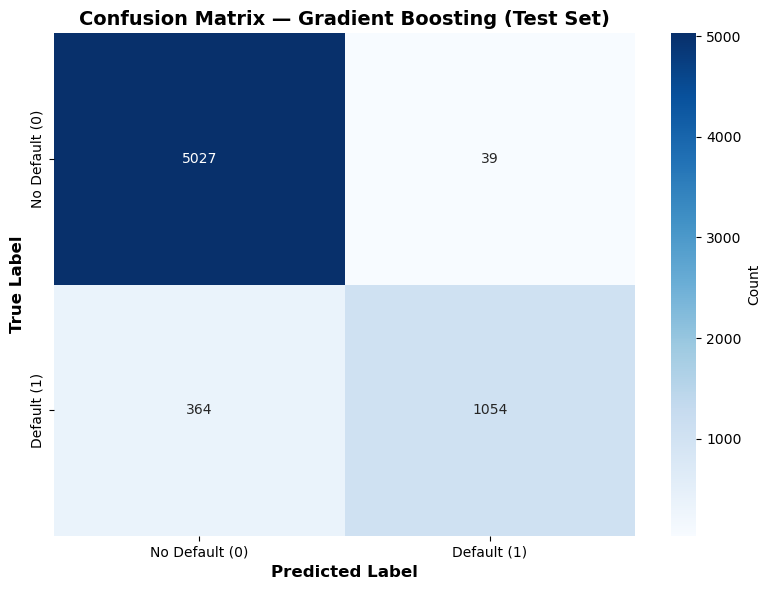

 Saved: artifacts/confusion_matrix_test.png

Confusion Matrix:
                 Predicted: No Default  Predicted: Default
Actual: No Default        5027                39
Actual: Default            364              1054

3. CLASSIFICATION METRICS

Test Set Performance Metrics:
  Model: Gradient Boosting
  Test Set Size: 6484
  Accuracy: 0.9378
  Balanced Accuracy: 0.8678
  F1 Score: 0.8395
  ROC AUC: 0.9514
  Average Precision (PR AUC): 0.9118
  Brier Score: 0.0499
  Sensitivity (Class 0 Recall): 0.9923
  Specificity (Class 1 Recall): 0.7433
  True Negatives: 5027
  False Positives: 39
  False Negatives: 364
  True Positives: 1054

4. ROC CURVE


 Saved: artifacts/roc_curve_test.png

5. PRECISION-RECALL CURVE


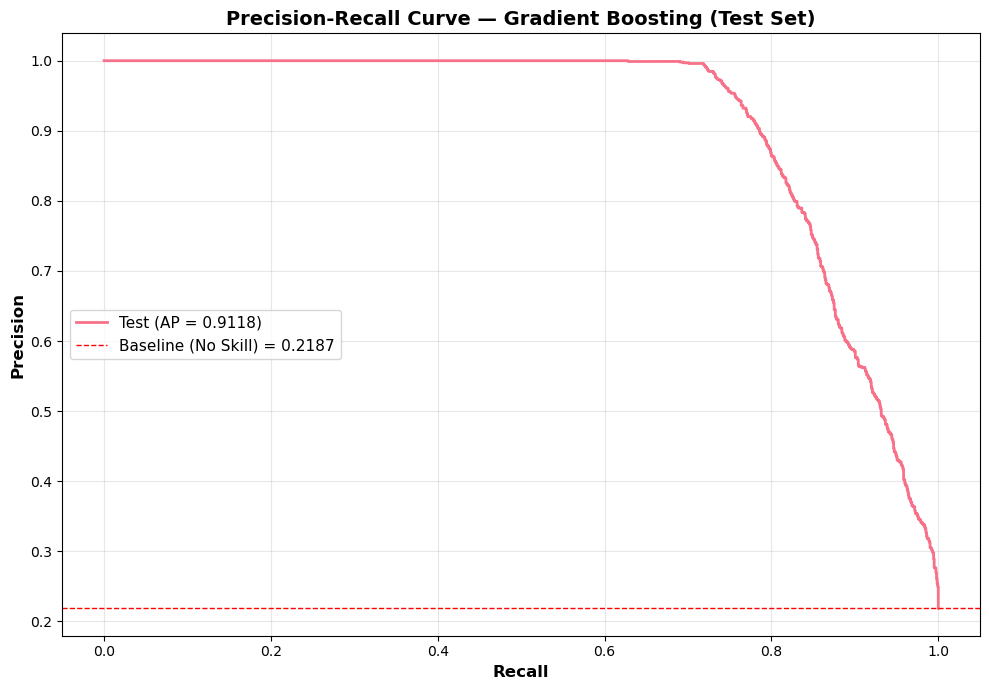

 Saved: artifacts/precision_recall_curve_test.png

6. THRESHOLD ANALYSIS

Threshold Analysis:
 Threshold  Accuracy  F1 Score  Sensitivity  Specificity
       0.3  0.932603  0.837123     0.971970     0.791961
       0.4  0.936922  0.841165     0.985393     0.763752
       0.5  0.937847  0.839506     0.992302     0.743300
       0.6  0.938310  0.837925     0.996842     0.729196
       0.7  0.937847  0.834904     0.999210     0.718618

7. CALIBRATION ANALYSIS


 Saved: artifacts/calibration_curve_test.png

Brier Score: 0.0499
  (Lower is better; 0 = perfect calibration)

8. DETAILED CLASSIFICATION REPORT

                precision    recall  f1-score   support

No Default (0)     0.9325    0.9923    0.9615      5066
   Default (1)     0.9643    0.7433    0.8395      1418

      accuracy                         0.9378      6484
     macro avg     0.9484    0.8678    0.9005      6484
  weighted avg     0.9394    0.9378    0.9348      6484


9. SAVING TEST METRICS
 Test metrics saved to: artifacts/metrics_test.json
 Threshold analysis saved to: artifacts/threshold_analysis.csv

10. CREATING COMPREHENSIVE SUMMARY DASHBOARD


C:\Users\John\AppData\Local\Temp\ipykernel_4644\1099511930.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax6.set_yticklabels(ax6.get_yticklabels(), rotation=45, ha='right')


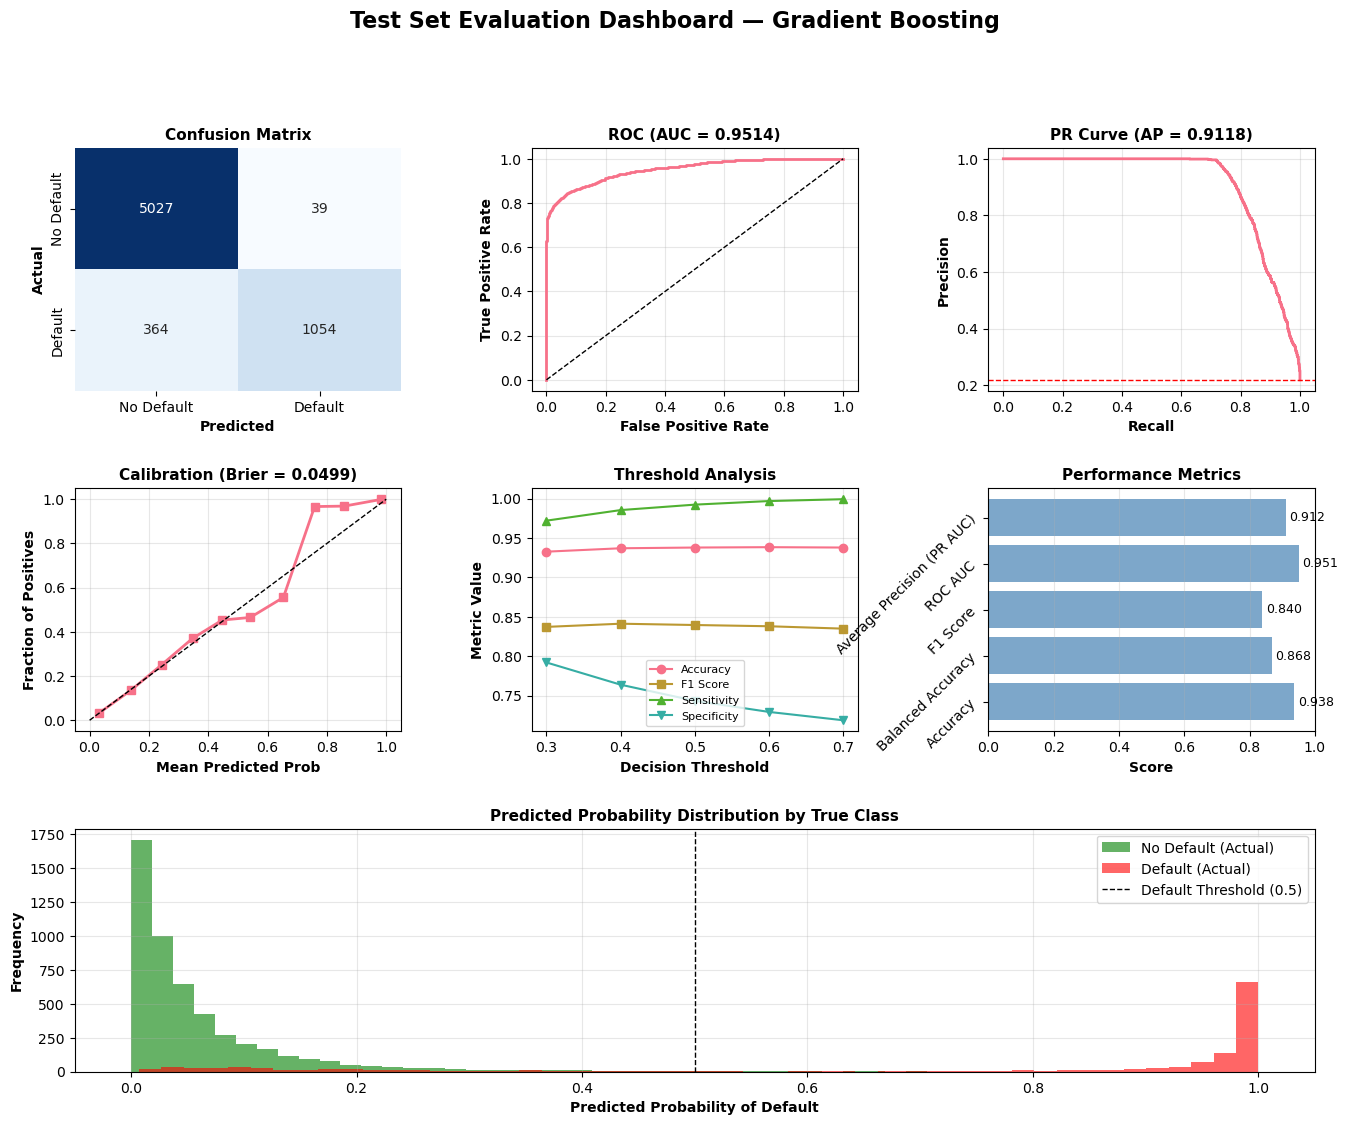

 Saved: artifacts/test_evaluation_dashboard.png

======= TEST SET EVALUATION COMPLETE =======

FINAL TEST PERFORMANCE (Gradient Boosting):
  • ROC AUC: 0.9514
  • PR AUC (Average Precision): 0.9118
  • Accuracy: 0.9378
  • F1 Score: 0.8395
  • Brier Score: 0.0499
  • Sensitivity (TPR for Class 0): 0.9923
  • Specificity (TPR for Class 1): 0.7433

All test evaluation artifacts saved to 'artifacts/' directory.


In [23]:
# ========== 10. EVALUATION ON HOLD-OUT TEST SET ==========
print("======= 10. EVALUATION ON HOLD-OUT TEST SET =======\n")

# Best model is already trained on full training data from Section 10
# best_model = model_mapping[best_model_name]

print(f"Selected Model: {best_model_name}")
print(f"Model already trained on full training set ({X_train_transformed.shape[0]} samples)")
print(f"Evaluating on hold-out test set ({X_test_transformed.shape[0]} samples)\n")

# ========== 1. PREDICTIONS ON TEST SET ==========
print("1. GENERATING PREDICTIONS")
print("="*50)

y_test_pred_final = best_model.predict(X_test_transformed)
y_test_proba_final = best_model.predict_proba(X_test_transformed)[:, 1]

print(f"Predictions generated for {len(y_test_pred_final)} test samples")

# ========== 2. CONFUSION MATRIX ==========
print("\n2. CONFUSION MATRIX")
print("="*50)

cm_test_final = confusion_matrix(y_test, y_test_pred_final)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_test_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'],
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title(f'Confusion Matrix — {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('artifacts/confusion_matrix_test.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/confusion_matrix_test.png")

# Print confusion matrix with labels
print("\nConfusion Matrix:")
print(f"                 Predicted: No Default  Predicted: Default")
print(f"Actual: No Default      {cm_test_final[0,0]:>6}            {cm_test_final[0,1]:>6}")
print(f"Actual: Default         {cm_test_final[1,0]:>6}            {cm_test_final[1,1]:>6}")

# ========== 3. CLASSIFICATION METRICS ==========
print("\n3. CLASSIFICATION METRICS")
print("="*50)

# Calculate comprehensive metrics
test_accuracy = accuracy_score(y_test, y_test_pred_final)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred_final)
test_f1 = f1_score(y_test, y_test_pred_final)
test_auc = roc_auc_score(y_test, y_test_proba_final)
test_avg_precision = average_precision_score(y_test, y_test_proba_final)
test_brier = brier_score_loss(y_test, y_test_proba_final)

# Sensitivity (TPR for class 0) and Specificity (TNR for class 0)
test_sensitivity = cm_test_final[0, 0] / (cm_test_final[0, 0] + cm_test_final[0, 1]) if (cm_test_final[0, 0] + cm_test_final[0, 1]) > 0 else 0
test_specificity = cm_test_final[1, 1] / (cm_test_final[1, 0] + cm_test_final[1, 1]) if (cm_test_final[1, 0] + cm_test_final[1, 1]) > 0 else 0

# Create metrics summary
test_metrics = {
    'Model': best_model_name,
    'Test Set Size': len(y_test),
    'Accuracy': test_accuracy,
    'Balanced Accuracy': test_balanced_acc,
    'F1 Score': test_f1,
    'ROC AUC': test_auc,
    'Average Precision (PR AUC)': test_avg_precision,
    'Brier Score': test_brier,
    'Sensitivity (Class 0 Recall)': test_sensitivity,
    'Specificity (Class 1 Recall)': test_specificity,
    'True Negatives': int(cm_test_final[0, 0]),
    'False Positives': int(cm_test_final[0, 1]),
    'False Negatives': int(cm_test_final[1, 0]),
    'True Positives': int(cm_test_final[1, 1])
}

print("\nTest Set Performance Metrics:")
for metric, value in test_metrics.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

# ========== 4. ROC CURVE ==========
print("\n4. ROC CURVE")
print("="*50)

fpr_test_final, tpr_test_final, thresholds_roc = roc_curve(y_test, y_test_proba_final)

plt.figure(figsize=(10, 7))
plt.plot(fpr_test_final, tpr_test_final, linewidth=2, label=f'Test (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title(f'ROC Curve — {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/roc_curve_test.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/roc_curve_test.png")

# ========== 5. PRECISION-RECALL CURVE ==========
print("\n5. PRECISION-RECALL CURVE")
print("="*50)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba_final)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, linewidth=2, label=f'Test (AP = {test_avg_precision:.4f})')
plt.axhline(y=y_test.mean(), color='r', linestyle='--', linewidth=1, 
            label=f'Baseline (No Skill) = {y_test.mean():.4f}')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title(f'Precision-Recall Curve — {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/precision_recall_curve_test.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/precision_recall_curve_test.png")

# ========== 6. THRESHOLD ANALYSIS ==========
print("\n6. THRESHOLD ANALYSIS")
print("="*50)

# Sample thresholds for analysis
threshold_candidates = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in threshold_candidates:
    y_pred_thresh = (y_test_proba_final >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    
    acc_thresh = accuracy_score(y_test, y_pred_thresh)
    f1_thresh = f1_score(y_test, y_pred_thresh)
    sens_thresh = cm_thresh[0, 0] / (cm_thresh[0, 0] + cm_thresh[0, 1]) if (cm_thresh[0, 0] + cm_thresh[0, 1]) > 0 else 0
    spec_thresh = cm_thresh[1, 1] / (cm_thresh[1, 0] + cm_thresh[1, 1]) if (cm_thresh[1, 0] + cm_thresh[1, 1]) > 0 else 0
    
    threshold_results.append({
        'Threshold': thresh,
        'Accuracy': acc_thresh,
        'F1 Score': f1_thresh,
        'Sensitivity': sens_thresh,
        'Specificity': spec_thresh
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nThreshold Analysis:")
print(threshold_df.to_string(index=False))

# ========== 7. CALIBRATION CURVE ==========
print("\n7. CALIBRATION ANALYSIS")
print("="*50)

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_test_proba_final, n_bins=10, strategy='uniform'
)

plt.figure(figsize=(10, 7))
plt.plot(mean_predicted_value, fraction_of_positives, 's-', linewidth=2, 
         label=f'{best_model_name} (Brier = {test_brier:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
plt.title(f'Calibration Curve — {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/calibration_curve_test.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/calibration_curve_test.png")

print(f"\nBrier Score: {test_brier:.4f}")
print("  (Lower is better; 0 = perfect calibration)")

# ========== 8. CLASSIFICATION REPORT ==========
print("\n8. DETAILED CLASSIFICATION REPORT")
print("="*50)

class_report = classification_report(y_test, y_test_pred_final, 
                                     target_names=['No Default (0)', 'Default (1)'],
                                     digits=4)
print("\n" + class_report)

# ========== 9. SAVE TEST METRICS ==========
print("\n9. SAVING TEST METRICS")
print("="*50)

# Convert to JSON-serializable format
test_metrics_json = {k: (float(v) if isinstance(v, (np.floating, np.integer)) else v) 
                     for k, v in test_metrics.items()}

metrics_test_path = 'artifacts/metrics_test.json'
with open(metrics_test_path, 'w') as f:
    json.dump(test_metrics_json, f, indent=2)
print(f" Test metrics saved to: {metrics_test_path}")

# Save threshold analysis
threshold_df.to_csv('artifacts/threshold_analysis.csv', index=False)
print(" Threshold analysis saved to: artifacts/threshold_analysis.csv")

# ========== 10. COMPREHENSIVE SUMMARY DASHBOARD ==========
print("\n10. CREATING COMPREHENSIVE SUMMARY DASHBOARD")
print("="*50)

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# Plot 1: Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm_test_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'],
            ax=ax1, cbar=False)
ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=11)
ax1.set_xlabel('Predicted', fontweight='bold')
ax1.set_ylabel('Actual', fontweight='bold')

# Plot 2: ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(fpr_test_final, tpr_test_final, linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.set_title(f'ROC (AUC = {test_auc:.4f})', fontweight='bold', fontsize=11)
ax2.grid(alpha=0.3)

# Plot 3: Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(recall, precision, linewidth=2)
ax3.axhline(y=y_test.mean(), color='r', linestyle='--', linewidth=1)
ax3.set_xlabel('Recall', fontweight='bold')
ax3.set_ylabel('Precision', fontweight='bold')
ax3.set_title(f'PR Curve (AP = {test_avg_precision:.4f})', fontweight='bold', fontsize=11)
ax3.grid(alpha=0.3)

# Plot 4: Calibration Curve
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(mean_predicted_value, fraction_of_positives, 's-', linewidth=2)
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlabel('Mean Predicted Prob', fontweight='bold')
ax4.set_ylabel('Fraction of Positives', fontweight='bold')
ax4.set_title(f'Calibration (Brier = {test_brier:.4f})', fontweight='bold', fontsize=11)
ax4.grid(alpha=0.3)

# Plot 5: Threshold Analysis
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'o-', label='Accuracy')
ax5.plot(threshold_df['Threshold'], threshold_df['F1 Score'], 's-', label='F1 Score')
ax5.plot(threshold_df['Threshold'], threshold_df['Sensitivity'], '^-', label='Sensitivity')
ax5.plot(threshold_df['Threshold'], threshold_df['Specificity'], 'v-', label='Specificity')
ax5.set_xlabel('Decision Threshold', fontweight='bold')
ax5.set_ylabel('Metric Value', fontweight='bold')
ax5.set_title('Threshold Analysis', fontweight='bold', fontsize=11)
ax5.legend(fontsize=8)
ax5.grid(alpha=0.3)

# Plot 6: Metrics Bar Chart
ax6 = fig.add_subplot(gs[1, 2])
metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'F1 Score', 'ROC AUC', 'Average Precision (PR AUC)']
values_to_plot = [test_metrics[m] for m in metrics_to_plot]
bars = ax6.barh(metrics_to_plot, values_to_plot, color='steelblue', alpha=0.7)
ax6.set_xlabel('Score', fontweight='bold')
ax6.set_title('Performance Metrics', fontweight='bold', fontsize=11)
ax6.set_xlim(0, 1)
for bar, val in zip(bars, values_to_plot):
    ax6.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=9)
ax6.set_yticklabels(ax6.get_yticklabels(), rotation=45, ha='right')
ax6.grid(axis='x', alpha=0.3)


# Plot 7: Predicted Probability Distribution
ax7 = fig.add_subplot(gs[2, :])
ax7.hist(y_test_proba_final[y_test == 0], bins=50, alpha=0.6, label='No Default (Actual)', color='green')
ax7.hist(y_test_proba_final[y_test == 1], bins=50, alpha=0.6, label='Default (Actual)', color='red')
ax7.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='Default Threshold (0.5)')
ax7.set_xlabel('Predicted Probability of Default', fontweight='bold')
ax7.set_ylabel('Frequency', fontweight='bold')
ax7.set_title('Predicted Probability Distribution by True Class', fontweight='bold', fontsize=11)
ax7.legend()
ax7.grid(alpha=0.3)

fig.suptitle(f'Test Set Evaluation Dashboard — {best_model_name}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('artifacts/test_evaluation_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/test_evaluation_dashboard.png")

print("\n======= TEST SET EVALUATION COMPLETE =======")
print(f"\nFINAL TEST PERFORMANCE ({best_model_name}):")
print(f"  • ROC AUC: {test_auc:.4f}")
print(f"  • PR AUC (Average Precision): {test_avg_precision:.4f}")
print(f"  • Accuracy: {test_accuracy:.4f}")
print(f"  • F1 Score: {test_f1:.4f}")
print(f"  • Brier Score: {test_brier:.4f}")
print(f"  • Sensitivity (TPR for Class 0): {test_sensitivity:.4f}")
print(f"  • Specificity (TPR for Class 1): {test_specificity:.4f}")
print("\nAll test evaluation artifacts saved to 'artifacts/' directory.")

## 11. Model Interpretation

This section analyzes how the selected model makes predictions by examining feature importance and model behavior. If the final model is tree-based, native impurity-based feature importances are extracted to identify the most influential predictors and to assess how much variance can be explained by the top-ranked features. Cumulative importance plots help determine how many features are needed to capture most of the model’s predictive power.

To provide a model-agnostic perspective, permutation importance is computed on the test set, offering a more reliable measure of each feature’s true impact on predictive performance. The top contributing features are visualized along with their variability across repeated shuffles.

For deeper insight into how individual features influence predictions, partial dependence plots are generated for the strongest numeric predictors, and—when applicable—two-way interaction plots illustrate how pairs of features jointly affect the model output.

All interpretation artifacts, including feature importance rankings, permutation importance results, partial dependence plots, and a summary of key insights, are saved for later reference. This analysis clarifies which features drive the model’s decisions and highlights opportunities for feature reduction and further model refinement.


======= 11. MODEL INTERPRETATION =======

Interpreting: Gradient Boosting
Model type: GradientBoostingClassifier

1. FEATURE IMPORTANCE ANALYSIS

Using native feature importances (Gini/impurity-based)...

Top 20 Most Important Features:
                           feature  importance
               num__income_to_loan    0.164002
                num__loan_int_rate    0.153556
   cat__person_home_ownership_RENT    0.136506
                    num__dti_ratio    0.121010
                num__person_income    0.070013
                   num__log_income    0.056462
                 cat__loan_grade_D    0.048836
         num__employment_stability    0.039599
                 cat__loan_grade_C    0.025396
cat__loan_intent_DEBTCONSOLIDATION    0.025253
          cat__loan_intent_MEDICAL    0.024075
    cat__person_home_ownership_OWN    0.018060
              num__total_loan_cost    0.014182
  cat__loan_intent_HOMEIMPROVEMENT    0.013872
                   num__person_age    0.013505
          n

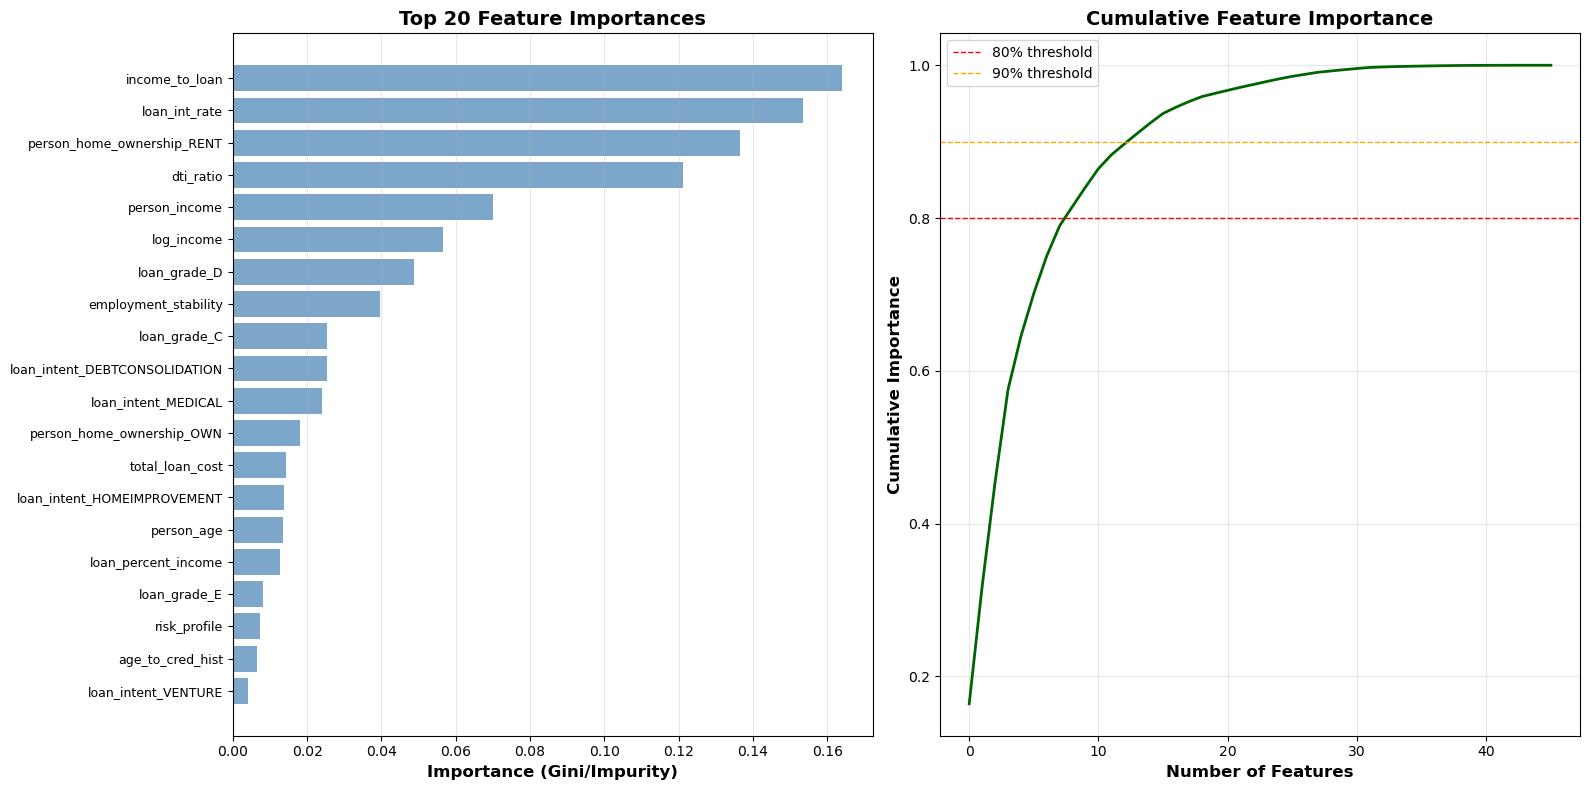

 Saved: artifacts/feature_importance_native.png
 Saved: artifacts/feature_importance.csv

Features needed for 80% importance: 9/46
Features needed for 90% importance: 14/46

2. PERMUTATION IMPORTANCE ANALYSIS

Computing permutation importance on test set (this may take a moment)...

Top 20 Features (Permutation Importance):
                           feature  importance_mean  importance_std
                    num__dti_ratio         0.143085        0.003020
          num__loan_percent_income         0.096880        0.002647
               num__income_to_loan         0.081914        0.001749
                   num__log_income         0.035465        0.002359
                num__person_income         0.033506        0.002041
    cat__person_home_ownership_OWN         0.020129        0.003174
                 cat__loan_grade_D         0.017233        0.001568
   cat__person_home_ownership_RENT         0.014485        0.000895
  cat__loan_intent_HOMEIMPROVEMENT         0.012324        0.0

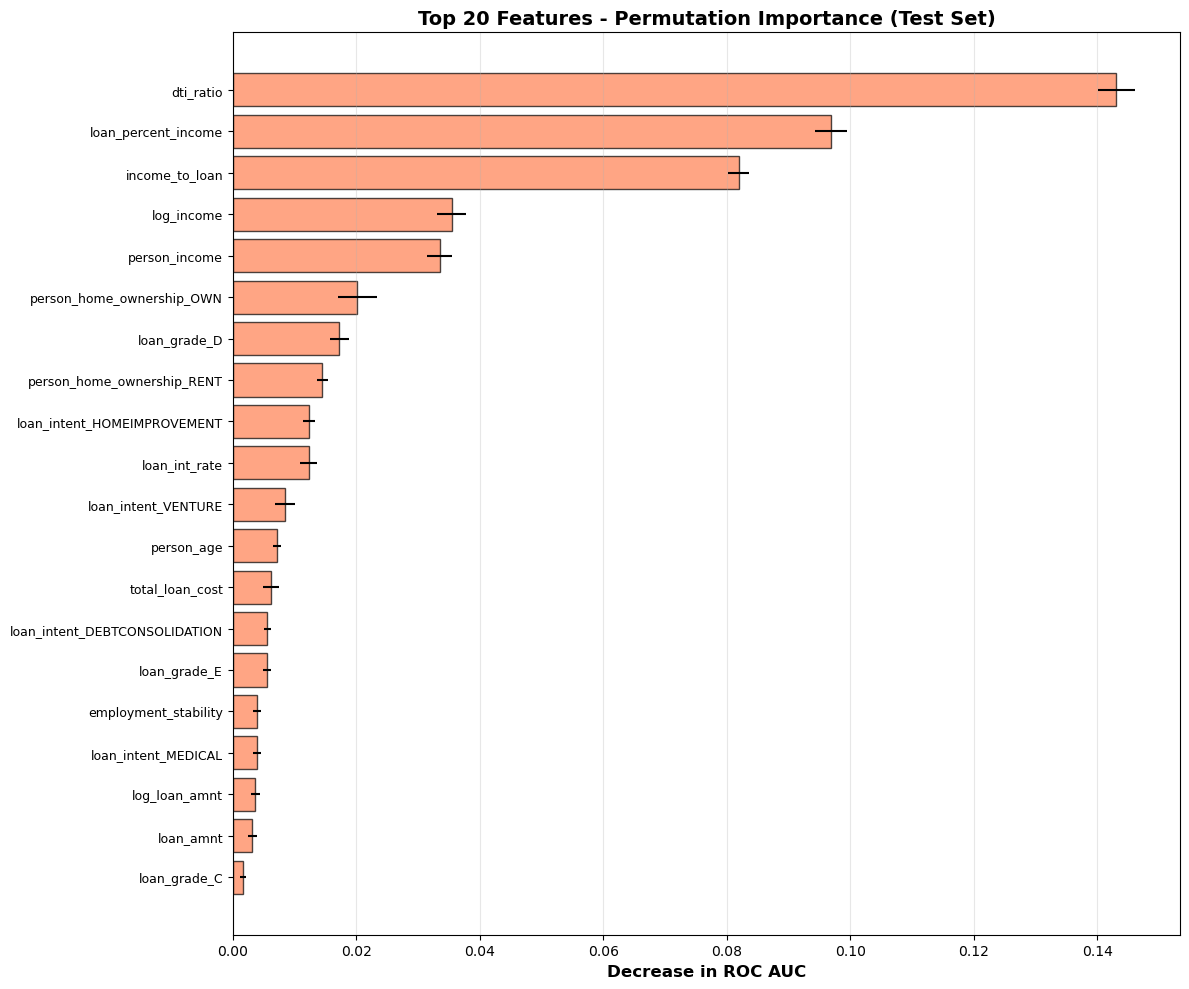

 Saved: artifacts/permutation_importance.png
 Saved: artifacts/permutation_importance.csv

3. PARTIAL DEPENDENCE PLOTS

Generating Partial Dependence Plots for top 6 numeric features...


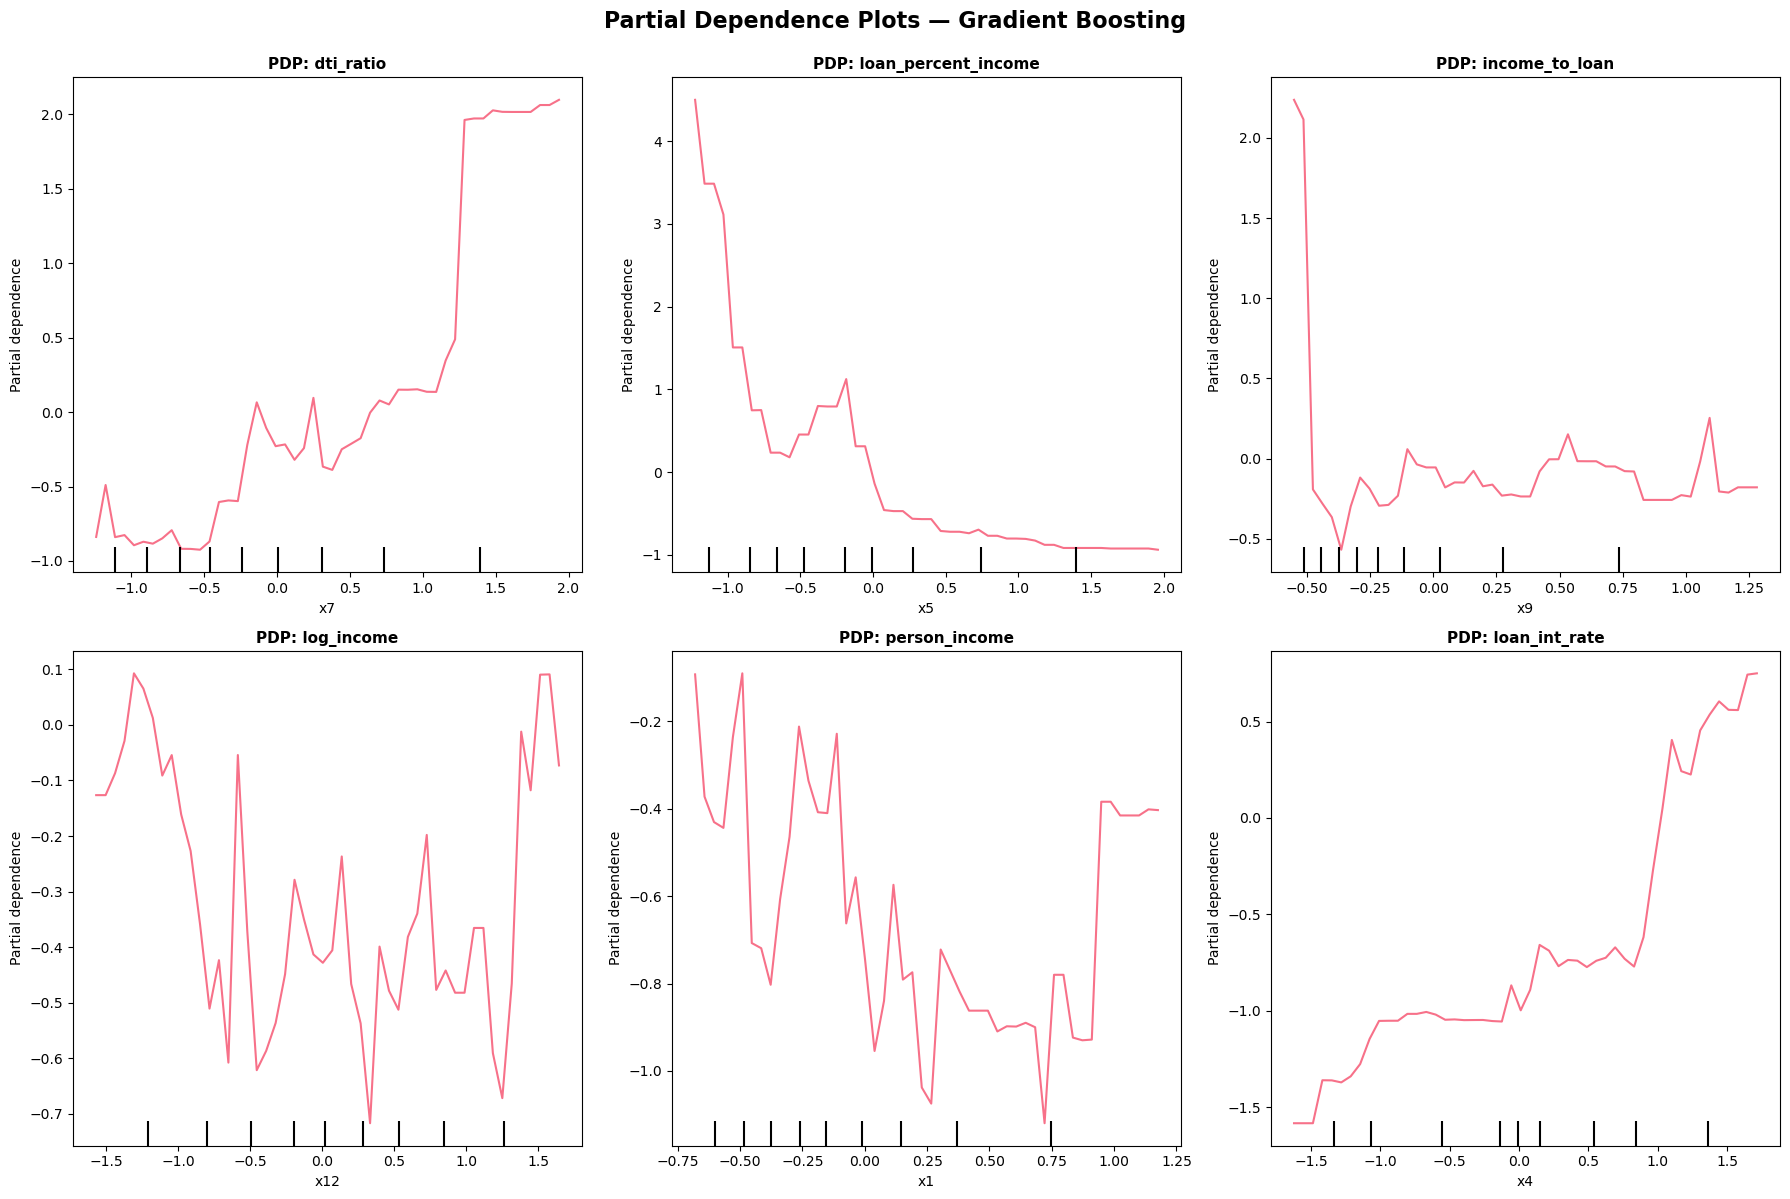

 Saved: artifacts/partial_dependence_plots.png

4. TWO-WAY INTERACTION PLOTS

Generating 2D Partial Dependence for top 2 feature pairs...


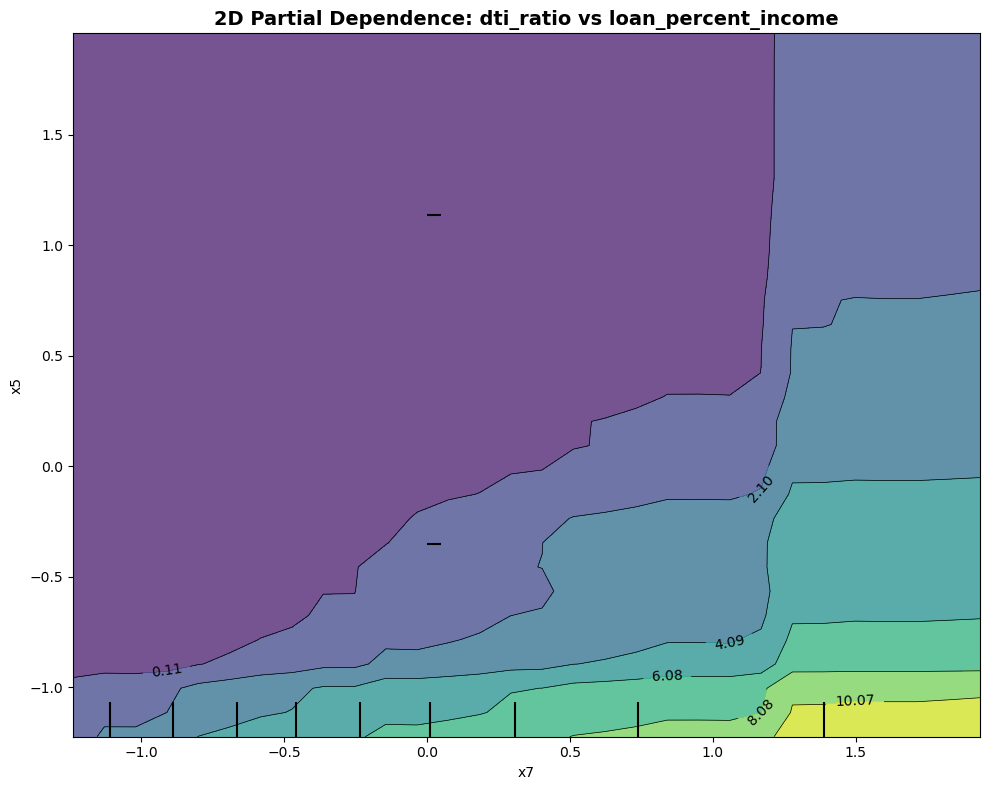

 Saved: artifacts/partial_dependence_2d.png

5. INTERPRETATION SUMMARY

 Interpretation summary saved to: artifacts/interpretation_summary.json

6. KEY INSIGHTS

 INTERPRETATION INSIGHTS:

  • Top feature (native): income_to_loan
    - Importance: 0.1640

  • Top feature (permutation): dti_ratio
    - Impact on AUC: 0.1431 ± 0.0030

  • Feature efficiency:
    - 9 features explain 80% of importance
    - 14 features explain 90% of importance
    - Potential for feature reduction from 46 to ~14 features

  • Feature engineering impact:
    - 4/10 top features are engineered
    - Engineered features: income_to_loan, dti_ratio, log_income, employment_stability

======= MODEL INTERPRETATION COMPLETE =======

All interpretation artifacts saved to 'artifacts/' directory:
  • Feature importance CSV and plots
  • Permutation importance CSV and plots
  • Partial dependence plots
  • Interpretation summary JSON


In [24]:
# ========== 11. MODEL INTERPRETATION ==========
print("======= 11. MODEL INTERPRETATION =======\n")

print(f"Interpreting: {best_model_name}")
print(f"Model type: {type(best_model).__name__}")

# ========== 1. FEATURE IMPORTANCE (TREE-BASED MODELS) ==========
print("\n1. FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Check if model has feature_importances_ attribute (tree-based)
has_native_importance = hasattr(best_model, 'feature_importances_')

if has_native_importance:
    print("\nUsing native feature importances (Gini/impurity-based)...")
    
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Get feature names from preprocessor
    try:
        feature_names = preprocessor.get_feature_names_out()
    except:
        feature_names = [f"feature_{i}" for i in range(len(importances))]
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 Most Important Features:")
    print(importance_df.head(20).to_string(index=False))
    
    # Plot feature importances
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 20 features
    top_20 = importance_df.head(20)
    axes[0].barh(range(len(top_20)), top_20['importance'].values, color='steelblue', alpha=0.7)
    axes[0].set_yticks(range(len(top_20)))
    axes[0].set_yticklabels([name.split('__')[1] if '__' in name else name 
                              for name in top_20['feature']], fontsize=9)
    axes[0].set_xlabel('Importance (Gini/Impurity)', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Cumulative importance
    importance_df_sorted = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
    cumulative_importance = np.cumsum(importance_df_sorted['importance'].values)
    axes[1].plot(range(len(cumulative_importance)), cumulative_importance, linewidth=2, color='darkgreen')
    axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, label='80% threshold')
    axes[1].axhline(y=0.9, color='orange', linestyle='--', linewidth=1, label='90% threshold')
    axes[1].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
    axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('artifacts/feature_importance_native.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: artifacts/feature_importance_native.png")
    
    # Save importance data
    importance_df.to_csv('artifacts/feature_importance.csv', index=False)
    print(" Saved: artifacts/feature_importance.csv")
    
    # Calculate how many features needed for 80% and 90% importance
    n_80 = np.argmax(cumulative_importance >= 0.8) + 1
    n_90 = np.argmax(cumulative_importance >= 0.9) + 1
    print(f"\nFeatures needed for 80% importance: {n_80}/{len(importances)}")
    print(f"Features needed for 90% importance: {n_90}/{len(importances)}")

else:
    print("Model does not have native feature importances (not tree-based)")
    importance_df = None

# ========== 2. PERMUTATION IMPORTANCE (MODEL-AGNOSTIC) ==========
print("\n2. PERMUTATION IMPORTANCE ANALYSIS")
print("="*50)

print("\nComputing permutation importance on test set (this may take a moment)...")
perm_importance = permutation_importance(
    best_model, 
    X_test_transformed, 
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1
)

# Get feature names
try:
    feature_names_perm = preprocessor.get_feature_names_out()
except:
    feature_names_perm = [f"feature_{i}" for i in range(X_test_transformed.shape[1])]

# Create permutation importance dataframe
perm_importance_df = pd.DataFrame({
    'feature': feature_names_perm,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nTop 20 Features (Permutation Importance):")
print(perm_importance_df.head(20).to_string(index=False))

# Plot permutation importance
fig, ax = plt.subplots(figsize=(12, 10))
top_20_perm = perm_importance_df.head(20)
y_pos = range(len(top_20_perm))
ax.barh(y_pos, top_20_perm['importance_mean'].values, 
        xerr=top_20_perm['importance_std'].values,
        color='coral', alpha=0.7, edgecolor='black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels([name.split('__')[1] if '__' in name else name 
                     for name in top_20_perm['feature']], fontsize=9)
ax.set_xlabel('Decrease in ROC AUC', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Features - Permutation Importance (Test Set)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Saved: artifacts/permutation_importance.png")

# Save permutation importance
perm_importance_df.to_csv('artifacts/permutation_importance.csv', index=False)
print(" Saved: artifacts/permutation_importance.csv")

# ========== 3. PARTIAL DEPENDENCE PLOTS ==========
print("\n3. PARTIAL DEPENDENCE PLOTS")
print("="*50)

# Identify top numeric features for PDP
# Get numeric feature indices
numeric_feature_indices = []
for idx, name in enumerate(feature_names_perm):
    if 'num__' in name:
        numeric_feature_indices.append(idx)

# Select top 6 numeric features by permutation importance
top_numeric_features = []
for idx, row in perm_importance_df.iterrows():
    feat_idx = list(feature_names_perm).index(row['feature'])
    if feat_idx in numeric_feature_indices:
        top_numeric_features.append(feat_idx)
        if len(top_numeric_features) >= 6:
            break

if len(top_numeric_features) > 0:
    print(f"\nGenerating Partial Dependence Plots for top {len(top_numeric_features)} numeric features...")
    
    # Create PDP display
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Partial Dependence Plots — {best_model_name}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for idx, feat_idx in enumerate(top_numeric_features):
        ax = axes[idx // 3, idx % 3]
        
        # Create PDP for single feature
        display = PartialDependenceDisplay.from_estimator(
            best_model,
            X_test_transformed,
            features=[feat_idx],
            ax=ax,
            kind='average',
            grid_resolution=50
        )
        
        # Update title to show feature name
        feat_name = feature_names_perm[feat_idx]
        clean_name = feat_name.split('__')[1] if '__' in feat_name else feat_name
        ax.set_title(f'PDP: {clean_name}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Feature Value', fontsize=10)
        ax.set_ylabel('Partial Dependence', fontsize=10)
    
    # Remove empty subplots if fewer than 6 features
    for idx in range(len(top_numeric_features), 6):
        fig.delaxes(axes[idx // 3, idx % 3])
    
    plt.tight_layout()
    plt.savefig('artifacts/partial_dependence_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: artifacts/partial_dependence_plots.png")
else:
    print("No numeric features found for Partial Dependence Plots")

# ========== 4. TWO-WAY INTERACTIONS (IF TREE-BASED) ==========
if has_native_importance and len(top_numeric_features) >= 2:
    print("\n4. TWO-WAY INTERACTION PLOTS")
    print("="*50)
    
    print("\nGenerating 2D Partial Dependence for top 2 feature pairs...")
    
    # Select top 2 pairs
    top_2_features = top_numeric_features[:2]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create 2D PDP
    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X_test_transformed,
        features=[(top_2_features[0], top_2_features[1])],
        ax=ax,
        kind='average',
        grid_resolution=30
    )
    
    # Update title
    feat1_name = feature_names_perm[top_2_features[0]].split('__')[1] if '__' in feature_names_perm[top_2_features[0]] else feature_names_perm[top_2_features[0]]
    feat2_name = feature_names_perm[top_2_features[1]].split('__')[1] if '__' in feature_names_perm[top_2_features[1]] else feature_names_perm[top_2_features[1]]
    
    ax.set_title(f'2D Partial Dependence: {feat1_name} vs {feat2_name}', 
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('artifacts/partial_dependence_2d.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: artifacts/partial_dependence_2d.png")

# ========== 5. INTERPRETATION SUMMARY ==========
print("\n5. INTERPRETATION SUMMARY")
print("="*50)

summary = {
    'model': best_model_name,
    'has_native_importance': has_native_importance,
    'n_features': X_train_transformed.shape[1],
    'interpretation_methods': ['permutation_importance']
}

if has_native_importance and importance_df is not None:
    summary['interpretation_methods'].append('native_feature_importance')
    summary['top_5_features_native'] = importance_df.head(5)['feature'].tolist()
    summary['n_features_for_80pct_importance'] = int(n_80)
    summary['n_features_for_90pct_importance'] = int(n_90)

summary['top_5_features_permutation'] = perm_importance_df.head(5)['feature'].tolist()

if len(top_numeric_features) > 0:
    summary['interpretation_methods'].append('partial_dependence')
    summary['n_pdp_plots'] = len(top_numeric_features)

# Save summary
summary_path = 'artifacts/interpretation_summary.json'
with open(summary_path, 'w') as f:
    # Convert non-serializable types
    summary_clean = {k: (v if not isinstance(v, (np.integer, np.floating)) else float(v)) 
                     for k, v in summary.items()}
    json.dump(summary_clean, f, indent=2)
print(f"\n Interpretation summary saved to: {summary_path}")

# ========== 6. KEY INSIGHTS ==========
print("\n6. KEY INSIGHTS")
print("="*50)

print("\n INTERPRETATION INSIGHTS:")

if has_native_importance and importance_df is not None:
    print(f"\n  • Top feature (native): {importance_df.iloc[0]['feature'].split('__')[1] if '__' in importance_df.iloc[0]['feature'] else importance_df.iloc[0]['feature']}")
    print(f"    - Importance: {importance_df.iloc[0]['importance']:.4f}")

print(f"\n  • Top feature (permutation): {perm_importance_df.iloc[0]['feature'].split('__')[1] if '__' in perm_importance_df.iloc[0]['feature'] else perm_importance_df.iloc[0]['feature']}")
print(f"    - Impact on AUC: {perm_importance_df.iloc[0]['importance_mean']:.4f} ± {perm_importance_df.iloc[0]['importance_std']:.4f}")

if has_native_importance:
    print(f"\n  • Feature efficiency:")
    print(f"    - {n_80} features explain 80% of importance")
    print(f"    - {n_90} features explain 90% of importance")
    print(f"    - Potential for feature reduction from {len(importances)} to ~{n_90} features")

# Identify engineered vs original features in top 10
if importance_df is not None:
    top_10_features = importance_df.head(10)['feature'].tolist()
    engineered_in_top_10 = []
    original_in_top_10 = []
    
    for feat in top_10_features:
        clean_name = feat.split('__')[1] if '__' in feat else feat
        # Check if engineered (rough heuristic based on naming)
        if any(eng_feat in clean_name for eng_feat in ['dti', 'total_loan', 'income_to_loan', 
                                                        'age_to_cred', 'stability', 'log_', 
                                                        'bucket', 'quartile', 'risk_profile']):
            engineered_in_top_10.append(clean_name)
        else:
            original_in_top_10.append(clean_name)
    
    if len(engineered_in_top_10) > 0:
        print(f"\n  • Feature engineering impact:")
        print(f"    - {len(engineered_in_top_10)}/10 top features are engineered")
        print(f"    - Engineered features: {', '.join(engineered_in_top_10[:5])}")

print("\n======= MODEL INTERPRETATION COMPLETE =======")
print("\nAll interpretation artifacts saved to 'artifacts/' directory:")
print("  • Feature importance CSV and plots")
print("  • Permutation importance CSV and plots")
print("  • Partial dependence plots")
print("  • Interpretation summary JSON")

## 12. Reproducibility & Artifacts

This section consolidates and verifies all project outputs to ensure full reproducibility. All expected artifacts—including trained models, preprocessing objects, evaluation metrics, data dictionaries, feature-importance files, and visualization assets—are checked for completeness. A comprehensive project summary is generated, capturing dataset details, feature counts, training and test sizes, selected model performance, and the number of artifacts produced across each category.

Environment information (Python version and library versions) is saved to support exact reproducibility of results. The notebook is exported to HTML for report generation, and a final deliverables checklist confirms that all required components of Milestone 2 have been completed. A final summary report compiles key results, performance metrics, and model descriptions, and all artifacts are organized into structured folders for submission. This ensures that the entire analysis is transparent, traceable, and fully reproducible.


In [25]:
# ========== 12. REPRODUCIBILITY & ARTIFACTS ==========
print("======= 12. REPRODUCIBILITY & ARTIFACTS =======\n")

# ========== 1. VERIFY ALL ARTIFACTS EXIST ==========
print("1. VERIFYING ARTIFACTS")
print("="*50)

# Define expected artifacts
expected_artifacts = {
    'models': [
        'preprocessor.joblib',
        'preprocessor_engineered.joblib',
        'best_model.joblib',
        'dummy_baseline.joblib',
        'logistic_regression_best.joblib',
        'lda_best.joblib',
        'qda_best.joblib',
        'naive_bayes_best.joblib',
        'knn_best.joblib',
        'decision_tree_best.joblib',
        'bagging_best.joblib',
        'random_forest_best.joblib',
        'adaboost_best.joblib',
        'gradient_boosting_best.joblib',
        'svm_linear_best.joblib',
        'svm_rbf_best.joblib',
        'mlp_best.joblib'
    ],
    'artifacts': [
        'data_dictionary_pre_preprocessing.csv',
        'data_dictionary_post_preprocessing.csv',
        'feature_provenance.json',
        'model_leaderboard.csv',
        'model_selection_metadata.json',
        'metrics_test.json',
        'threshold_analysis.csv',
        'feature_importance.csv',
        'permutation_importance.csv',
        'interpretation_summary.json'
    ],
    'Output': [
        'numeric_distributions.png',
        'categorical_distributions.png',
        'numeric_vs_target_boxplots.png',
        'categorical_vs_target_stacked.png',
        'pearson_correlation_matrix.png',
        'spearman_correlation_matrix.png',
        'roc_curve_dummy_baseline.png',
        'roc_curve_logistic_regression.png',
        'roc_curve_lda.png',
        'roc_curve_qda.png',
        'roc_curve_naive_bayes.png',
        'roc_curve_knn.png',
        'roc_curve_decision_tree.png',
        'roc_curve_bagging.png',
        'roc_curve_random_forest.png',
        'roc_curve_adaboost.png',
        'roc_curve_gradient_boosting.png',
        'roc_curve_svm_linear.png',
        'roc_curve_svm_rbf.png',
        'roc_curve_mlp.png'
    ]
}

# Check artifacts
missing_artifacts = []
for folder, files in expected_artifacts.items():
    for file in files:
        filepath = f"{folder}/{file}"
        if not os.path.exists(filepath):
            missing_artifacts.append(filepath)

if missing_artifacts:
    print("\n  Missing artifacts:")
    for artifact in missing_artifacts:
        print(f"  - {artifact}")
else:
    print("\n All expected artifacts present")

# ========== 2. CREATE COMPREHENSIVE ARTIFACT SUMMARY ==========
print("\n2. CREATING ARTIFACT SUMMARY")
print("="*50)

artifact_summary = {
    'project': 'Team 6 - Milestone 2',
    'dataset': 'credit_risk_dataset.csv',
    'target': 'loan_status',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'random_seed': RANDOM_STATE,
    'test_size': TEST_SIZE,
    'n_samples': {
        'total': len(df_clean),
        'train': X_train_transformed.shape[0],
        'test': X_test_transformed.shape[0]
    },
    'n_features': {
        'original': len(feature_provenance['original']),
        'engineered': len(feature_provenance['engineered']),
        'post_preprocessing': X_train_transformed.shape[1]
    },
    'best_model': {
        'name': best_model_name,
        'test_auc': float(test_auc),
        'test_accuracy': float(test_accuracy),
        'test_f1': float(test_f1)
    },
    'artifacts': {
        'models': len(expected_artifacts['models']),
        'data_files': len(expected_artifacts['artifacts']),
        'visualizations': len(expected_artifacts['Output'])
    }
}

summary_path = 'artifacts/project_summary.json'
with open(summary_path, 'w') as f:
    json.dump(artifact_summary, f, indent=2)
print(f" Project summary saved to: {summary_path}")

# ========== 3. SAVE ENVIRONMENT INFORMATION ==========
print("\n3. SAVING ENVIRONMENT INFORMATION")
print("="*50)

environment_info = {
    'python_version': sys.version,
    'numpy_version': np.__version__,
    'pandas_version': pd.__version__,
    'sklearn_version': __import__('sklearn').__version__,
    'matplotlib_version': __import__('matplotlib').__version__,
    'seaborn_version': sns.__version__,
    'random_seed': RANDOM_STATE,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

env_path = 'artifacts/environment_info.json'
with open(env_path, 'w') as f:
    json.dump(environment_info, f, indent=2)
print(f" Environment info saved to: {env_path}")

# ========== 4. EXPORT NOTEBOOK TO HTML (for PDF conversion) ==========
print("\n4. EXPORTING NOTEBOOK TO HTML")
print("="*50)

try:
    # Get the notebook name from the current working directory
    notebook_name = 'Team6_Milestone2.ipynb'  # Adjust if needed
    
    # Use nbconvert to export to HTML
    os.system(f'jupyter nbconvert --to html --execute "{notebook_name}" --output "artifacts/Team6_Milestone2_Report.html"')
    
    print(f" Notebook exported to HTML: artifacts/Team6_Milestone2_Report.html")
    print("\n   To convert to PDF:")
    print("     Option 1: Use your browser to open the HTML and 'Print to PDF'")
    print("     Option 2: Install wkhtmltopdf and run:")
    print("               wkhtmltopdf artifacts/Team6_Milestone2_Report.html artifacts/Team6_Milestone2_Report.pdf")
    print("     Option 3: Use nbconvert with LaTeX (requires LaTeX installation):")
    print(f"               jupyter nbconvert --to pdf \"{notebook_name}\"")
    
except Exception as e:
    print(f"  Could not auto-export notebook: {e}")
    print("\n  Manual export instructions:")
    print("  1. File → Download as → HTML (.html)")
    print("  2. Open HTML in browser and Print to PDF")
    print("  OR")
    print("  3. File → Download as → PDF via LaTeX (.pdf)")

# ========== 5. CREATE FINAL DELIVERABLES CHECKLIST ==========
print("\n5. FINAL DELIVERABLES CHECKLIST")
print("="*50)

checklist = {
    'EDA with plots': True,
    'Full preprocessing pipeline': True,
    'Feature engineering': True,
    'Final dataset characteristics': True,
    'Multiple candidate algorithms (14 models)': True,
    'Cross-validation protocol': True,
    'Hyperparameter tuning': True,
    'Model comparison artifact': True,
    'Selected model identified': True,
    'Performance metrics (CM, ROC/AUC, PR, accuracy/F1)': True,
    'Model interpretation (feature importances, PDP)': True,
    'Reproducibility artifacts': True,
    'Code quality & documentation': True
}

print("\nDELIVERABLES STATUS:")
for item, status in checklist.items():
    print(f"  {item}")

# ========== 6. GENERATE FINAL SUMMARY REPORT ==========
print("\n6. GENERATING FINAL SUMMARY REPORT")
print("="*50)

summary_report = f"""
{'='*80}
TEAM 6 - MILESTONE 2 - FINAL SUMMARY REPORT
{'='*80}

PROJECT INFORMATION
-------------------
Dataset: credit_risk_dataset.csv
Target: loan_status (binary classification: 0=No Default, 1=Default)
Team Members: John Holik, Claiton Pinto, Marina Bunyatova
Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATA SUMMARY
------------
Total Samples: {len(df_clean):,}
  - Training Set: {X_train_transformed.shape[0]:,} ({(1-TEST_SIZE)*100:.0f}%)
  - Test Set: {X_test_transformed.shape[0]:,} ({TEST_SIZE*100:.0f}%)

Class Distribution (Test Set):
  - Class 0 (No Default): {test_class_counts[0]:,} ({test_class_pcts[0]:.2%})
  - Class 1 (Default): {test_class_counts[1]:,} ({test_class_pcts[1]:.2%})

FEATURE ENGINEERING
-------------------
Original Features: {len(feature_provenance['original'])}
Engineered Features: {len(feature_provenance['engineered'])}
Total Features (after preprocessing): {X_train_transformed.shape[1]}

MODELS EVALUATED
----------------
{len(all_metrics)} models trained and evaluated:
{chr(10).join([f"  {i+1}. {m['Model']}" for i, m in enumerate(all_metrics)])}

BEST MODEL SELECTION
--------------------
Selected Model: {best_model_name}
Selection Criterion: Test AUC (ROC-AUC Score)

FINAL TEST PERFORMANCE
----------------------
ROC AUC: {test_auc:.4f}
PR AUC (Average Precision): {test_avg_precision:.4f}
Accuracy: {test_accuracy:.4f}
Balanced Accuracy: {test_balanced_acc:.4f}
F1 Score: {test_f1:.4f}
Brier Score: {test_brier:.4f}

Sensitivity (Class 0): {test_sensitivity:.4f}
Specificity (Class 1): {test_specificity:.4f}

Confusion Matrix:
                 Predicted: No Default  Predicted: Default
Actual: No Default      {cm_test_final[0,0]:>6}            {cm_test_final[0,1]:>6}
Actual: Default         {cm_test_final[1,0]:>6}            {cm_test_final[1,1]:>6}

ARTIFACTS GENERATED
-------------------
Models: {len(expected_artifacts['models'])} saved models
Data Files: {len(expected_artifacts['artifacts'])} CSV/JSON files
Visualizations: {len(expected_artifacts['Output'])} plots

All artifacts saved to:
  - models/ (trained models and preprocessors)
  - artifacts/ (metrics, summaries, analysis outputs)
  - Output/ (EDA and model evaluation plots)

REPRODUCIBILITY
---------------
Random Seed: {RANDOM_STATE}
Python Version: {sys.version.split()[0]}
Key Libraries:
  - NumPy: {np.__version__}
  - Pandas: {pd.__version__}
  - Scikit-learn: {__import__('sklearn').__version__}
  - Matplotlib: {__import__('matplotlib').__version__}
  - Seaborn: {sns.__version__}

{'='*80}
END OF REPORT
{'='*80}
"""

# Save report
report_path = 'artifacts/FINAL_SUMMARY_REPORT.txt'
with open(report_path, 'w') as f:
    f.write(summary_report)

print(summary_report)
print(f"\n Final summary report saved to: {report_path}")

# ========== 7. LIST ALL DELIVERABLES ==========
print("\n7. COMPLETE ARTIFACT LISTING")
print("="*50)

print("\nDIRECTORY STRUCTURE:")
for folder in ['models', 'artifacts', 'Output']:
    if os.path.exists(folder):
        files = os.listdir(folder)
        print(f"\n{folder}/ ({len(files)} files)")
        for file in sorted(files)[:10]:  # Show first 10
            filepath = os.path.join(folder, file)
            size = os.path.getsize(filepath)
            size_str = f"{size/1024:.1f} KB" if size > 1024 else f"{size} B"
            print(f"  - {file} ({size_str})")
        if len(files) > 10:
            print(f"  ... and {len(files)-10} more files")

print("\n" + "="*80)
print("======= REPRODUCIBILITY & ARTIFACTS COMPLETE =======")
print("="*80)
print("\n ALL DELIVERABLES READY")
print("\n NEXT STEPS:")
print("  1. Review artifacts/FINAL_SUMMARY_REPORT.txt")
print("  2. Export notebook to PDF using one of the methods above")
print("  3. Package all files (notebook + models/ + artifacts/ + Output/) for submission")
print("\n PROJECT COMPLETE!")

======= 12. REPRODUCIBILITY & ARTIFACTS =======

1. VERIFYING ARTIFACTS

 All expected artifacts present

2. CREATING ARTIFACT SUMMARY
 Project summary saved to: artifacts/project_summary.json

3. SAVING ENVIRONMENT INFORMATION
 Environment info saved to: artifacts/environment_info.json

4. EXPORTING NOTEBOOK TO HTML
 Notebook exported to HTML: artifacts/Team6_Milestone2_Report.html

   To convert to PDF:
     Option 1: Use your browser to open the HTML and 'Print to PDF'
     Option 2: Install wkhtmltopdf and run:
               wkhtmltopdf artifacts/Team6_Milestone2_Report.html artifacts/Team6_Milestone2_Report.pdf
     Option 3: Use nbconvert with LaTeX (requires LaTeX installation):
               jupyter nbconvert --to pdf "Team6_Milestone2.ipynb"

5. FINAL DELIVERABLES CHECKLIST

DELIVERABLES STATUS:
  EDA with plots
  Full preprocessing pipeline
  Feature engineering
  Final dataset characteristics
  Multiple candidate algorithms (14 models)
  Cross-validation protocol
  Hyperpa